# Import

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
import seaborn as sns
import sys
import xgboost as xgb
from xgboost import XGBRegressor
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
train_data = pd.read_csv('../Datasets/train_V2.csv')

# Data Fields
DBNOs - Number of enemy players knocked.

assists - Number of enemy players this player damaged that were killed by teammates.

boosts - Number of boost items used.

damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

headshotKills - Number of enemy players killed with headshots.

heals - Number of healing items used.

Id - Player’s Id

killPlace - Ranking in match of number of enemy players killed.

killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

killStreaks - Max number of enemy players killed in a short amount of time.

kills - Number of enemy players killed.

longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

matchDuration - Duration of match in seconds.

matchId - ID to identify match. There are no matches that are in both the training and testing set.

matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

revives - Number of times this player revived teammates.

rideDistance - Total distance traveled in vehicles measured in meters.

roadKills - Number of kills while in a vehicle.

swimDistance - Total distance traveled by swimming measured in meters.

teamKills - Number of times this player killed a teammate.

vehicleDestroys - Number of vehicles destroyed.

walkDistance - Total distance traveled on foot measured in meters.

weaponsAcquired - Number of weapons picked up.

winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

numGroups - Number of groups we have data for in the match.

maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

# Data Analysis, Cleansing, Engineering, Pre-Processing

### View the dataset

In [60]:
train_data

Id         groupId         matchId  assists  boosts  \
0        7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1        eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2        1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3        4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4        315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   
...                 ...             ...             ...      ...     ...   
4446961  afff7f652dbc10  d238e426f50de7  18492834ce5635        0       0   
4446962  f4197cf374e6c0  408cdb5c46b2ac  ee854b837376d9        0       1   
4446963  e1948b1295c88a  e26ac84bdf7cef  6d0cd12784f1ab        0       0   
4446964  cc032cdd73b7ac  c2223f35411394  c9c701d0ad758a        0       4   
4446965  0d8e7ed728b6fd  8c74f72fedf5ff  62a16aabcc095c        0       2   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0               0.00      0              0      0         60  ...        0   
1              91.47      0              0      0         57  ...        0   
2              68.00      0              0      0         47  ...        0   
3              32.90      0              0      0         75  ...        0   
4             100.00      0              0      0         45  ...        0   
...              ...    ...            ...    ...        ...  ...      ...   
4446961         0.00      0              0      0         74  ...        0   
4446962        44.15      0              0      0         69  ...        0   
4446963        59.06      0              0      0         66  ...        0   
4446964       180.40      1              1      2         11  ...        2   
4446965       268.00      0              0      1         18  ...        0   

         rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0              0.0000          0         0.000          0               0   
1              0.0045          0        11.040          0               0   
2              0.0000          0         0.000          0               0   
3              0.0000          0         0.000          0               0   
4              0.0000          0         0.000          0               0   
...               ...        ...           ...        ...             ...   
4446961     1292.0000          0         0.000          0               0   
4446962        0.0000          0         0.000          0               0   
4446963        0.0000          0         2.184          0               0   
4446964        0.0000          0         0.000          0               0   
4446965     1369.0000          0         0.000          0               0   

         walkDistance  weaponsAcquired  winPoints  winPlacePerc  
0              244.80                1       1466        0.4444  
1             1434.00                5          0        0.6400  
2              161.80                2          0        0.7755  
3              202.70                3          0        0.1667  
4               49.75                2          0        0.1875  
...               ...              ...        ...           ...  
4446961       1019.00                3       1507        0.1786  
4446962         81.70                6          0        0.2935  
4446963        788.70                4          0        0.4815  
4446964       2748.00                8          0        0.8000  
4446965       1244.00                5          0        0.5464  

[4446966 rows x 29 columns]

### Check column names, data types

In [61]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

### Check missing values

In [62]:
is_NaN = train_data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = train_data[row_has_NaN]
rows_with_NaN

Id         groupId         matchId  assists  boosts  \
2744604  f70c74418bb064  12dfbede33f92b  224a123c53e008        0       0   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
2744604          0.0      0              0      0          1  ...        0   

         rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
2744604           0.0          0           0.0          0               0   

         walkDistance  weaponsAcquired  winPoints  winPlacePerc  
2744604           0.0                0          0           NaN  

[1 rows x 29 columns]

#### Data Cleansing 1
Delete Missing Value, Ids

In [3]:
def delete_useless_data(train_data):
    train_data_ = train_data.copy()
    train_data_ = train_data_.drop(["Id","groupId","matchId"],axis=1)
    train_data_ = train_data_.drop(2744604)
    train_data_ = train_data_.reset_index(drop=True)
    y_train = train_data_["winPlacePerc"]
    X_train = train_data_.drop(["winPlacePerc"],axis=1)
    return X_train,y_train,train_data_

In [4]:
X_train,y_train,train = delete_useless_data(train_data)

### Feature Plotting 

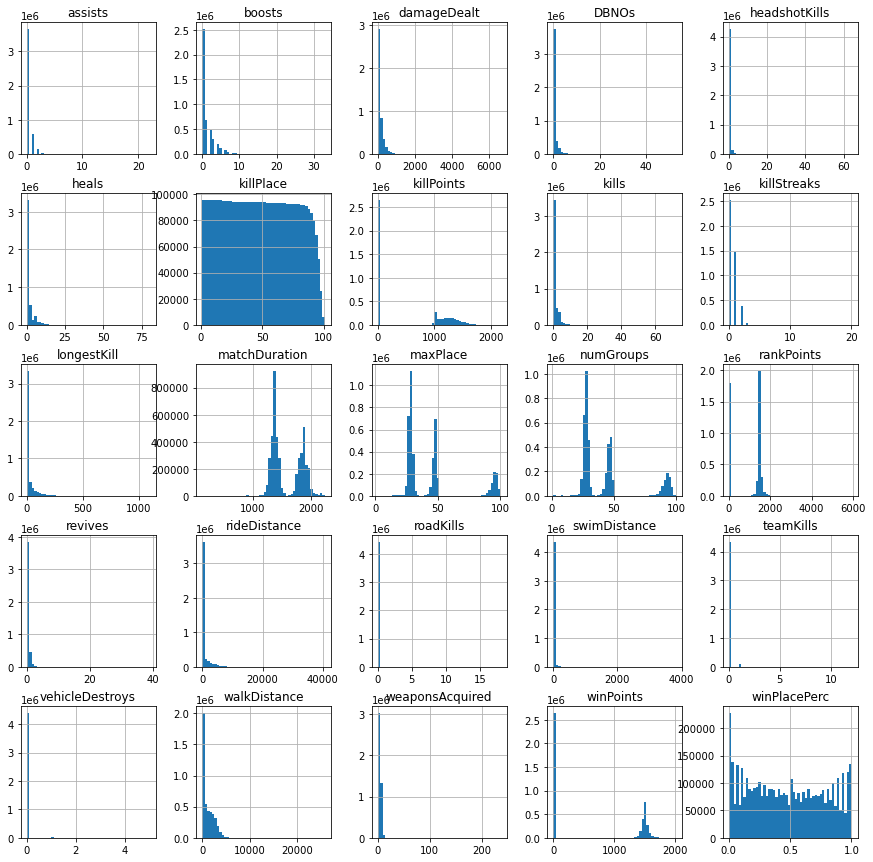

In [9]:
train.hist(bins=50, layout=(5,5),figsize=(15, 15))
plt.show()

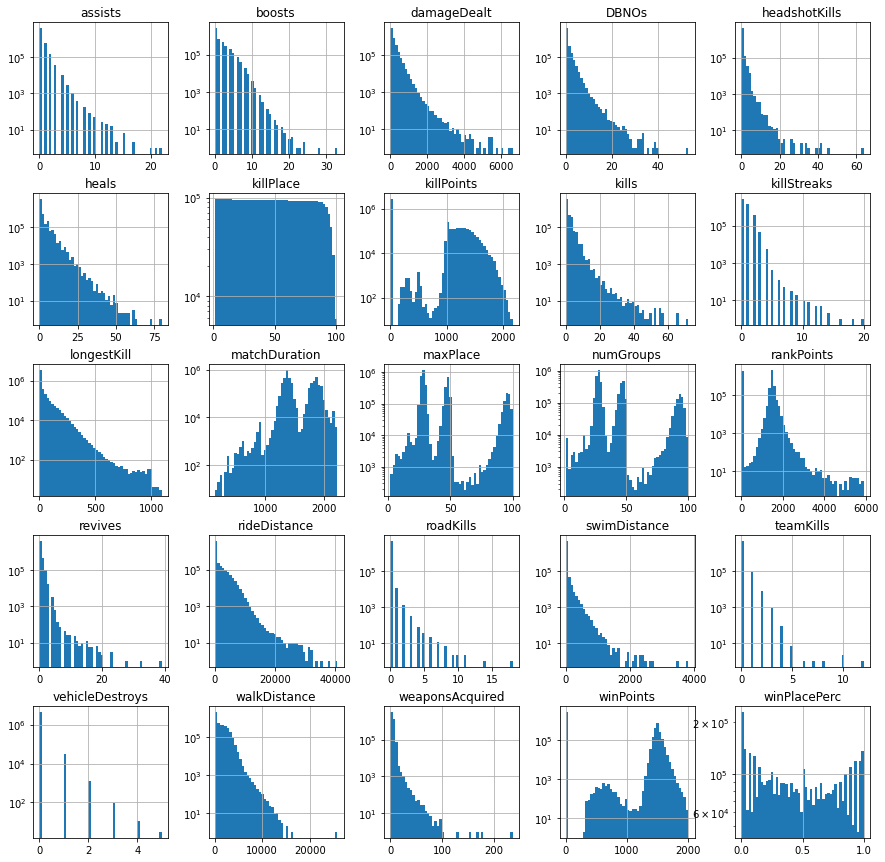

In [8]:
#Log scale
train.hist(bins=50, layout=(5,5),figsize=(15, 15),log=True)
plt.show()

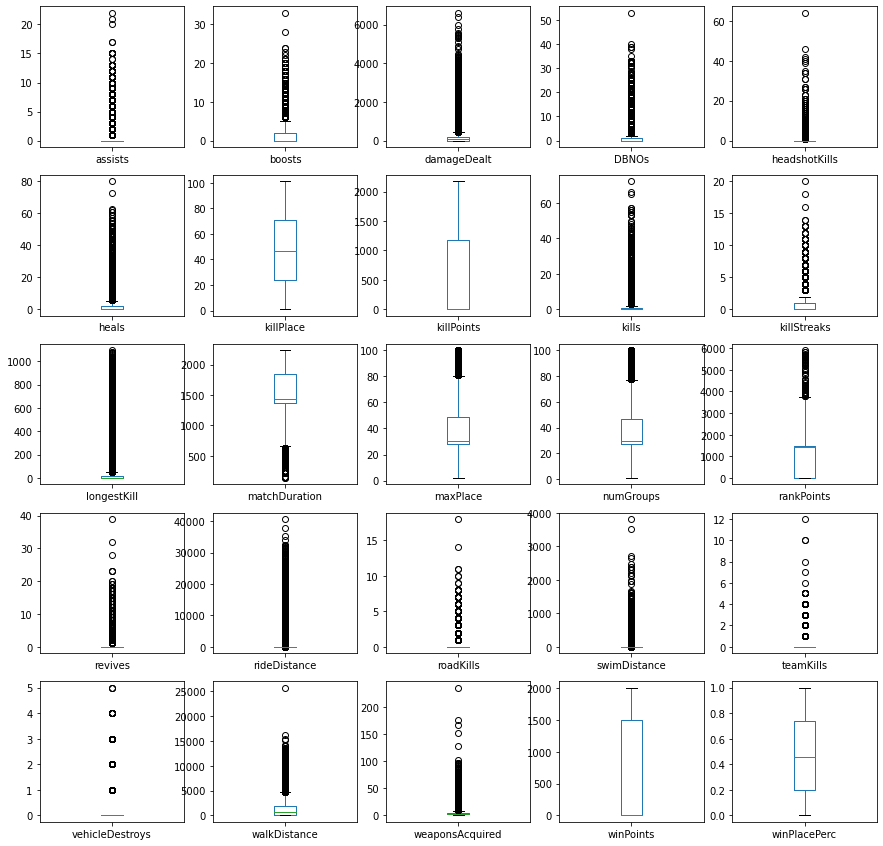

In [66]:
train.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(15, 15))
plt.show()

### Data Normalization 
Min-Max Normalization

In [5]:
def normalize_data(dataset):
    dataset_ = dataset.copy()
    dataset_quantitative = dataset_.loc[:, dataset_.columns != 'matchType']
    for feature in dataset_quantitative:
        dataset_[feature]=(dataset_[feature]-dataset_[feature].min())/(dataset_[feature].max()-dataset_[feature].min())
    return dataset_

In [6]:
X_train = normalize_data(X_train)
train = pd.concat([X_train,y_train],axis=1)

### Cluster Analysis

In [7]:
def getAverageWPP(y,n_clusters):
    means = [0]*n_clusters
    for i in range(n_clusters):
        means[i] = y[y["cluster"] == i]["Y"].mean()
    return means

In [16]:
#One hot encoding
X_train_temp = pd.get_dummies(data = X_train, columns = ["matchType"])

#Turn numpy array into pandas dataframe
y_train_temp = pd.DataFrame({"Y": y_train})

#Initialize the kmeans
kmeans = KMeans()

#### Due to the time problem, 2 to 10 clusters are decided to be trained

n_clusters:  2 ,Score:  1700772.0157748582 ,Average WPP:  [0.46476373800952725, 0.47808063248598254]
n_clusters:  3 ,Score:  1696587.4006154614 ,Average WPP:  [0.46476373800952725, 0.49110384516815836, 0.47341106429063695]
n_clusters:  4 ,Score:  2010972.0346284197 ,Average WPP:  [0.46476373800952725, 0.4858014244133839, 0.46085048894348124, 0.4910966126356347]
n_clusters:  5 ,Score:  2107413.419538477 ,Average WPP:  [0.4654673331482458, 0.4858014244133839, 0.4608496501576607, 0.4910966126356347, 0.46381573014471816]
n_clusters:  6 ,Score:  2450946.1634372524 ,Average WPP:  [0.46451542322577083, 0.49108748830633536, 0.4858014244133839, 0.4635614043987694, 0.4519017153072053, 0.48277683575102587]
n_clusters:  7 ,Score:  2684570.5587074296 ,Average WPP:  [0.4858014244133839, 0.4644975414396983, 0.4519082068421742, 0.4918353663921188, 0.46601951453185064, 0.48277683575102587, 0.47381422643355325]
n_clusters:  8 ,Score:  3014196.192677929 ,Average WPP:  [0.4918353663921188, 0.4659552511629

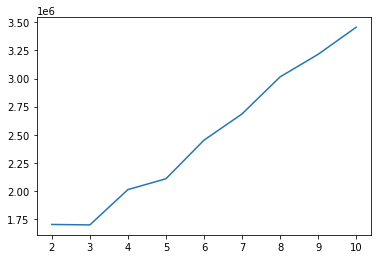

In [10]:
#Used to do score VS n_clustet plotting
scores = []
Xs = []

#n_init = 10
kmeans.n_init = 10

#First run
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0
for i in range(2,11):   
    kmeans.n_clusters = i
    kmeans.fit(X_train_temp)
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans.labels_)
    X_train_temp["cluster"] = kmeans.labels_
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,i)
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    Xs.append(i)
    scores.append(score)
    X_train_temp=X_train_temp.drop(["cluster"],axis=1) 

print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

plt.plot(Xs,scores)

n_clusters:  2 ,Score:  1700772.0157748582 ,Average WPP:  [0.46476373800952725, 0.47808063248598254]
n_clusters:  3 ,Score:  1696587.4006154614 ,Average WPP:  [0.49110384516815836, 0.46476373800952725, 0.47341106429063695]
n_clusters:  4 ,Score:  2010972.032613409 ,Average WPP:  [0.4858014244133839, 0.46476373800952725, 0.4910966533078542, 0.46085042879832727]
n_clusters:  5 ,Score:  2107413.419538477 ,Average WPP:  [0.46381573014471816, 0.4858014244133839, 0.4608496501576607, 0.4910966126356347, 0.4654673331482458]
n_clusters:  6 ,Score:  2450946.1634372524 ,Average WPP:  [0.46451542322577083, 0.4858014244133839, 0.49108748830633536, 0.4635614043987694, 0.4519017153072053, 0.48277683575102587]
n_clusters:  7 ,Score:  2684570.558707429 ,Average WPP:  [0.47381422643355325, 0.4858014244133839, 0.46601951453185064, 0.4918353663921188, 0.48277683575102587, 0.4519082068421742, 0.4644975414396983]
n_clusters:  8 ,Score:  3014196.192677929 ,Average WPP:  [0.46595525116293135, 0.49183536639211

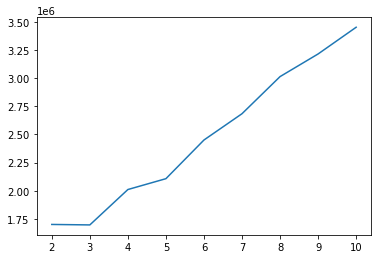

In [19]:
#Used to do score VS n_clustet plotting
scores = []
Xs = []

#n_init = 10
kmeans.n_init = 10

#Second run
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0
for i in range(2,11):   
    kmeans.n_clusters = i
    kmeans.fit(X_train_temp)
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans.labels_)
    X_train_temp["cluster"] = kmeans.labels_
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,i)
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    Xs.append(i)
    scores.append(score)
    X_train_temp=X_train_temp.drop(["cluster"],axis=1) 

print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

plt.plot(Xs,scores)

n_clusters:  2 ,Score:  1700772.0157748582 ,Average WPP:  [0.47808063248598254, 0.46476373800952725]
n_clusters:  3 ,Score:  1696587.4006154612 ,Average WPP:  [0.46476373800952725, 0.47341106429063695, 0.49110384516815836]
n_clusters:  4 ,Score:  2010972.034706931 ,Average WPP:  [0.4608507931278518, 0.4858014244133839, 0.46476373800952725, 0.49109623423955856]
n_clusters:  5 ,Score:  2107413.419538477 ,Average WPP:  [0.4654673331482458, 0.4858014244133839, 0.4608496501576607, 0.4910966126356347, 0.46381573014471816]
n_clusters:  6 ,Score:  2450946.1634372524 ,Average WPP:  [0.4635614043987694, 0.4858014244133839, 0.49108748830633536, 0.4519017153072053, 0.48277683575102587, 0.46451542322577083]
n_clusters:  7 ,Score:  2684570.5587074296 ,Average WPP:  [0.4858014244133839, 0.4644975414396983, 0.4519082068421742, 0.4918353663921188, 0.46601951453185064, 0.48277683575102587, 0.47381422643355325]
n_clusters:  8 ,Score:  3014196.1926779295 ,Average WPP:  [0.46595525116293135, 0.486435562761

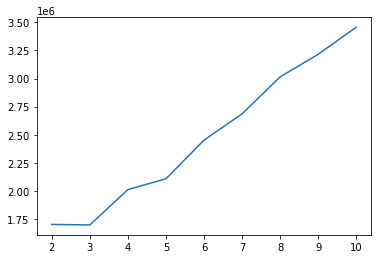

In [11]:
#Used to do score VS n_clustet plotting
scores = []
Xs = []

#n_init = 50
kmeans.n_init = 50

#First run
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0
for i in range(2,11):   
    kmeans.n_clusters = i
    kmeans.fit(X_train_temp)
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans.labels_)
    X_train_temp["cluster"] = kmeans.labels_
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,i)
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    Xs.append(i)
    scores.append(score)
    X_train_temp=X_train_temp.drop(["cluster"],axis=1) 

print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

plt.plot(Xs,scores)

n_clusters:  2 ,Score:  1700772.0157748582 ,Average WPP:  [0.47808063248598254, 0.46476373800952725]
n_clusters:  3 ,Score:  1696587.4006154612 ,Average WPP:  [0.46476373800952725, 0.47341106429063695, 0.49110384516815836]
n_clusters:  4 ,Score:  2010972.034706931 ,Average WPP:  [0.4608507931278518, 0.46476373800952725, 0.4858014244133839, 0.49109623423955856]
n_clusters:  5 ,Score:  2107413.419538477 ,Average WPP:  [0.46381573014471816, 0.4858014244133839, 0.4654673331482458, 0.4910966126356347, 0.4608496501576607]
n_clusters:  6 ,Score:  2450946.163437252 ,Average WPP:  [0.4635614043987694, 0.46451542322577083, 0.4519017153072053, 0.49108748830633536, 0.4858014244133839, 0.48277683575102587]
n_clusters:  7 ,Score:  2684570.558707429 ,Average WPP:  [0.46601951453185064, 0.4858014244133839, 0.4918353663921188, 0.4519082068421742, 0.4644975414396983, 0.48277683575102587, 0.47381422643355325]
n_clusters:  8 ,Score:  3014196.192677929 ,Average WPP:  [0.4918353663921188, 0.4659552511629313

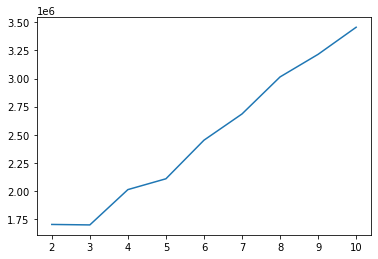

In [20]:
#Used to do score VS n_clustet plotting
scores = []
Xs = []

#n_init = 50
kmeans.n_init = 50

#Second run
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0
for i in range(2,11):   
    kmeans.n_clusters = i
    kmeans.fit(X_train_temp)
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans.labels_)
    X_train_temp["cluster"] = kmeans.labels_
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,i)
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    Xs.append(i)
    scores.append(score)
    X_train_temp=X_train_temp.drop(["cluster"],axis=1) 

print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

plt.plot(Xs,scores)

In [53]:
#Random state = 0, currently used: n_clusters = 17
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0
for i in range(2,21):   
    kmeans.n_clusters = i
    kmeans.fit(X_train_temp)
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans.labels_)
    X_train_temp["cluster"] = kmeans.labels_
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,i)
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    Xs.append(i)
    scores.append(score)
    X_train_temp=X_train_temp.drop(["cluster"],axis=1) 

print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

n_clusters:  2 ,Score:  1700772.0157748582 ,Average WPP:  [0.47808063248598254, 0.46476373800952725]
n_clusters:  3 ,Score:  1696587.4006154612 ,Average WPP:  [0.47341106429063695, 0.46476373800952725, 0.49110384516815836]
n_clusters:  4 ,Score:  2010972.0346683238 ,Average WPP:  [0.4910962779976895, 0.46476373800952725, 0.4858014244133839, 0.46085079226274056]
n_clusters:  5 ,Score:  2107413.419538477 ,Average WPP:  [0.46381573014471816, 0.4654673331482458, 0.4608496501576607, 0.4858014244133839, 0.4910966126356347]
n_clusters:  6 ,Score:  2450946.1634372524 ,Average WPP:  [0.46451542322577083, 0.48277683575102587, 0.4519017153072053, 0.4858014244133839, 0.49108748830633536, 0.4635614043987694]
n_clusters:  7 ,Score:  2684570.558707429 ,Average WPP:  [0.47381422643355325, 0.4644975414396983, 0.4858014244133839, 0.46601951453185064, 0.4519082068421742, 0.4918353663921188, 0.48277683575102587]
n_clusters:  8 ,Score:  3014196.192677929 ,Average WPP:  [0.48530902102785783, 0.4659552511629

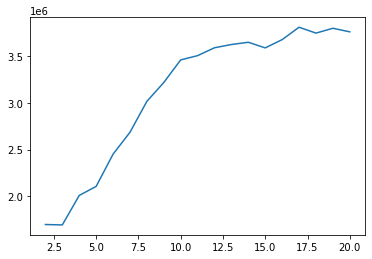

In [55]:
plt.plot(Xs,scores)

#### The one with WPP difference

In [19]:
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0
for i in range(2,21):   
    kmeans.n_clusters = i
    kmeans.fit(X_train_temp)
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans.labels_)
    X_train_temp["cluster"] = kmeans.labels_
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,i)
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    Xs.append(i)
    scores.append(score)
    X_train_temp=X_train_temp.drop(["cluster"],axis=1) 

print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

n_clusters:  2 ,Score:  2410977.682043481 ,Average WPP:  [0.43562774382817704, 0.7499059023265002]
n_clusters:  3 ,Score:  3347262.8352789194 ,Average WPP:  [0.44574256816865865, 0.4364652158695649, 0.7529831016192975]
n_clusters:  4 ,Score:  3716196.9001603206 ,Average WPP:  [0.3826432740486614, 0.3202810215096796, 0.7425571593122683, 0.8201341144603471]
n_clusters:  5 ,Score:  3956693.1525134463 ,Average WPP:  [0.7820074366931732, 0.2987599518874195, 0.7420829304720569, 0.2972824260039439, 0.7853699338052667]
n_clusters:  6 ,Score:  4081617.6191062876 ,Average WPP:  [0.7887607859244876, 0.29465227578860287, 0.7747921977147817, 0.2977057324650074, 0.7161855323003286, 0.7859326793350533]
n_clusters:  7 ,Score:  4039099.2414899585 ,Average WPP:  [0.7898452227932578, 0.7863138704695876, 0.7165204750290067, 0.293524913292235, 0.7165459698012657, 0.7767337506901817, 0.2953351679431991]
n_clusters:  8 ,Score:  3947556.7809104244 ,Average WPP:  [0.29467034123960517, 0.25530500726794786, 0.85

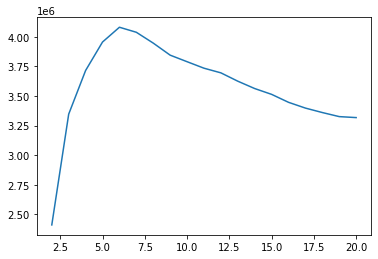

In [20]:
plt.plot(Xs,scores)

#### Distribution plotting

In [257]:
kmeans.n_clusters = 17
kmeans.fit(X_train_temp)

KMeans(n_clusters=17, random_state=0)

In [213]:
def plot_distributions(X_train_temp,y_train_temp,kmeans,n_clusters):
    X_train_temp = X_train_temp.copy()
    y_train_temp = y_train_temp.copy()
    
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans.labels_)
    X_train_temp["cluster"] = kmeans.labels_
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,n_clusters)
    for n in range(n_clusters):
        X_temp_train = X_train_temp[X_train_temp["cluster"] == n]
        X_temp_train=X_temp_train.drop(["cluster"],axis=1) 
        y_temp_train = y_train_temp[y_train_temp["cluster"]==n]
        y_temp_train = y_temp_train.drop(["cluster"],axis=1) 
        temp_train = pd.concat([X_temp_train,y_temp_train],axis=1)
        temp_train.hist(bins=50, layout=(6,7),figsize=(15, 15),log=True)
        plt.suptitle("Average Wpp = "+str(average_Wpp[n]))
        plt.show()
        temp_train.plot(kind='box', subplots=True, layout=(6,7), sharex=False, sharey=False, figsize=(15, 15))
        plt.suptitle("Average Wpp = "+str(average_Wpp[n]))
        plt.show()

#### six clusters, "best case"

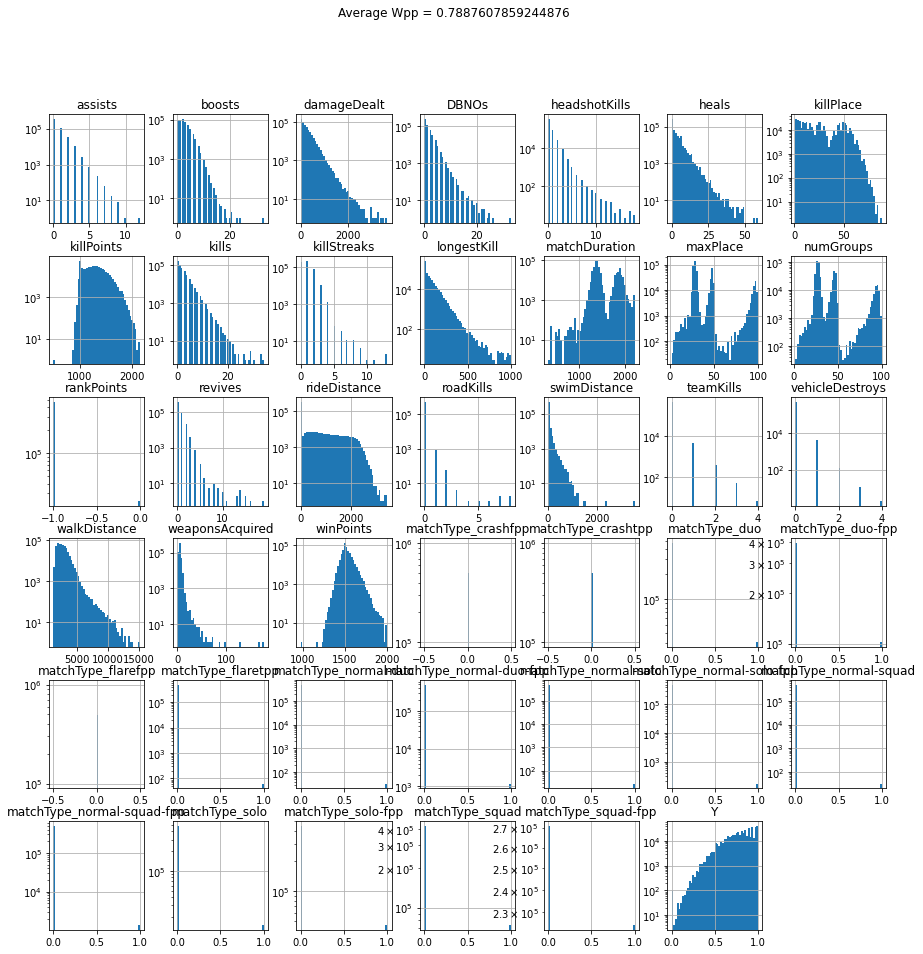

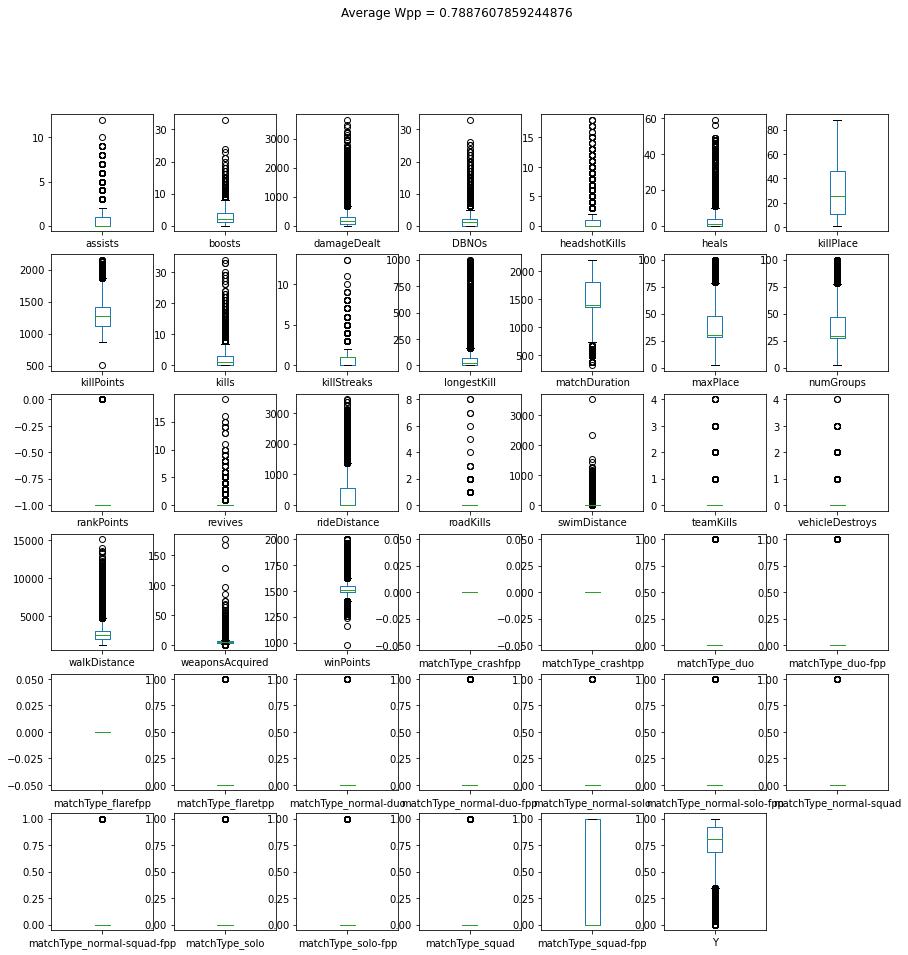

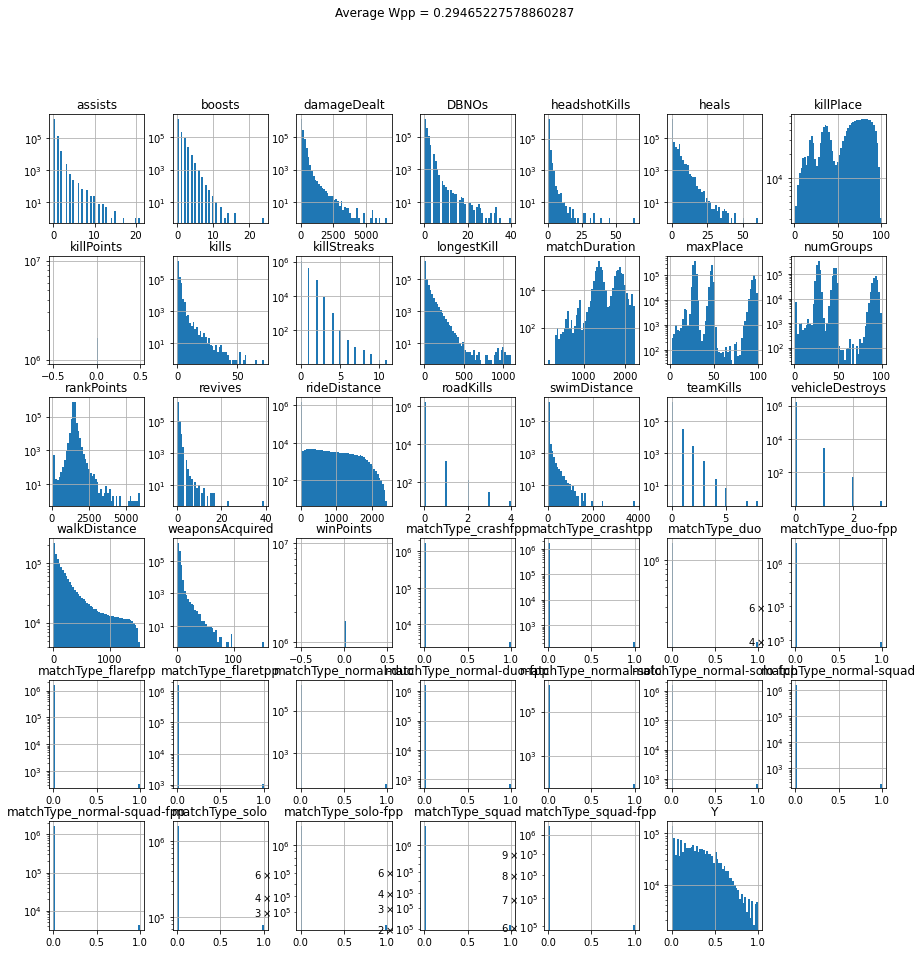

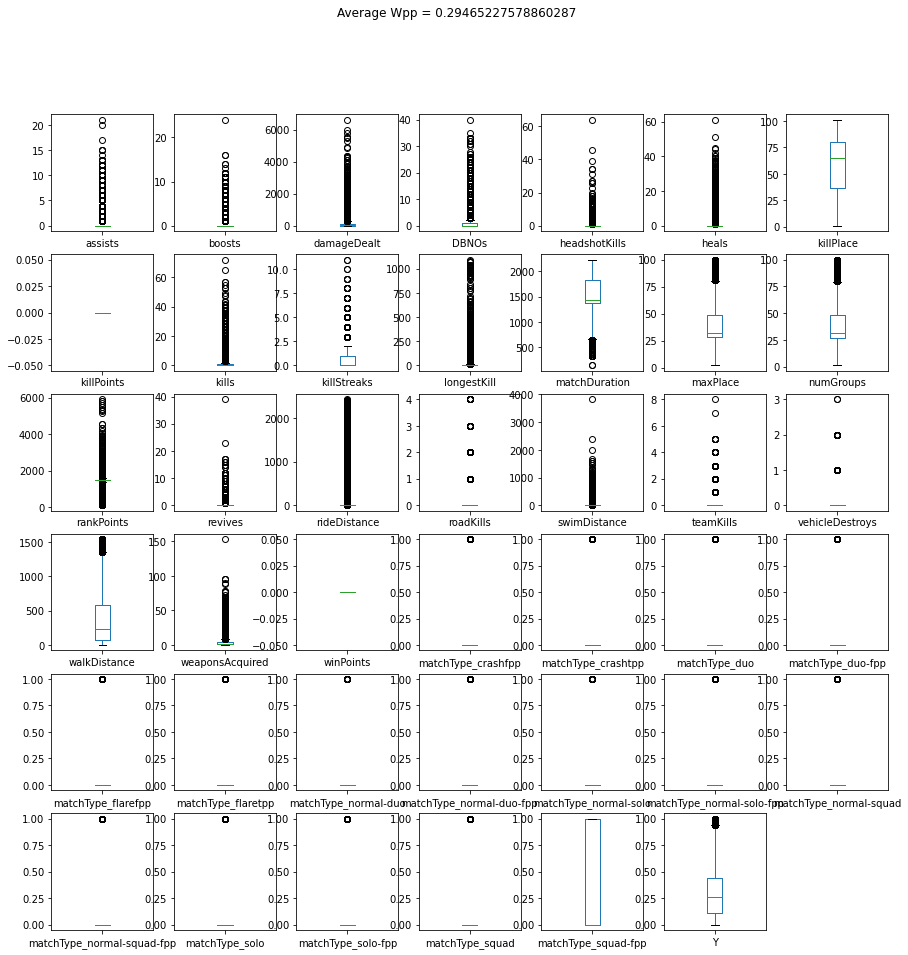

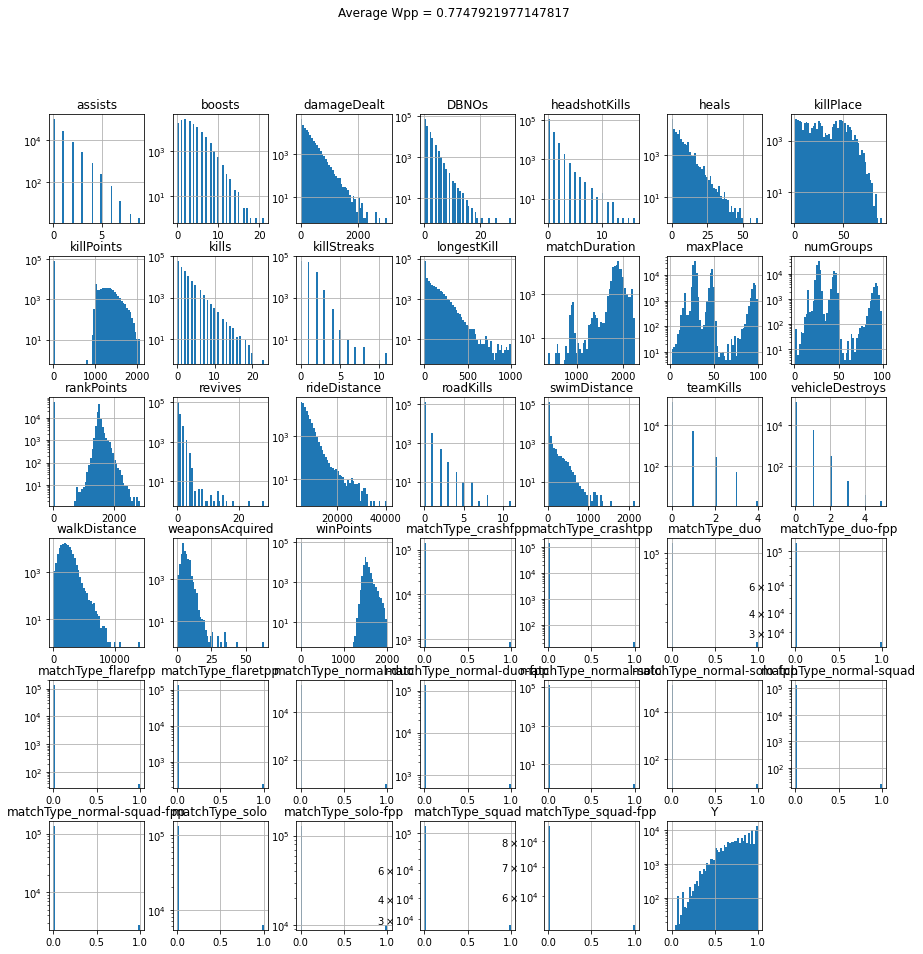

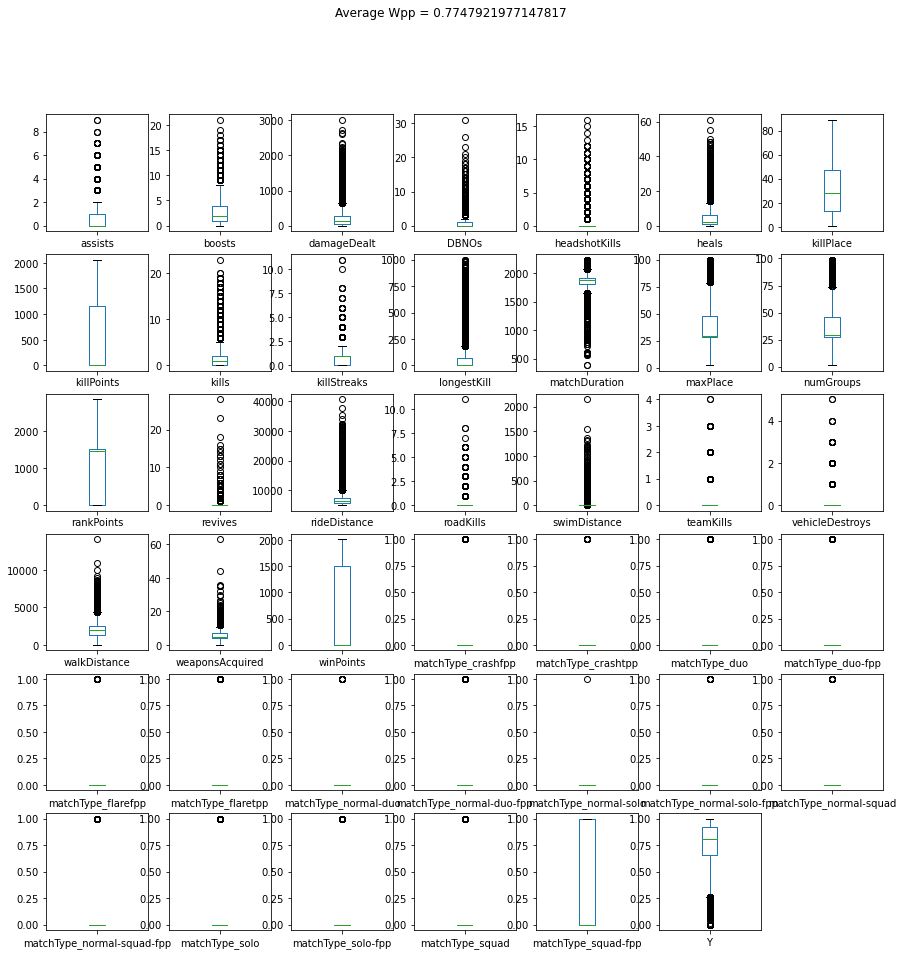

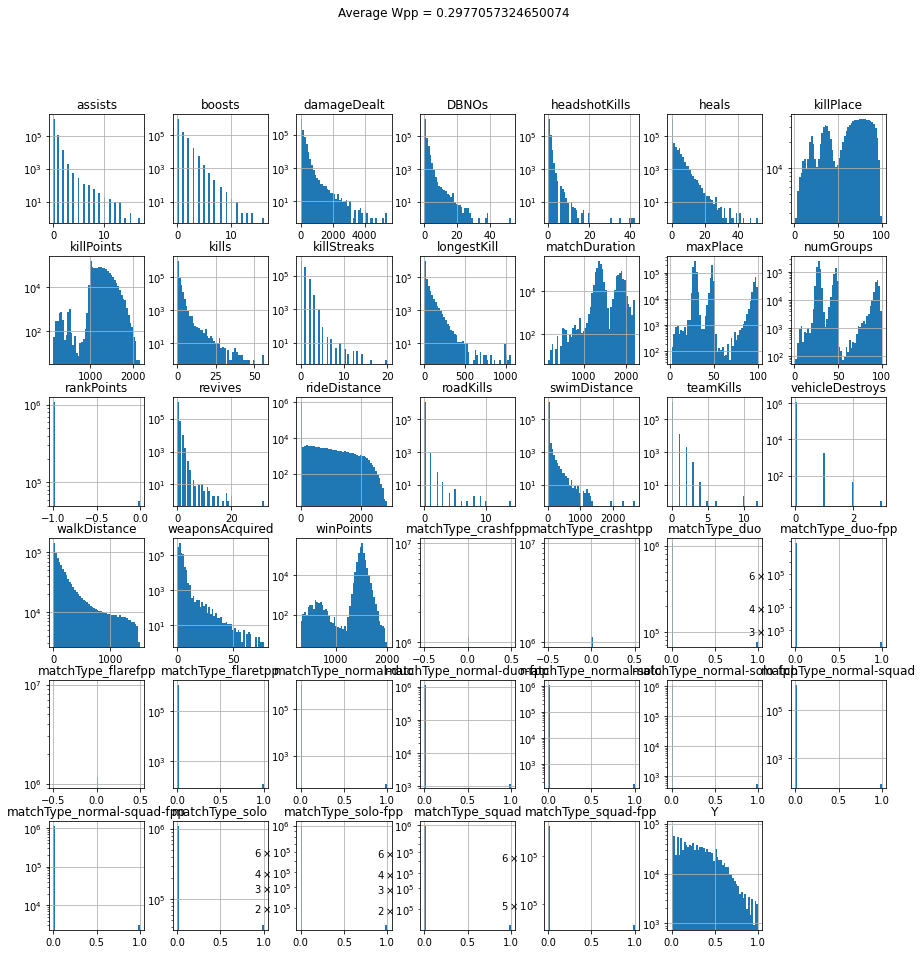

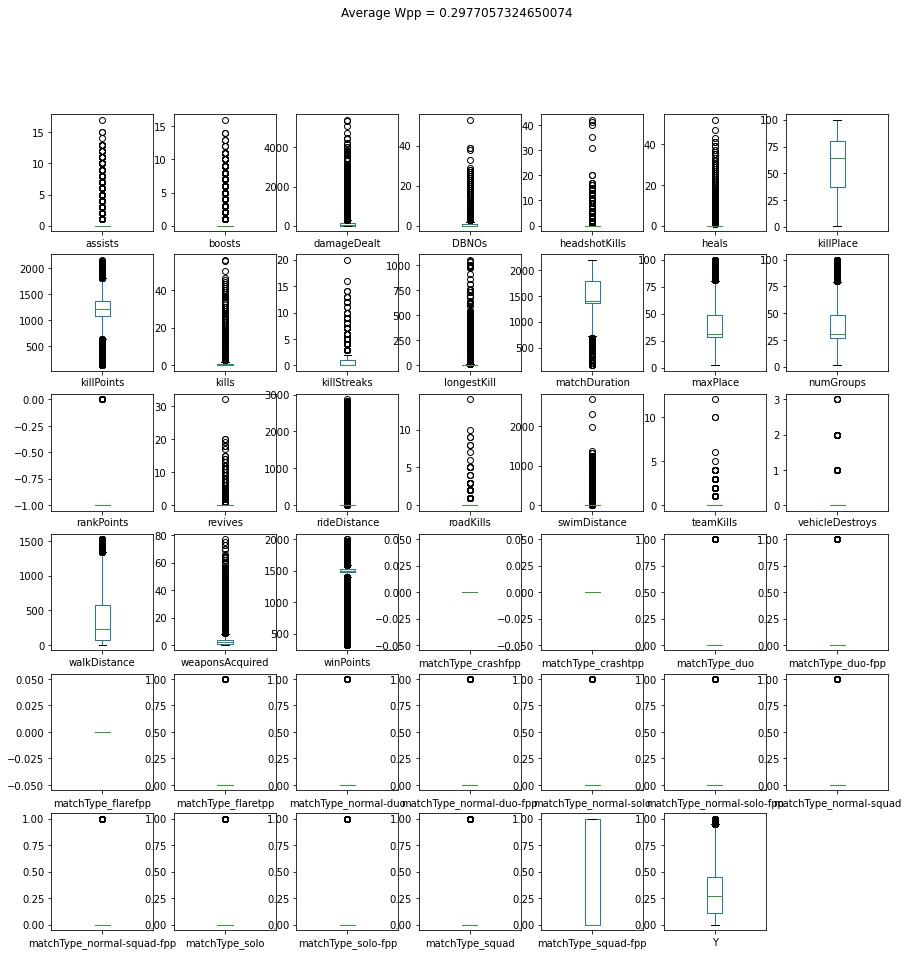

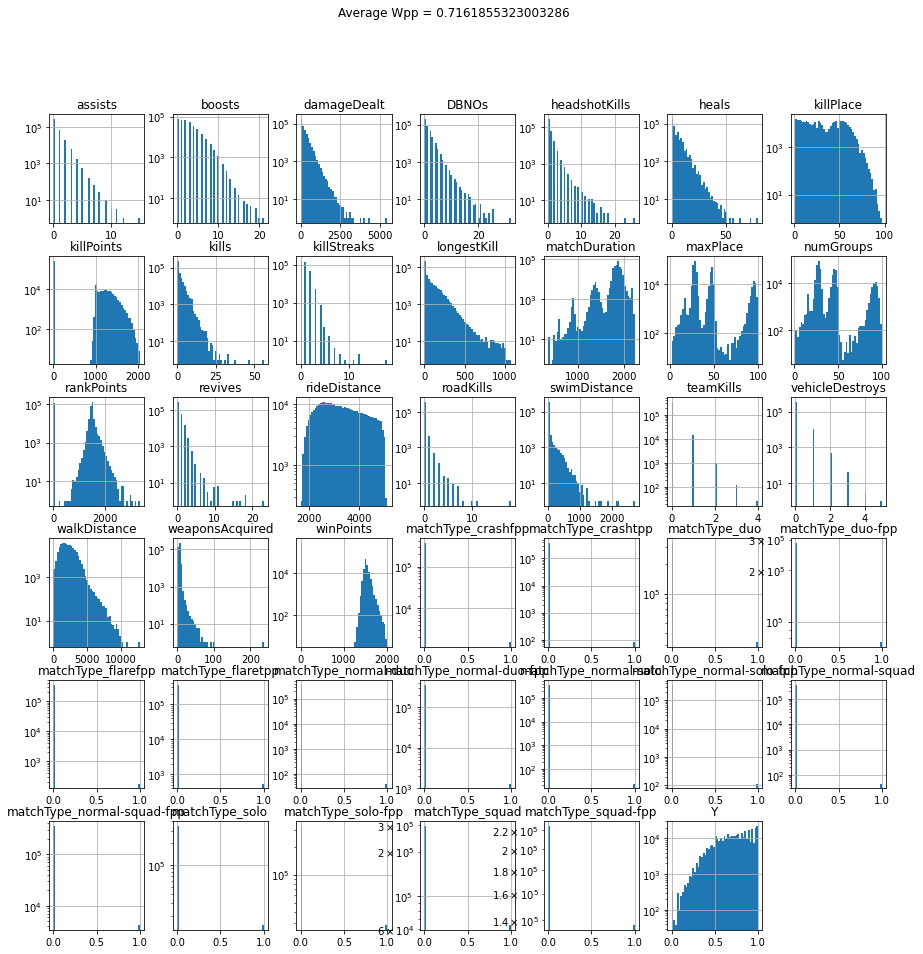

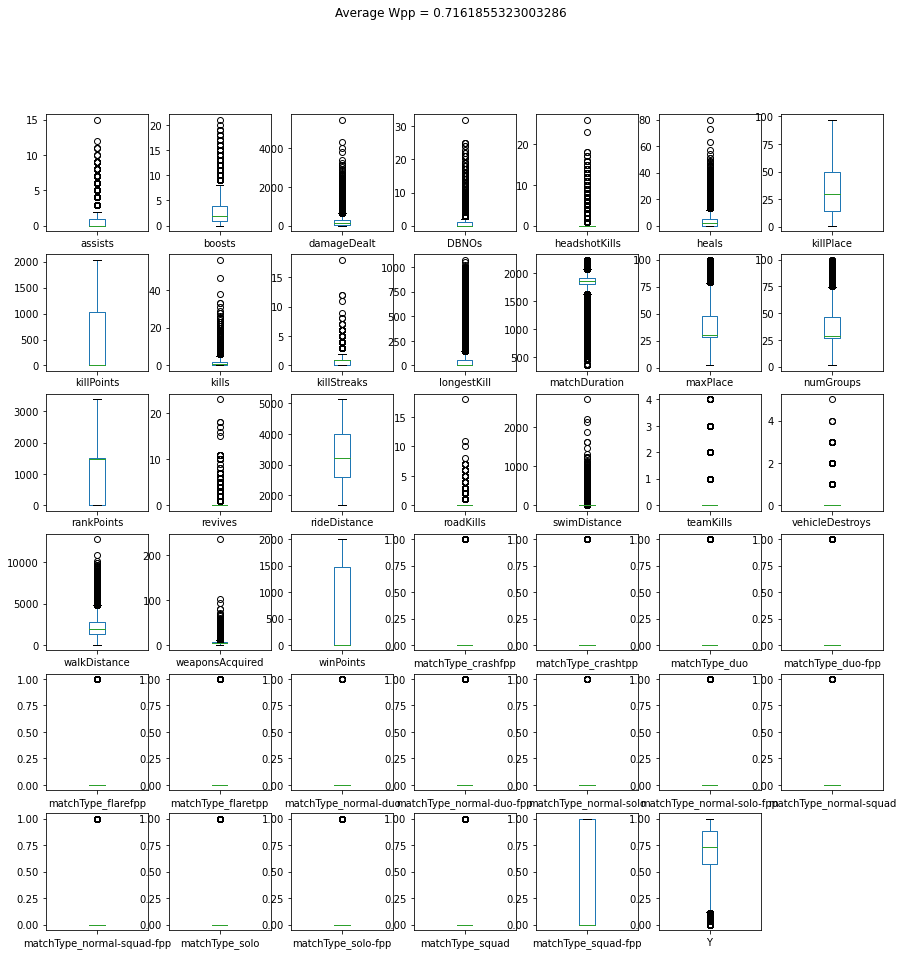

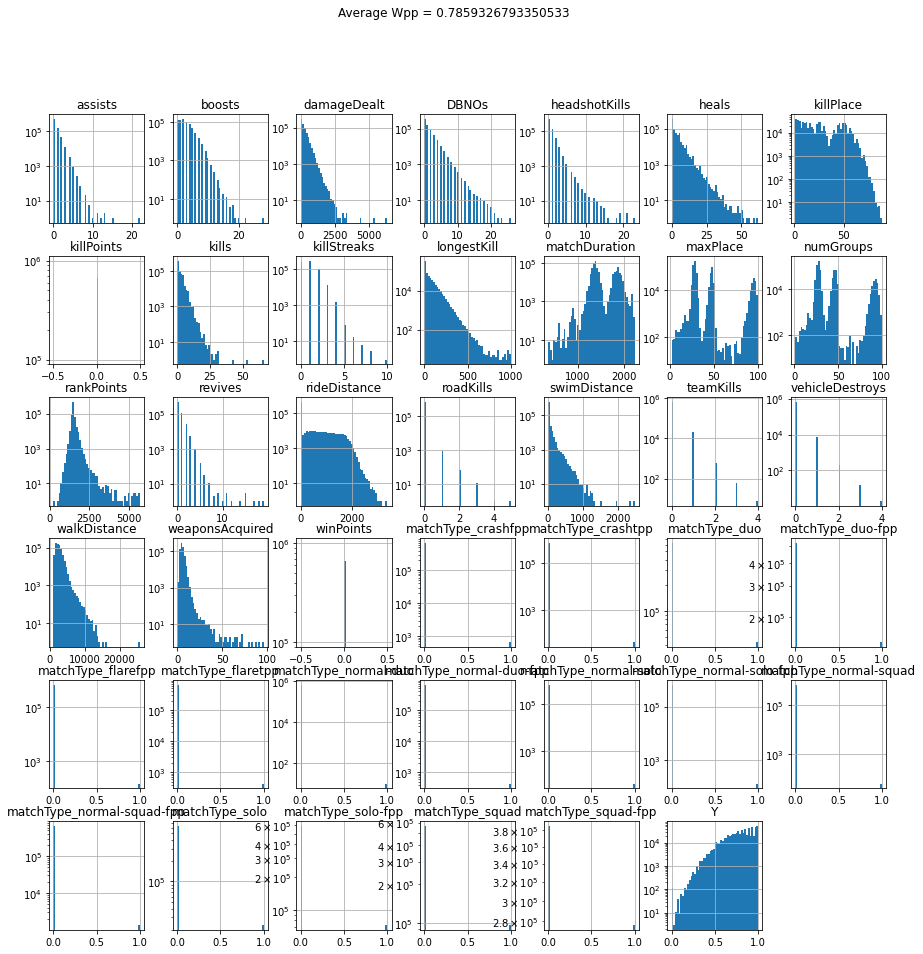

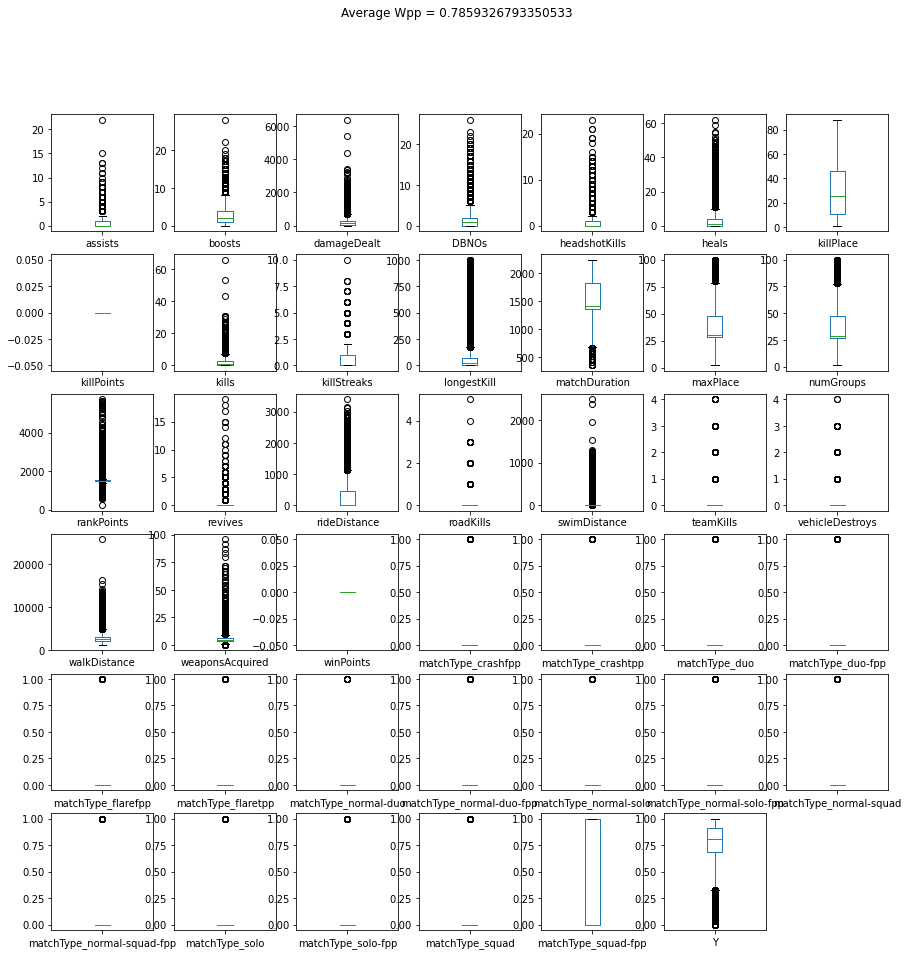

In [50]:
plot_distributions(X_train_temp,y_train_temp,6)

#### six clusters, "not that good"

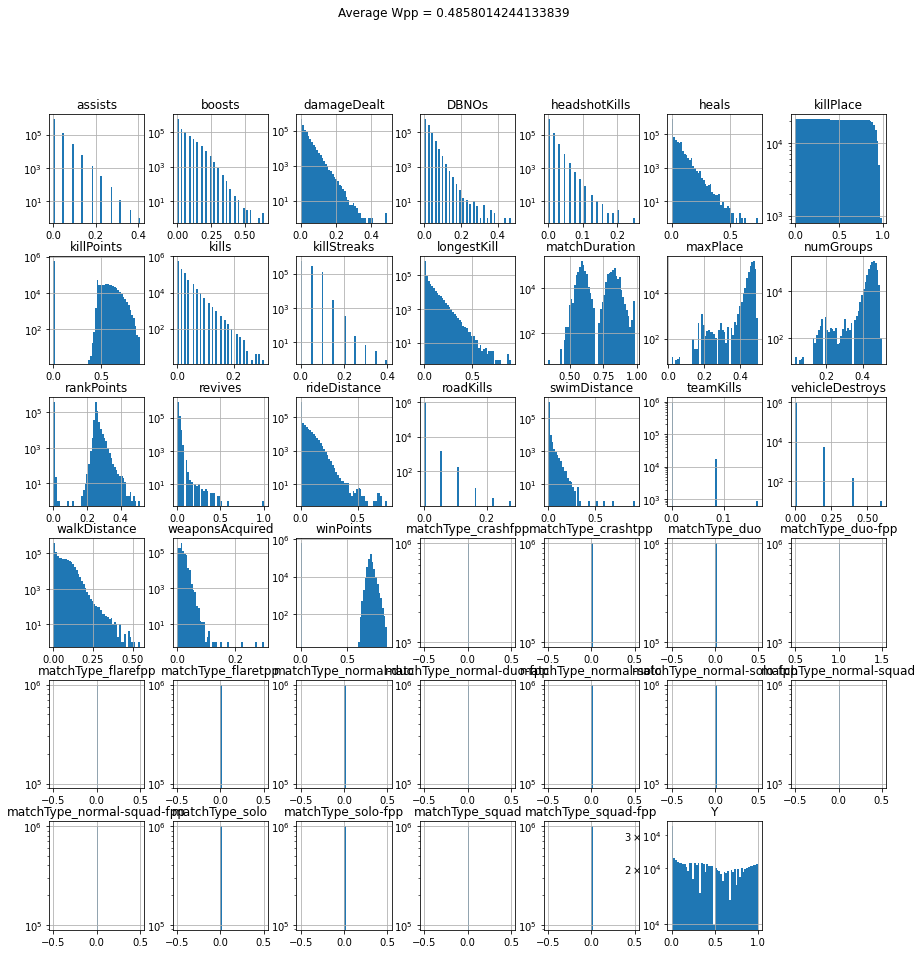

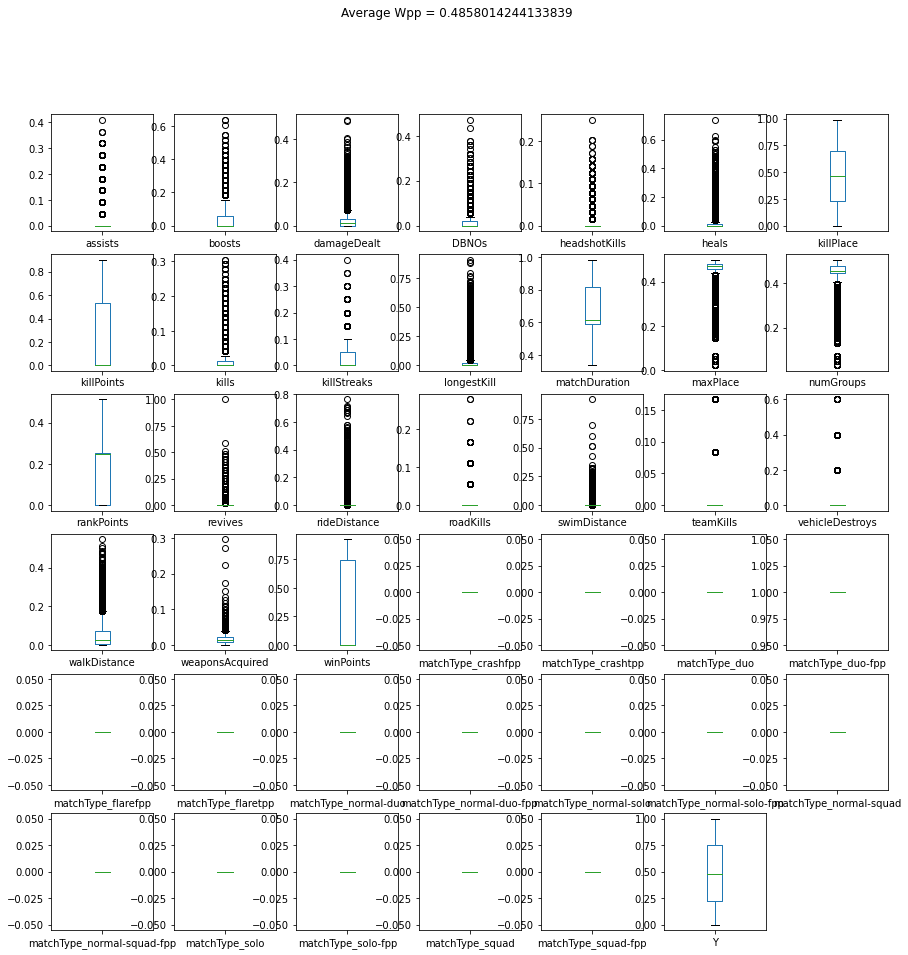

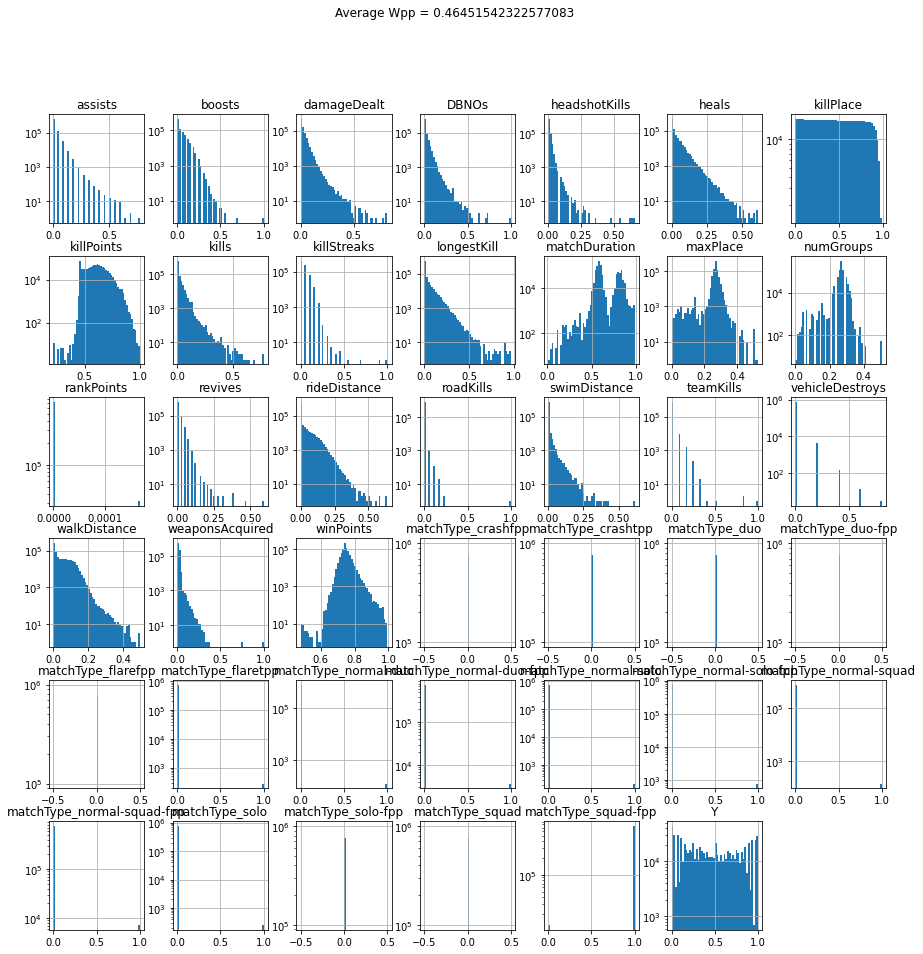

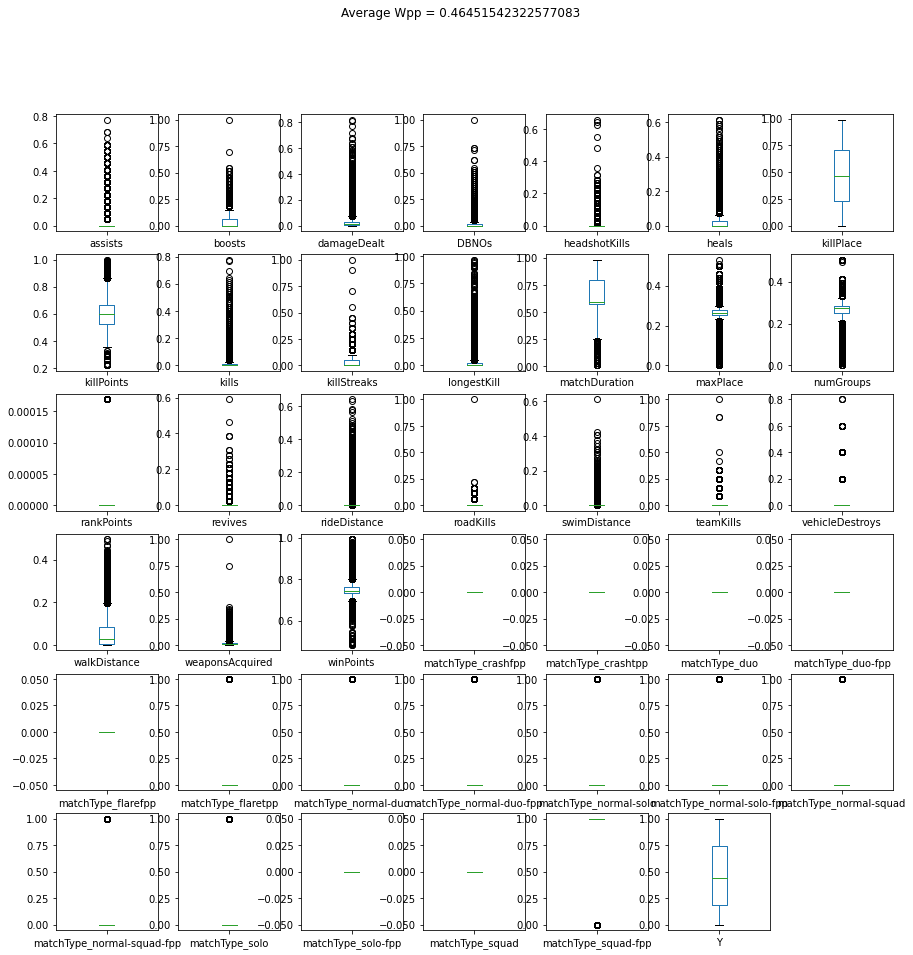

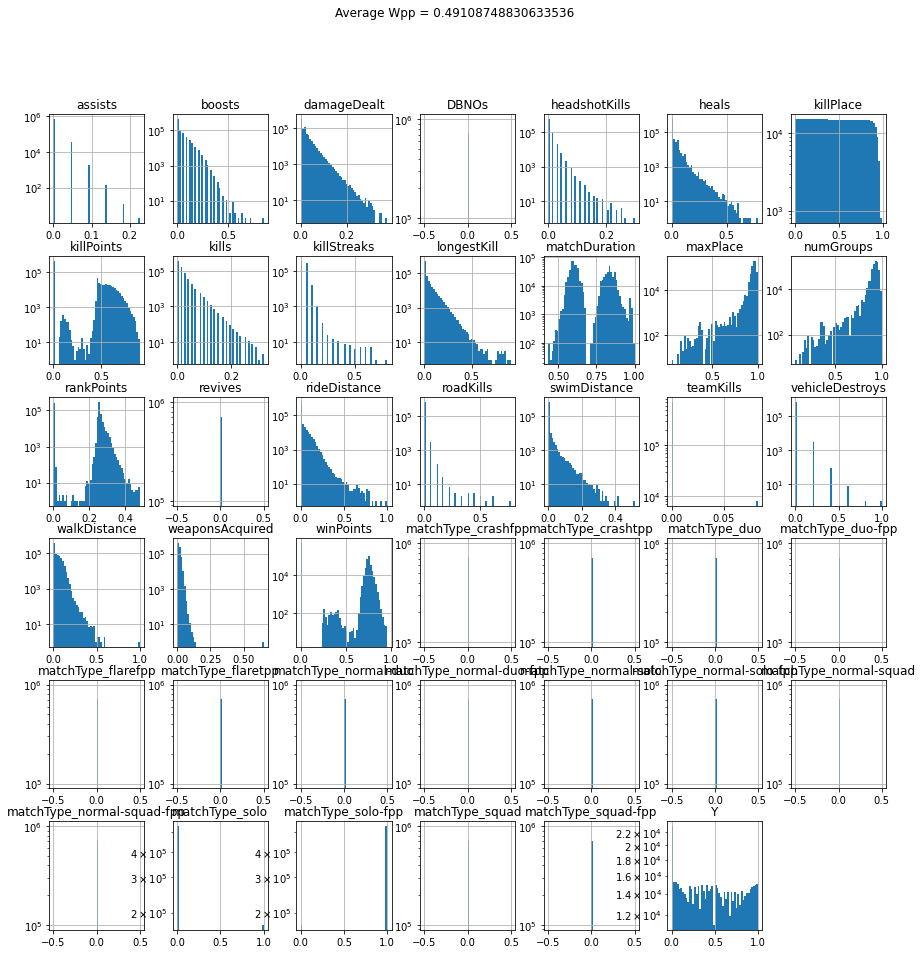

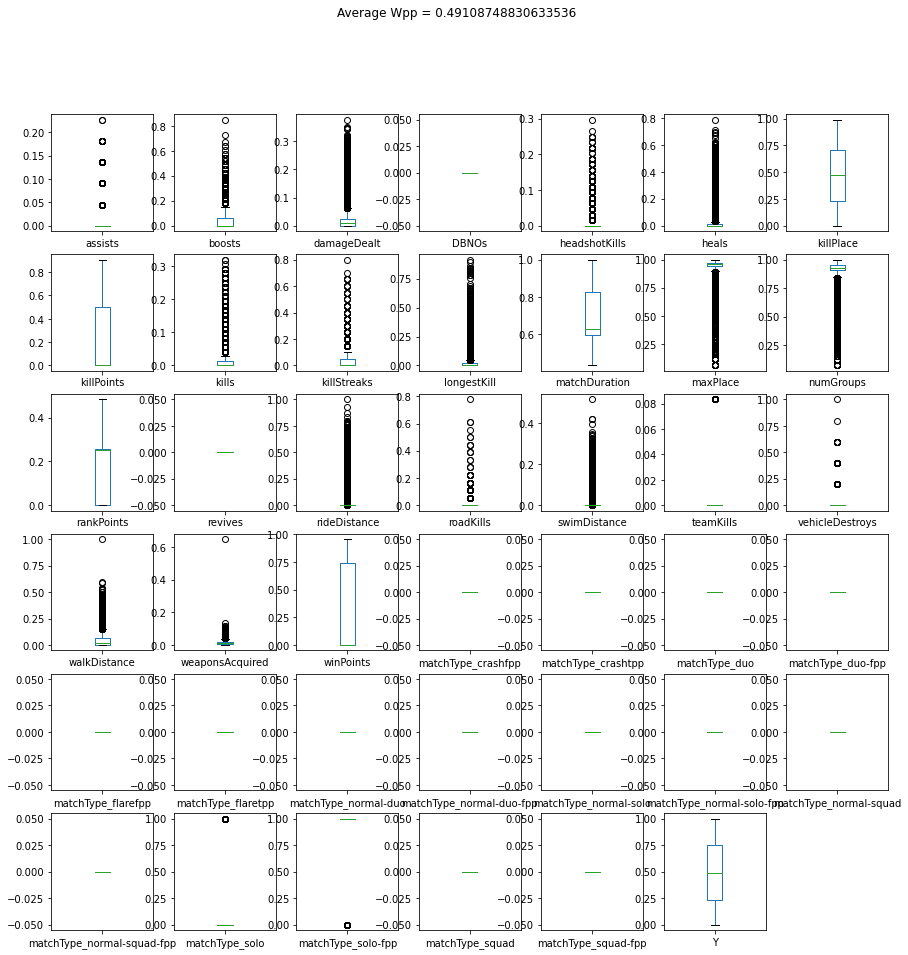

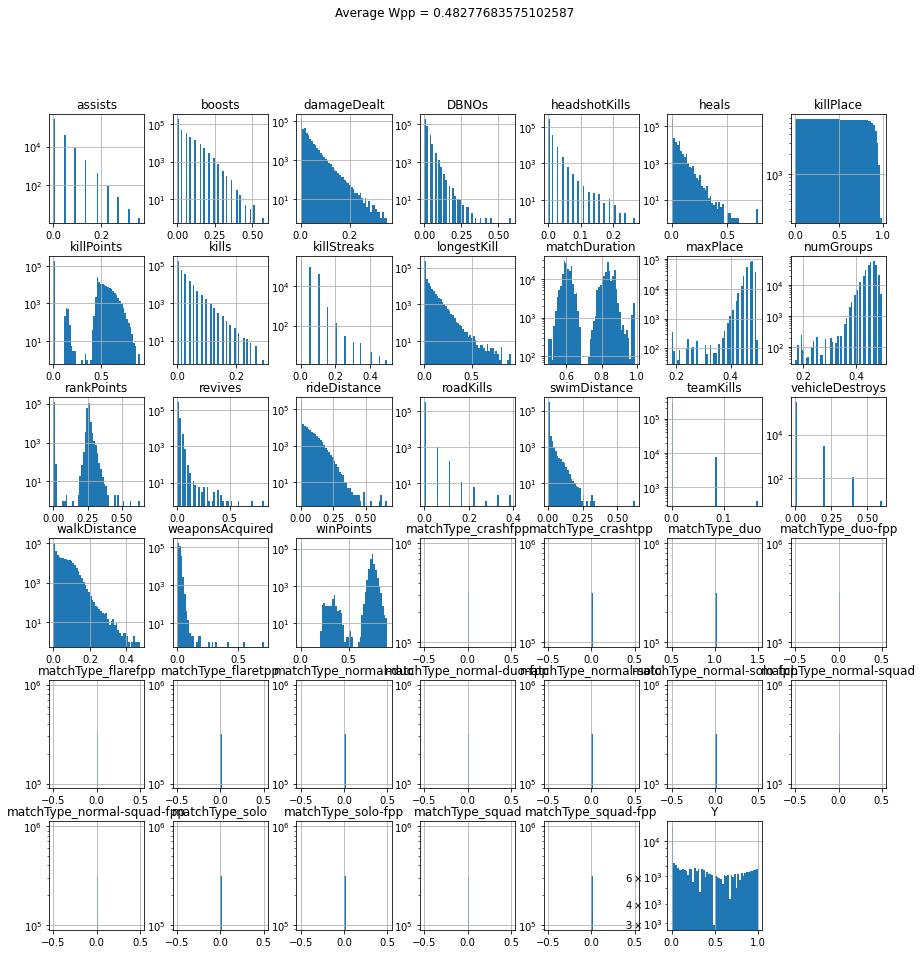

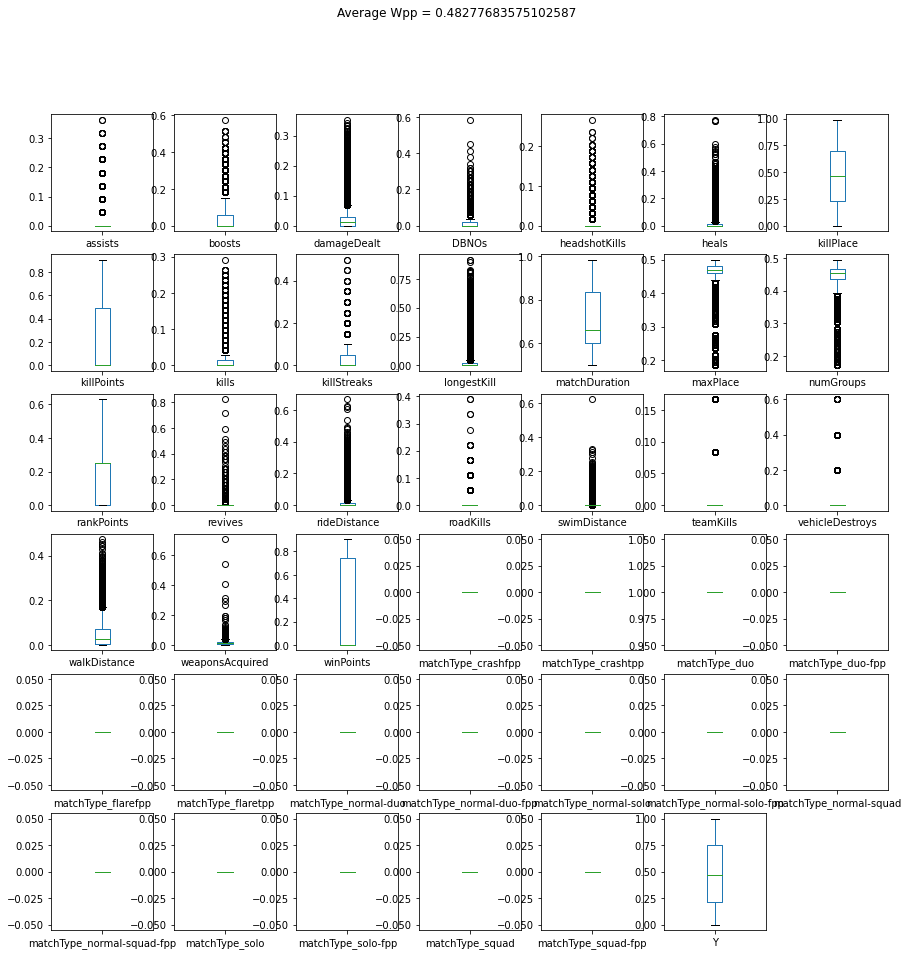

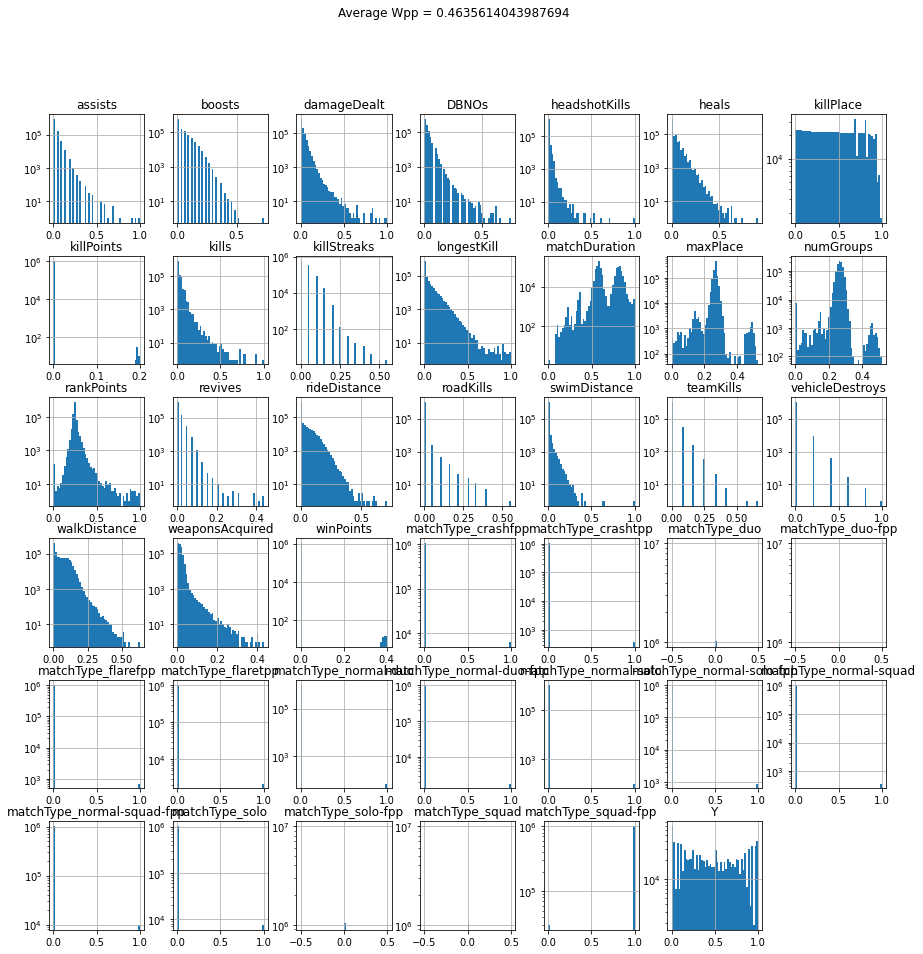

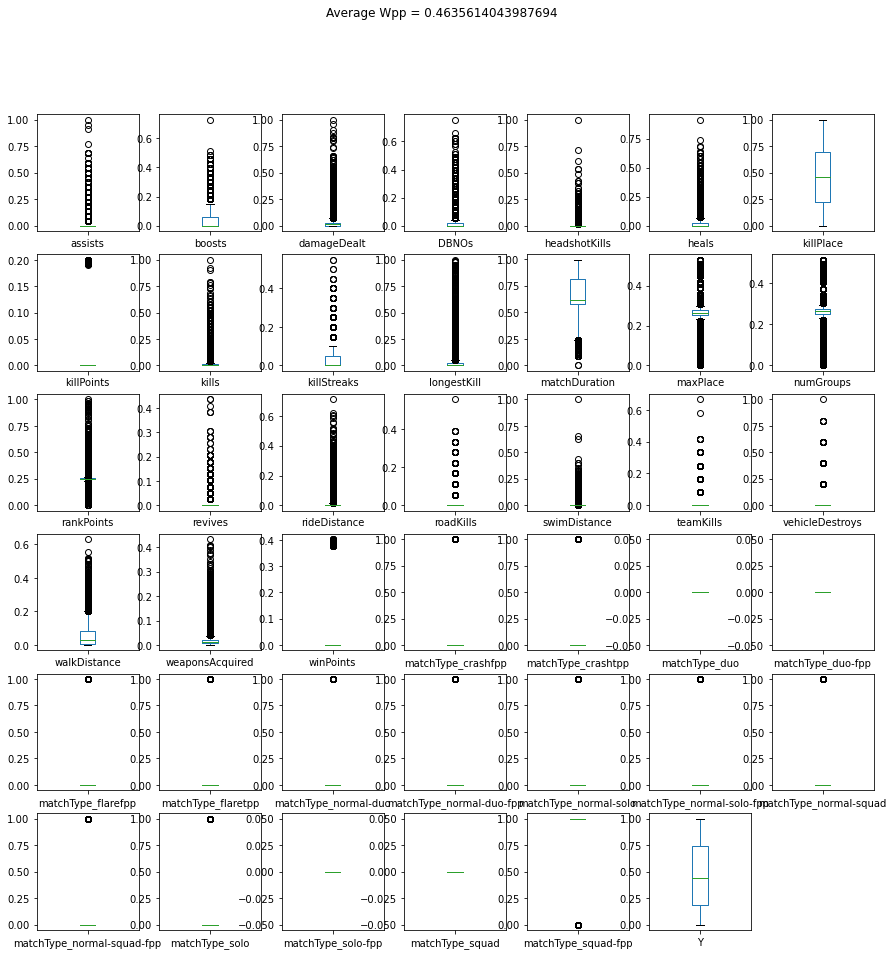

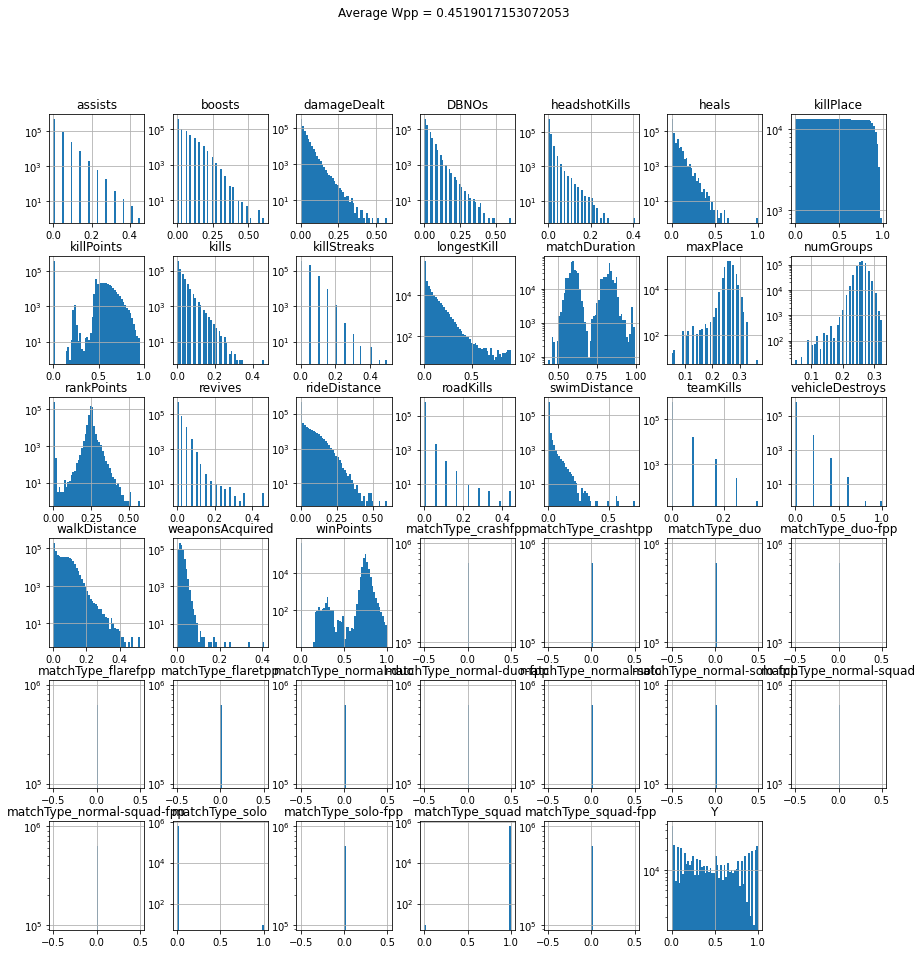

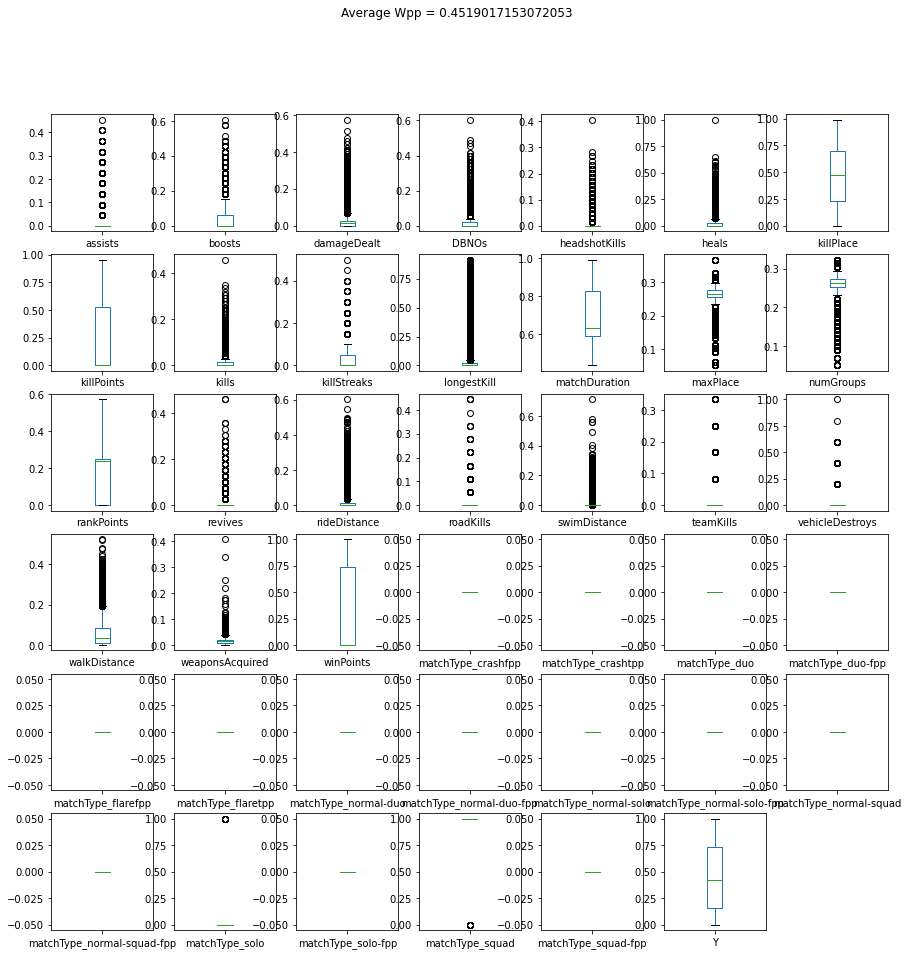

In [38]:
plot_distributions(X_train_temp,y_train_temp,kmeans,6)

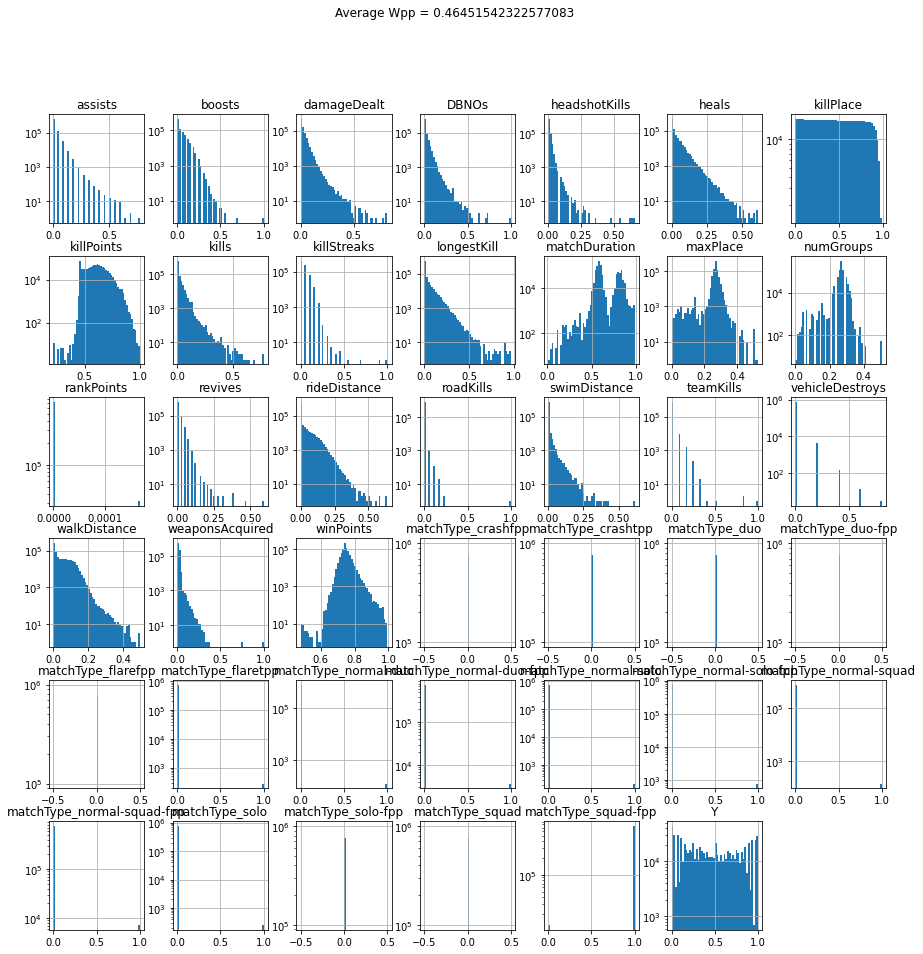

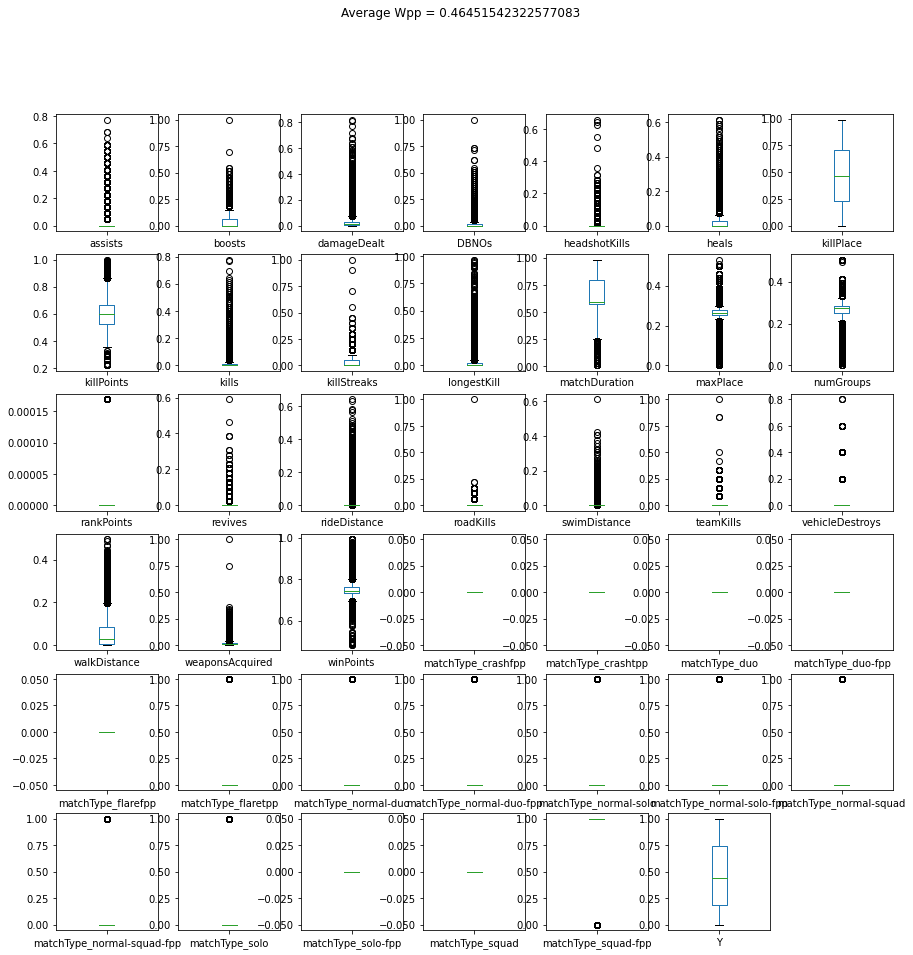

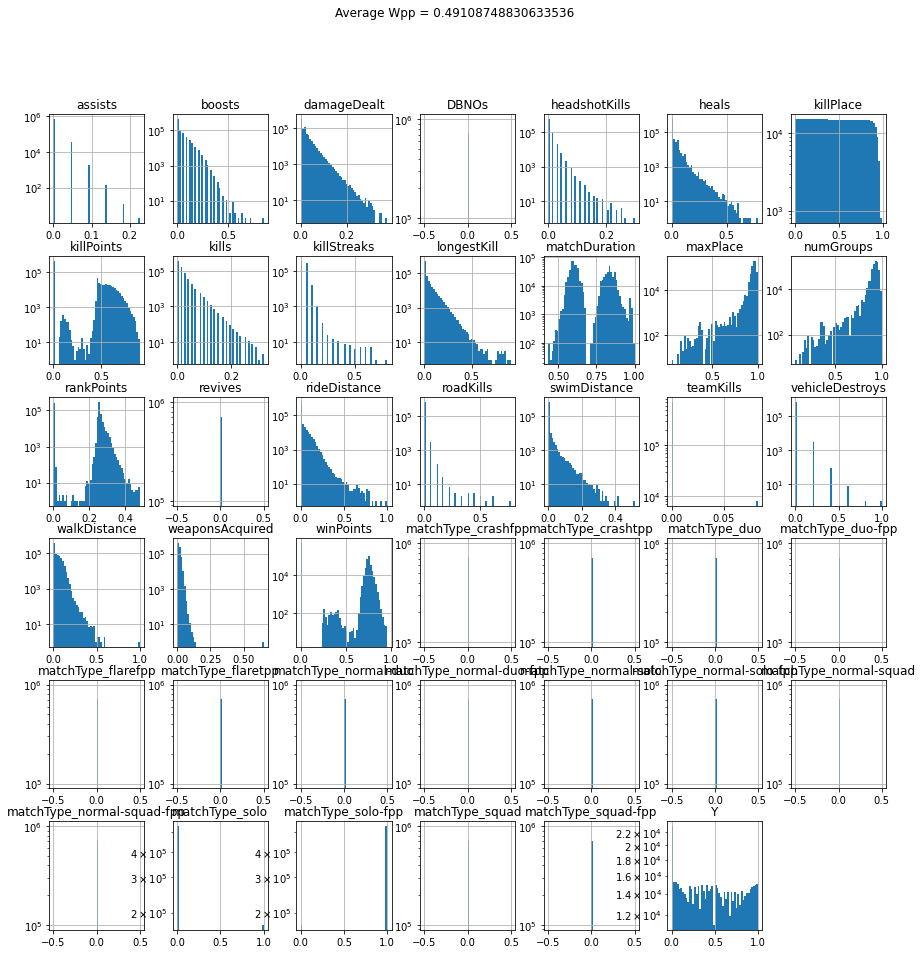

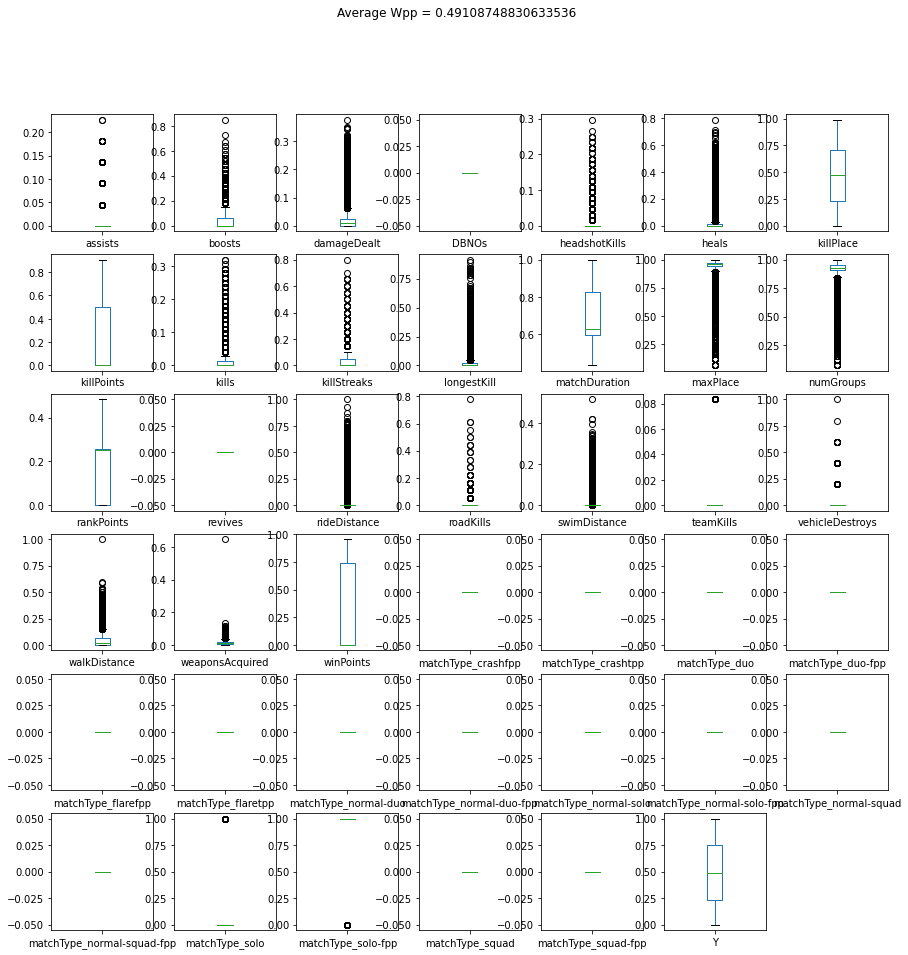

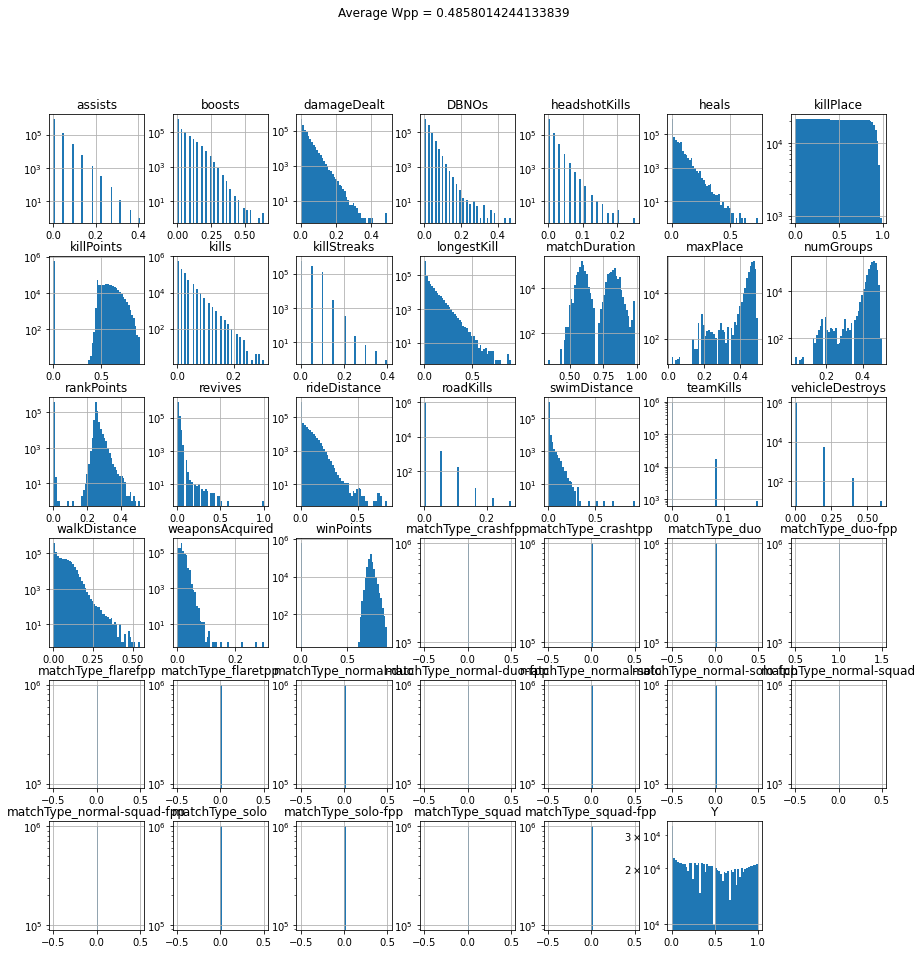

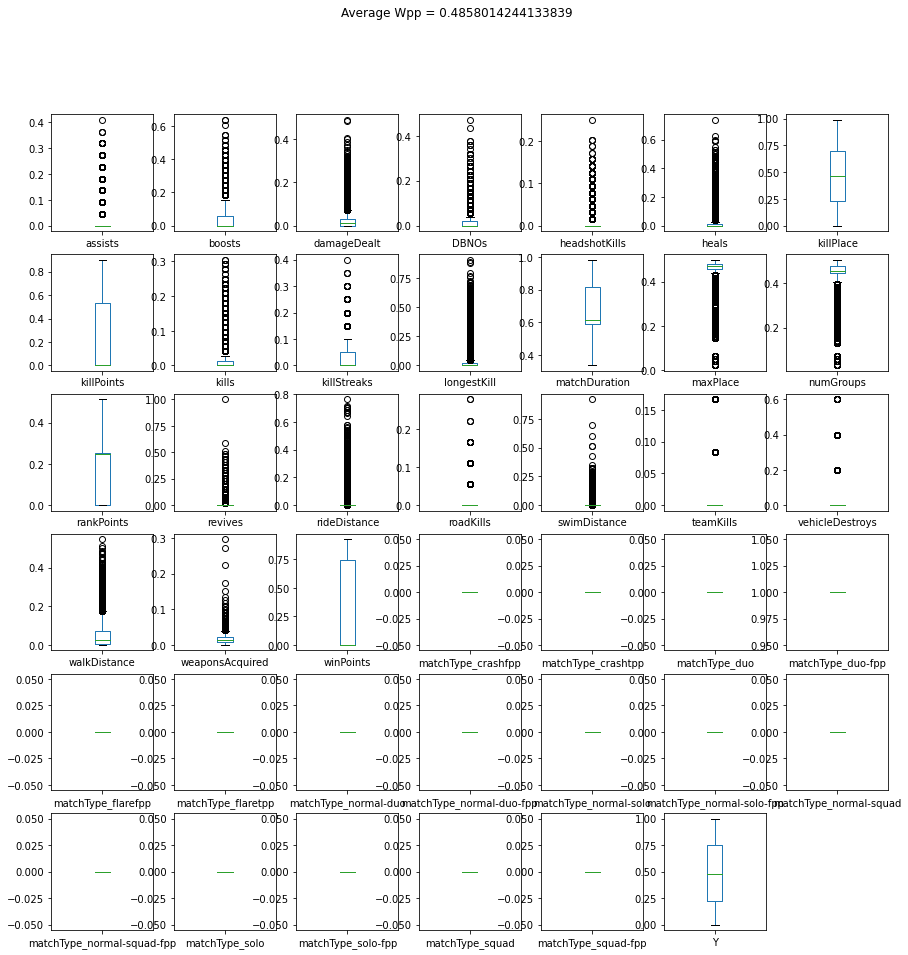

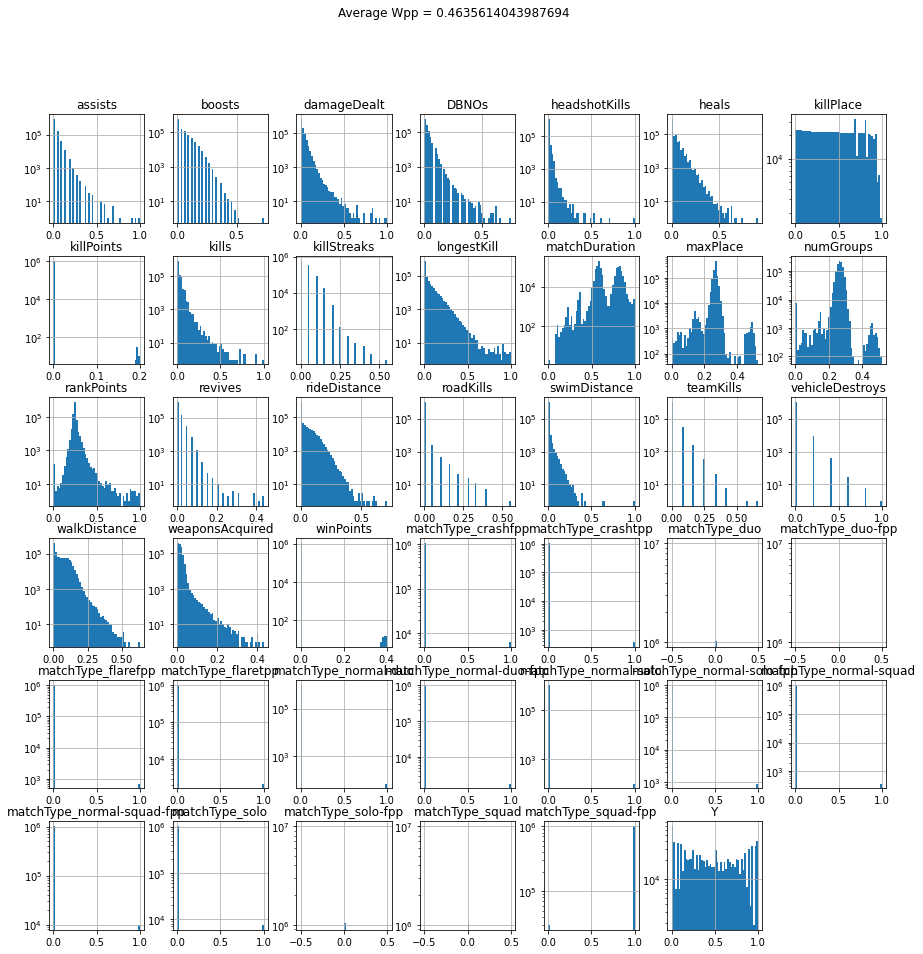

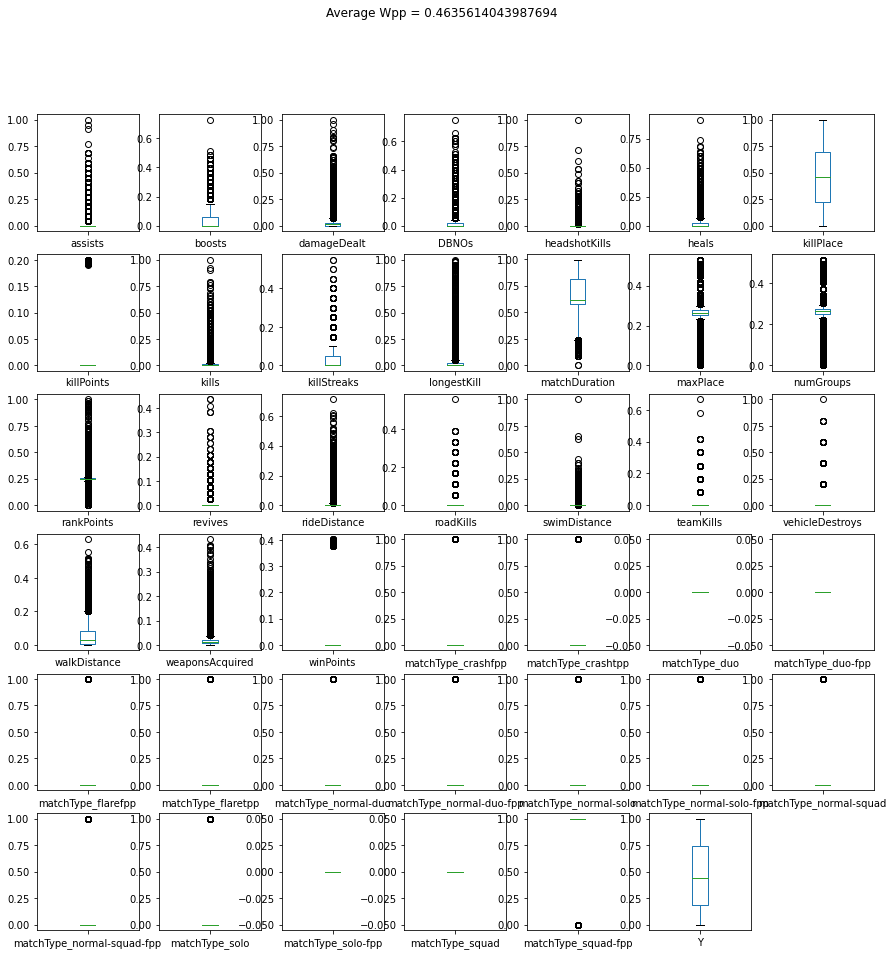

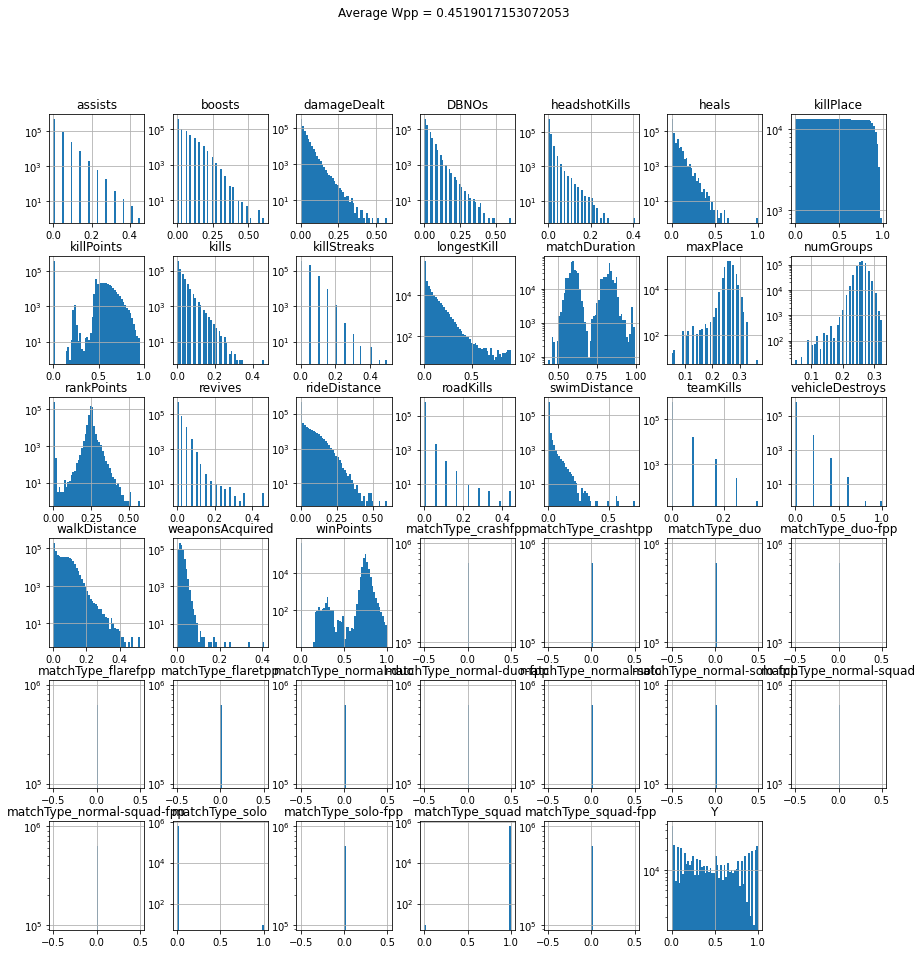

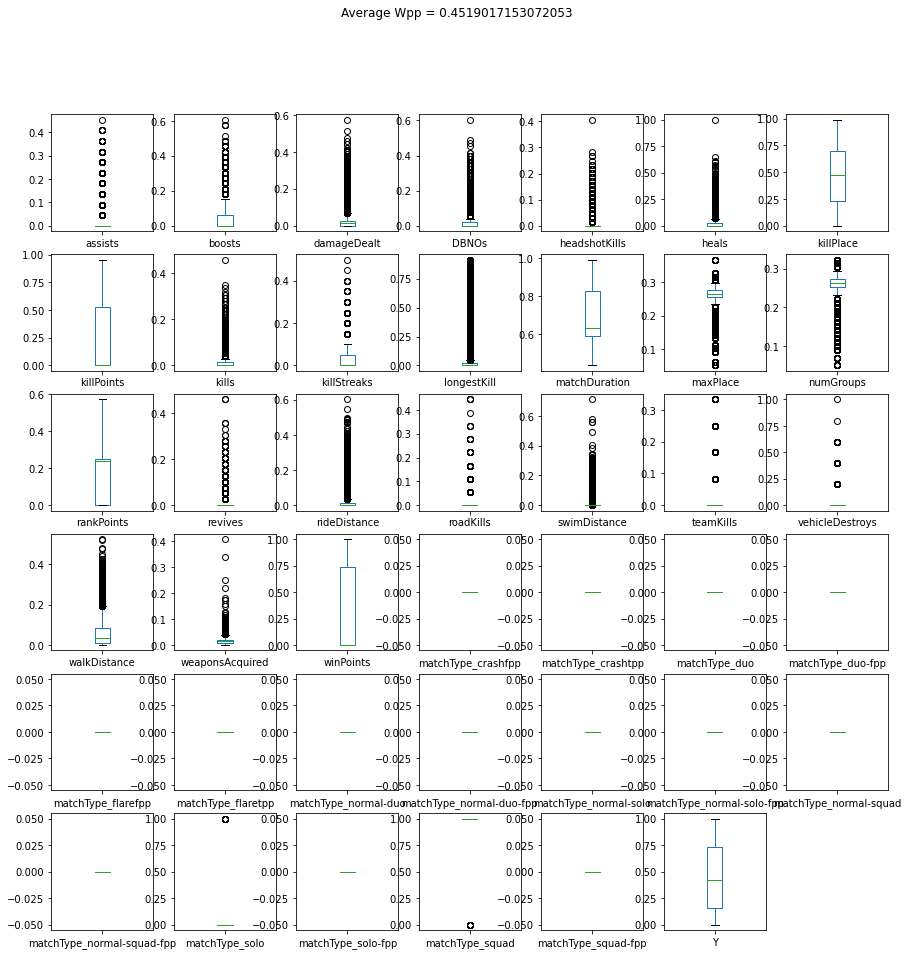

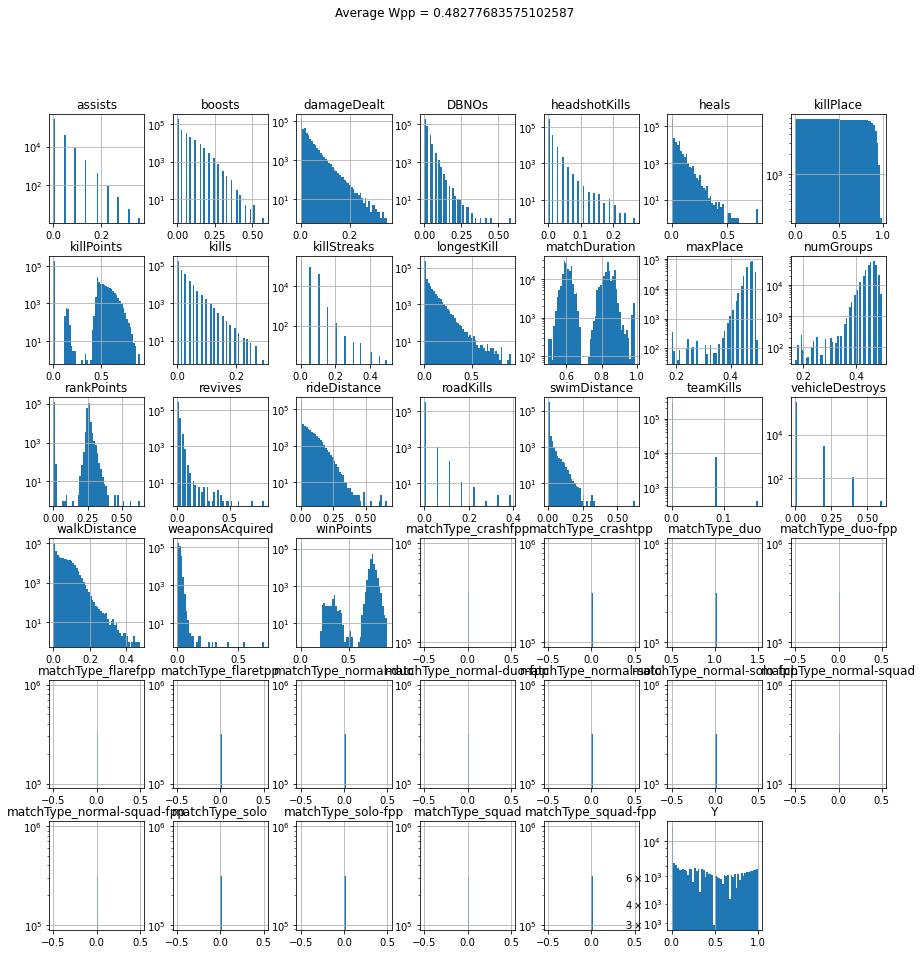

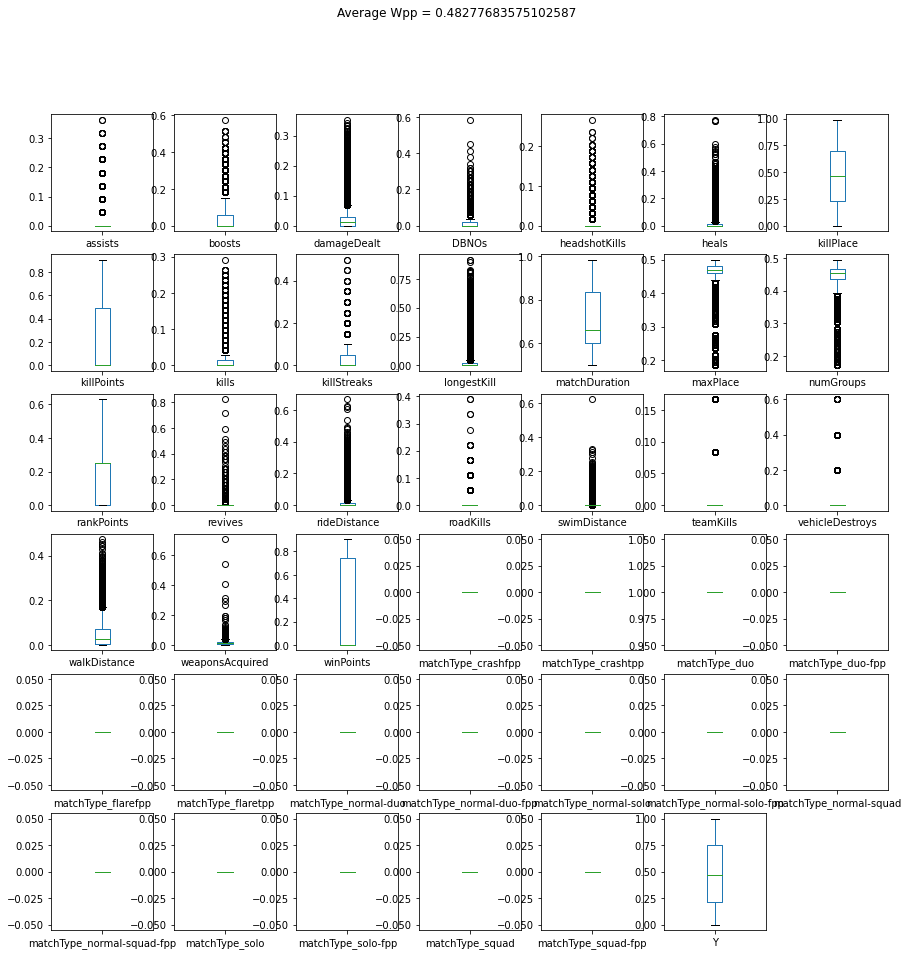

In [42]:
plot_distributions(X_train_temp,y_train_temp,kmeans,6)

##### Find the nearest points to the centroid 

In [241]:
def get_closest(X,kmeans,y_train_temp,n_clusters):
    y_train_temp = y_train_temp.copy()
    
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,n_clusters)
    y_train_temp = y_train_temp.drop(["cluster"],axis=1) 
    temp_train = pd.concat([X,y_train_temp],axis=1)
    closest_data = temp_train.loc[closest]
    closest_data["averageWpp"] = average_Wpp
    return closest_data

##### Find the centroids

In [99]:
def get_average(X,kmeans,n_clusters,y_train_temp):
    X = X.copy()
    centroids = kmeans.cluster_centers_
    for centroid in centroids:
        X.loc[len(X)]=centroid
    average_data = X.tail(n_clusters)
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,n_clusters)
    average_data["averageWpp"] = average_Wpp
    return average_data

In [258]:
closest_summary = get_closest(X_train_temp,kmeans,y_train_temp,17)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(closest_summary)

assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
4361509      0.0  0.030303     0.014034  0.000000       0.000000  0.0125   
1112883      0.0  0.060606     0.023277  0.018868       0.000000  0.0125   
3298012      0.0  0.000000     0.000000  0.000000       0.000000  0.0000   
814026       0.0  0.060606     0.005703  0.000000       0.000000  0.0000   
2102620      0.0  0.030303     0.017291  0.037736       0.015625  0.0125   
585988       0.0  0.030303     0.002786  0.000000       0.000000  0.0125   
4171785      0.0  0.030303     0.002096  0.000000       0.000000  0.0375   
2951195      0.0  0.000000     0.000000  0.000000       0.000000  0.0000   
1821551      0.0  0.000000     0.014411  0.000000       0.000000  0.0000   
2756219      0.0  0.030303     0.000000  0.000000       0.000000  0.0000   
3825073      0.0  0.060606     0.005387  0.000000       0.000000  0.0125   
4037541      0.0  0.030303     0.000000  0.000000       0.000000  0.0000   
3400389      0.0  0.000000     0.008189  0.000000       0.000000  0.0000   
549209       0.0  0.000000     0.002925  0.000000       0.000000  0.0000   
3058148      0.0  0.060606     0.028099  0.018868       0.000000  0.0125   
4170840      0.0  0.060606     0.023821  0.018868       0.000000  0.0375   
1267151      0.0  0.030303     0.026406  0.018868       0.000000  0.0125   

         killPlace  killPoints     kills  killStreaks  longestKill  \
4361509       0.49    0.000000  0.000000         0.00     0.000000   
1112883       0.22    0.000000  0.013889         0.05     0.020037   
3298012       0.69    0.000000  0.000000         0.00     0.000000   
814026        0.46    0.548848  0.000000         0.00     0.000000   
2102620       0.22    0.621659  0.027778         0.05     0.025503   
585988        0.46    0.000000  0.000000         0.00     0.000000   
4171785       0.45    0.560369  0.000000         0.00     0.000000   
2951195       0.71    0.000000  0.000000         0.00     0.000000   
1821551       0.46    0.523041  0.000000         0.00     0.000000   
2756219       0.45    0.000000  0.000000         0.00     0.000000   
3825073       0.47    0.538710  0.000000         0.00     0.000000   
4037541       0.47    0.587558  0.000000         0.00     0.000000   
3400389       0.70    0.000000  0.000000         0.00     0.000000   
549209        0.71    0.578341  0.000000         0.00     0.000000   
3058148       0.25    0.000000  0.013889         0.05     0.050521   
4170840       0.30    0.000000  0.000000         0.00     0.000000   
1267151       0.25    0.000000  0.013889         0.05     0.041152   

         matchDuration  maxPlace  numGroups  rankPoints   revives  \
4361509       0.668251  0.948980   0.929293    0.252918  0.000000   
1112883       0.674905  0.255102   0.262626    0.248858  0.025641   
3298012       0.681084  0.459184   0.444444    0.244629  0.000000   
814026        0.672053  0.265306   0.272727    0.000000  0.000000   
2102620       0.639259  0.275510   0.282828    0.000000  0.000000   
585988        0.761882  0.459184   0.434343    0.252918  0.000000   
4171785       0.673479  0.459184   0.454545    0.000000  0.000000   
2951195       0.719106  0.255102   0.262626    0.241583  0.000000   
1821551       0.653042  0.928571   0.909091    0.000000  0.000000   
2756219       0.773289  0.928571   0.888889    0.260870  0.000000   
3825073       0.667300  0.469388   0.444444    0.000000  0.000000   
4037541       0.670627  0.969388   0.949495    0.000000  0.000000   
3400389       0.678232  0.255102   0.262626    0.241922  0.000000   
549209        0.662548  0.285714   0.272727    0.000000  0.000000   
3058148       0.741445  0.265306   0.262626    0.243444  0.000000   
4170840       0.608840  0.112245   0.121212    0.253933  0.000000   
1267151       0.673954  0.448980   0.454545    0.258839  0.000000   

         rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
4361509      0.000000        0.0      0.000000        0.0 

In [259]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(get_average(X_train_temp,kmeans,17,y_train_temp))

assists    boosts  damageDealt         DBNOs  headshotKills  \
4446965  0.002454  0.032683     0.017895 -3.918740e-15       0.003970   
4446966  0.020507  0.057105     0.033747  2.979291e-02       0.006897   
4446967  0.003486  0.008715     0.005802  2.610617e-03       0.000008   
4446968  0.013771  0.035429     0.019930  1.608166e-02       0.003416   
4446969  0.021343  0.054247     0.034330  2.955366e-02       0.006943   
4446970  0.009278  0.034604     0.018765  1.154353e-02       0.003278   
4446971  0.010292  0.031593     0.020260  1.178398e-02       0.003521   
4446972  0.004714  0.011957     0.005301  3.107801e-03       0.000006   
4446973  0.003019  0.033471     0.017475 -8.274631e-16       0.003731   
4446974  0.002260  0.031675     0.016772  1.647987e-15       0.003370   
4446975  0.010418  0.033933     0.019626  1.148153e-02       0.003392   
4446976  0.002899  0.031095     0.018108  2.877906e-15       0.003865   
4446977  0.005004  0.011908     0.006302  3.457924e-03       0.000015   
4446978  0.005770  0.010931     0.006835  3.276618e-03       0.000012   
4446979  0.020899  0.059699     0.032503  2.925289e-02       0.006506   
4446980  0.039294  0.041054     0.047100  2.118642e-02       0.009568   
4446981  0.015591  0.058347     0.034019  2.133621e-02       0.007064   

            heals  killPlace    killPoints     kills  killStreaks  \
4446965  0.012891   0.468622  1.314227e-13  0.012978     0.024090   
4446966  0.030476   0.229241  8.121281e-14  0.025277     0.055734   
4446967  0.005786   0.699311  1.022793e-13  0.000032     0.000117   
4446968  0.018441   0.462483  5.688614e-01  0.012484     0.026782   
4446969  0.028091   0.231761  6.230377e-01  0.025364     0.056247   
4446970  0.016998   0.469458  9.448481e-04  0.012535     0.027102   
4446971  0.015887   0.468037  5.700422e-01  0.012894     0.028433   
4446972  0.007759   0.706682  2.239095e-03  0.000022     0.000080   
4446973  0.012703   0.457054  5.304623e-01  0.012788     0.023512   
4446974  0.012627   0.448918  8.120009e-04  0.011721     0.021404   
4446975  0.016315   0.455380  5.336754e-01  0.012734     0.027523   
4446976  0.012168   0.473041  5.682800e-01  0.012990     0.024178   
4446977  0.007946   0.702682  1.532289e-05  0.000053     0.000190   
4446978  0.007068   0.709700  5.821703e-01  0.000042     0.000153   
4446979  0.030585   0.231435 -3.474998e-14  0.024685     0.053232   
4446980  0.029729   0.303645  1.636826e-01  0.035691     0.040951   
4446981  0.028525   0.228123  9.806045e-14  0.025827     0.056820   

         longestKill  matchDuration  maxPlace  numGroups  rankPoints  \
4446965     0.020090       0.690517  0.946168   0.922381    0.260418   
4446966     0.044113       0.686135  0.266090   0.263788    0.250957   
4446967     0.000026       0.695455  0.466756   0.454081    0.254836   
4446968     0.022020       0.690352  0.261793   0.258754    0.000007   
4446969     0.041245       0.661608  0.269233   0.267327    0.000007   
4446970     0.020435       0.728070  0.468701   0.453501    0.253202   
4446971     0.019869       0.673049  0.467522   0.457131    0.000008   
4446972     0.000013       0.706035  0.261839   0.259879    0.244525   
4446973     0.019351       0.714059  0.932836   0.893297    0.000013   
4446974     0.018691       0.744260  0.900312   0.859937    0.256243   
4446975     0.020086       0.705340  0.462070   0.444997    0.000010   
4446976     0.019411       0.679390  0.955187   0.932762    0.000013   
4446977     0.000038       0.684998  0.267122   0.264897    0.247168   
4446978     0.000030       0.657566  0.270534   0.268667    0.000007   
4446979     0.043954       0.707764  0.261114   0.259204    0.250911   
4446980     0.039313       0.616166  0.211897   0.209100    0.163744   
4446981     0.041921       0.696894  0.464998   0.452275    0.257620   

              revives  rideDistance     roadKills  swimDistance  teamKills  \
4446965 -1.329666e-15      0.010128  1.923281e-04      0.001291   0.001047   

### Cluster Analysis For Each Match Type

In [188]:
matchType_crashfpp=train[train['matchType']=='crashfpp']
matchType_crashtpp=train[train['matchType']=='crashtpp']
matchType_duo=train[train['matchType']=='duo']
matchType_duo_fpp=train[train['matchType']=='duo-fpp']
matchType_flarefpp=train[train['matchType']=='flarefpp']
matchType_flaretpp=train[train['matchType']=='flaretpp']
matchType_normal_duo=train[train['matchType']=='normal-duo']
matchType_normal_duo_fpp=train[train['matchType']=='normal-duo-fpp']
matchType_normal_solo=train[train['matchType']=='normal-solo']
matchType_normal_solo_fpp=train[train['matchType']=='normal-solo-fpp']
matchType_normal_squad=train[train['matchType']=='normal-squad']
matchType_normal_squad_fpp=train[train['matchType']=='normal-squad-fpp']
matchType_solo=train[train['matchType']=='solo']
matchType_solo_fpp=train[train['matchType']=='solo-fpp']
matchType_squad=train[train['matchType']=='squad']
matchType_squad_fpp=train[train['matchType']=='squad-fpp']

In [247]:
allTypes = [matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo_fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal_duo,matchType_normal_duo_fpp,matchType_normal_solo,matchType_normal_solo_fpp,matchType_normal_squad,matchType_normal_squad_fpp,matchType_solo,matchType_solo_fpp,matchType_squad,matchType_squad_fpp]
names = ["crashfpp","crashtpp","duo","duo_fpp","flarefpp","flaretpp","normal_duo","normal_duo_fpp","normal_solo","normal_solo_fpp","normal_squad","normal_squad_fpp","solo","solo_fpp","squad","squad_fpp"]

In [248]:
for index in range(len(allTypes)):
    allTypes[index] = allTypes[index].reset_index(drop=True)

In [201]:
kmeans = KMeans(random_state=0)

#### View the best number of clusters

n_clusters:  2 ,Score:  8671.747543226787 ,Average WPP:  [0.6509074186682882, 0.2814120080053369]
n_clusters:  3 ,Score:  7349.923338726254 ,Average WPP:  [0.7057865871121718, 0.5309915284625728, 0.16381575726670067]
n_clusters:  4 ,Score:  5987.304389933077 ,Average WPP:  [0.7068755604155276, 0.5318276126558007, 0.15597064413938752, 0.60006589958159]
n_clusters:  5 ,Score:  5503.748570734683 ,Average WPP:  [0.7461607575757575, 0.5947939100346021, 0.11270614449696151, 0.5574489878542511, 0.451067032967033]
n_clusters:  6 ,Score:  5174.62644207231 ,Average WPP:  [0.1062804516584333, 0.7284614506927466, 0.5877143165467626, 0.42227804214819853, 0.8122152777777778, 0.5426603238866398]
n_clusters:  7 ,Score:  4888.070323206304 ,Average WPP:  [0.6374676100628931, 0.811405035971223, 0.10610909732016924, 0.586717441860465, 0.4517496703296703, 0.7275145559210526, 0.3074066455696203]
n_clusters:  8 ,Score:  4780.502271214008 ,Average WPP:  [0.32623773747841106, 0.522420988725065, 0.7524466042154

n_clusters:  2 ,Score:  2448.631125549769 ,Average WPP:  [0.4345421431787483, 0.4349760563380282]
n_clusters:  3 ,Score:  4235.928724452476 ,Average WPP:  [0.2408252268602541, 0.6253160857908847, 0.4349760563380282]
n_clusters:  4 ,Score:  4065.6370741470073 ,Average WPP:  [0.13234201570680626, 0.6992320950965825, 0.4349760563380282, 0.5018183673469389]
n_clusters:  5 ,Score:  3717.1578034177887 ,Average WPP:  [0.13234201570680626, 0.6992320950965825, 0.583208904109589, 0.5018183673469389, 0.27815]
n_clusters:  6 ,Score:  3522.0420871051674 ,Average WPP:  [0.10618742424242424, 0.4525469111969112, 0.583208904109589, 0.5245916256157636, 0.27815, 0.7860341013824883]
n_clusters:  7 ,Score:  3276.877998330792 ,Average WPP:  [0.06286973094170403, 0.4172489539748954, 0.583208904109589, 0.2767777041942605, 0.27815, 0.7977825552825554, 0.6580215102974828]
n_clusters:  8 ,Score:  3029.1729156746846 ,Average WPP:  [0.2770691629955947, 0.5916312056737589, 0.3243996932515337, 0.6660899521531102, 0.

n_clusters:  7 ,Score:  423.00336306524696 ,Average WPP:  [0.48596699029126206, 0.5307504672897196, 0.5581594594594594, 0.5582684210526315, 0.7616878787878788, 0.34582599999999997, 0.530481081081081]
n_clusters:  8 ,Score:  415.4960784412743 ,Average WPP:  [0.4911988764044944, 0.5307504672897196, 0.3578352941176471, 0.6566294117647059, 0.5582684210526315, 0.7360260869565217, 0.47547976190476193, 0.5526780821917809]
n_clusters:  9 ,Score:  390.7623057079356 ,Average WPP:  [0.47208375, 0.5582684210526315, 0.5307504672897196, 0.34582599999999997, 0.7142842105263157, 0.5022654761904762, 0.613357627118644, 0.7976333333333333, 0.5599342465753424]
n_clusters:  10 ,Score:  369.9150526691533 ,Average WPP:  [0.6357596153846153, 0.5582684210526315, 0.34582599999999997, 0.7104771428571428, 0.7111826086956521, 0.5023813186813187, 0.44338333333333335, 0.47369012345679007, 0.5599342465753424, 1.0]
best_n_clusters:  2 , best_score:  546.3461708391395 , best_average_Wpp:  [0.519322911051213, 0.53796206

n_clusters:  4 ,Score:  3578818.760066495 ,Average WPP:  [0.3114743191175266, 0.30604566035874264, 0.6264920452575082, 0.6201321412892071]
n_clusters:  5 ,Score:  3182859.510117304 ,Average WPP:  [0.7001543521116671, 0.6206288031896238, 0.17264619752645105, 0.30960051438500613, 0.5364799723234172]
n_clusters:  6 ,Score:  2943467.325756722 ,Average WPP:  [0.7002601409170516, 0.5360154838533286, 0.17275435278611703, 0.1774134048810089, 0.5365210064153852, 0.6988878865781597]
n_clusters:  7 ,Score:  2682923.182882191 ,Average WPP:  [0.7091062168888534, 0.5360154838533286, 0.21137698141037908, 0.1774168555235283, 0.5501050122934091, 0.6988878865781597, 0.21146616092595175]
n_clusters:  8 ,Score:  2522906.835322473 ,Average WPP:  [0.1370157320218109, 0.5354809612068459, 0.6928868353673253, 0.5161965530005992, 0.6979405563912963, 0.17631973258521796, 0.6753911125348955, 0.5165462149164992]
n_clusters:  9 ,Score:  2408223.4384767716 ,Average WPP:  [0.17601257035449158, 0.535530792659087, 0.69

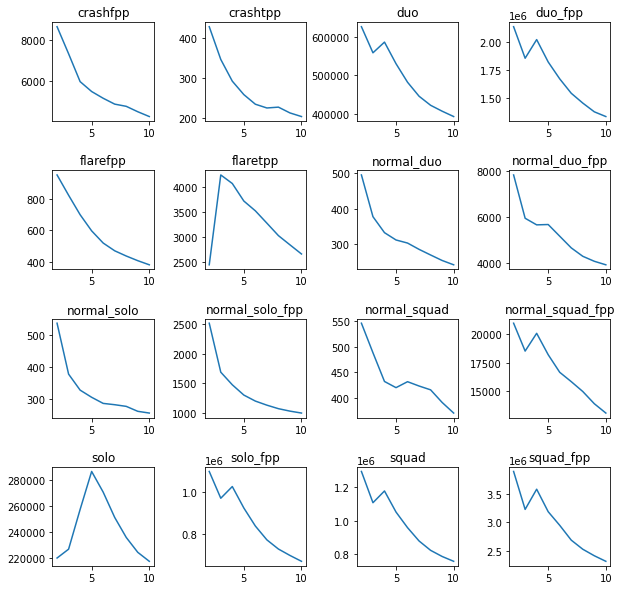

In [199]:
plt.figure(figsize = (10,10))
plt.subplots_adjust(hspace=.5,wspace=.5)
p = 1
for index in range(len(allTypes)):
    
    name = names[index]
    single_type = allTypes[index].copy()
        
    single_y = single_type["winPlacePerc"]
    single_X = single_type.drop(["winPlacePerc"],axis=1)
    single_X_temp = single_X.drop(["matchType"],axis=1)
    single_y_temp = pd.DataFrame({"Y": single_y})
    
    scores = []
    Xs = []

    best_n_clusters = 0
    best_score = 0
    best_average_Wpp = 0
    for i in range(2,11):   
        kmeans.n_clusters = i
    
        kmeans.fit(single_X_temp)
        score = metrics.calinski_harabasz_score(single_X_temp,kmeans.labels_)
        single_X_temp["cluster"] = kmeans.labels_
        single_y_temp["cluster"] = kmeans.labels_
        average_Wpp = getAverageWPP(single_y_temp,i)
        if(score>best_score):
            best_score = score
            best_n_clusters = i
            best_average_Wpp = average_Wpp
        print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
        Xs.append(i)
        scores.append(score)
        single_X_temp=single_X_temp.drop(["cluster"],axis=1) 

    print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)
    ax = plt.subplot(4,4,p)
    ax.plot(Xs,scores)
    ax.set_title(name)
    p+=1
plt.show()

In [200]:
best_n_clusters = [2,2,2,2,2,3,2,2,2,2,2,2,5,2,2,2]

#### View the distributions 

crashfpp


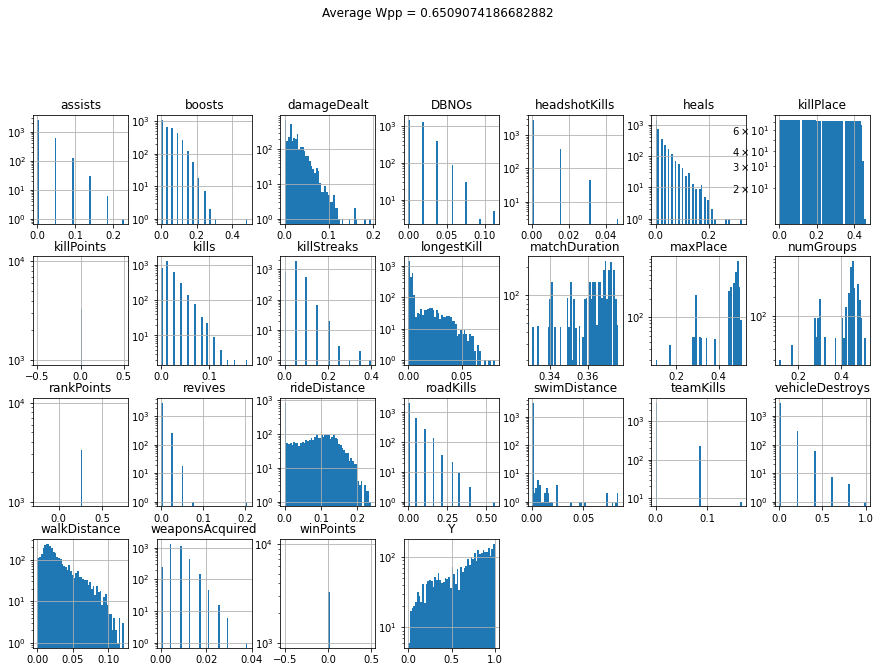

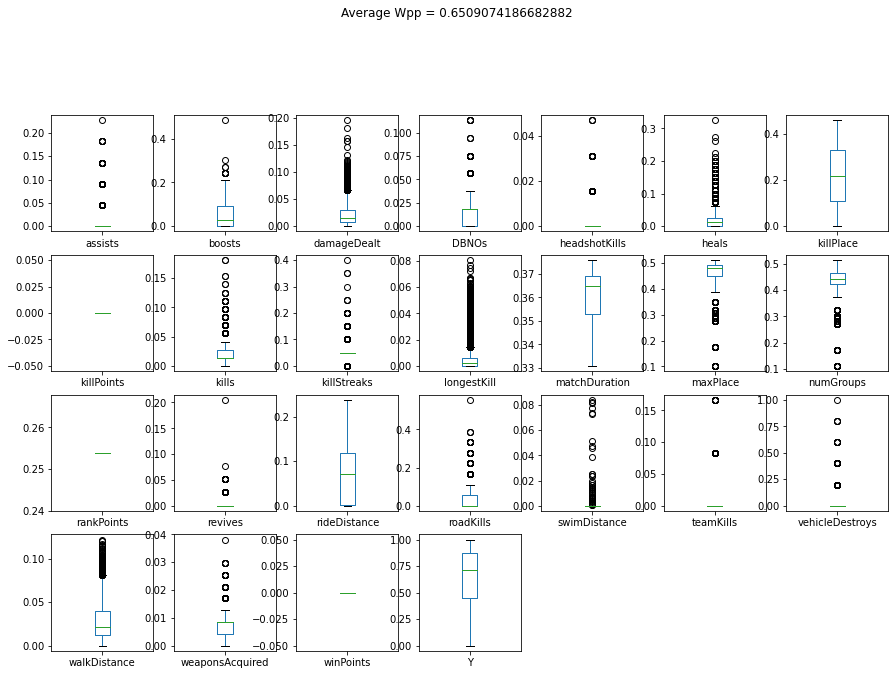

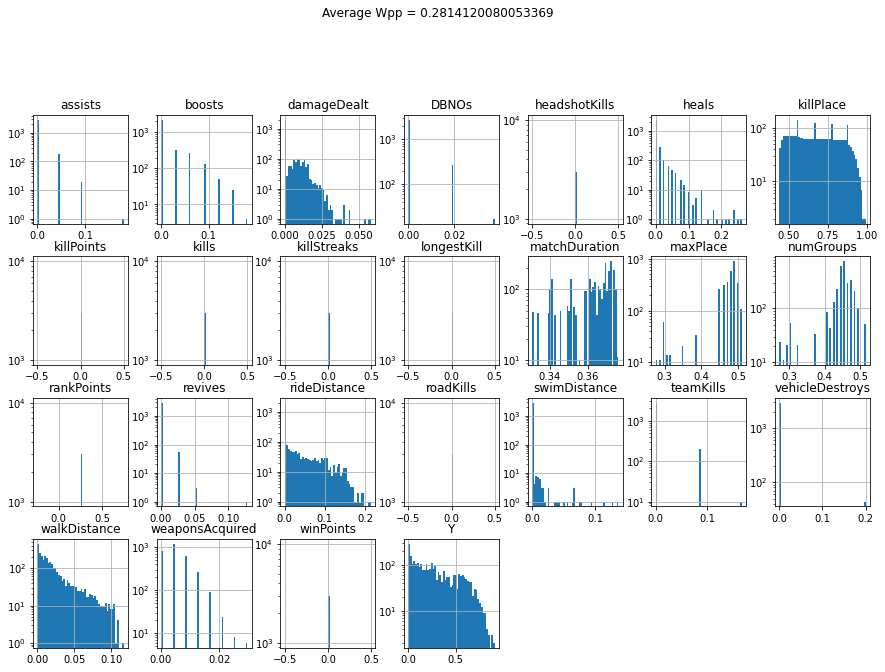

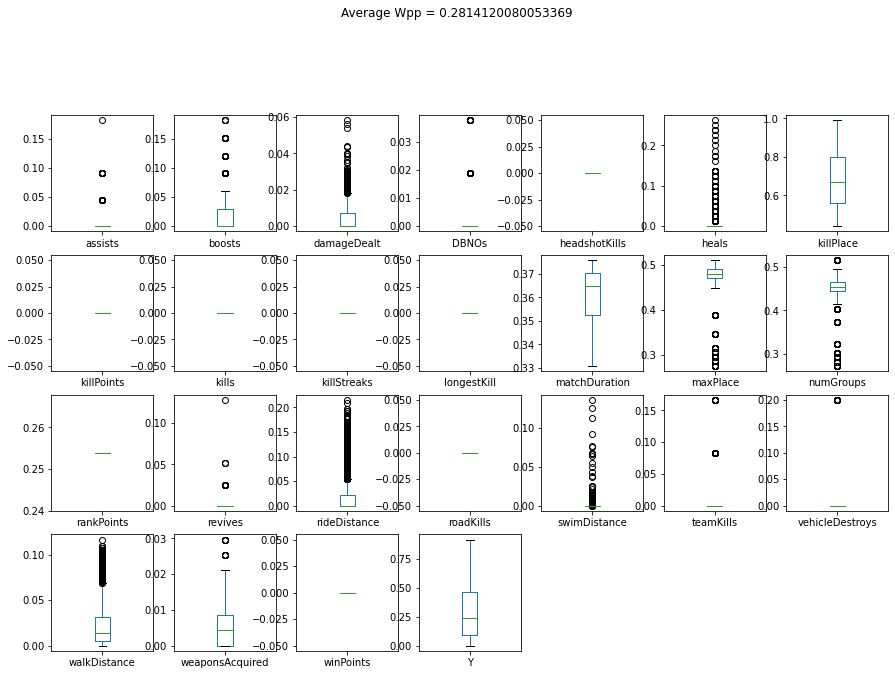

crashtpp


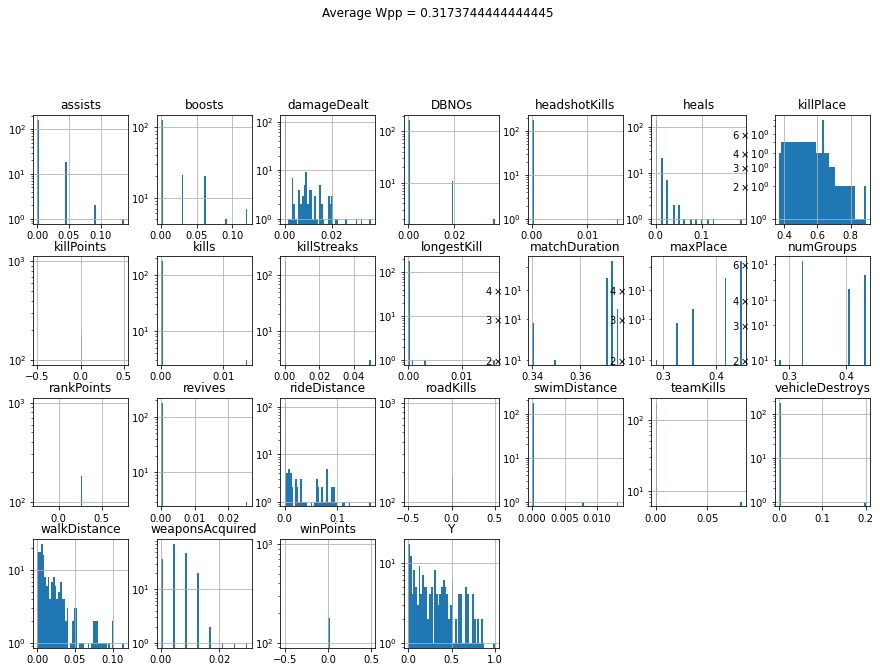

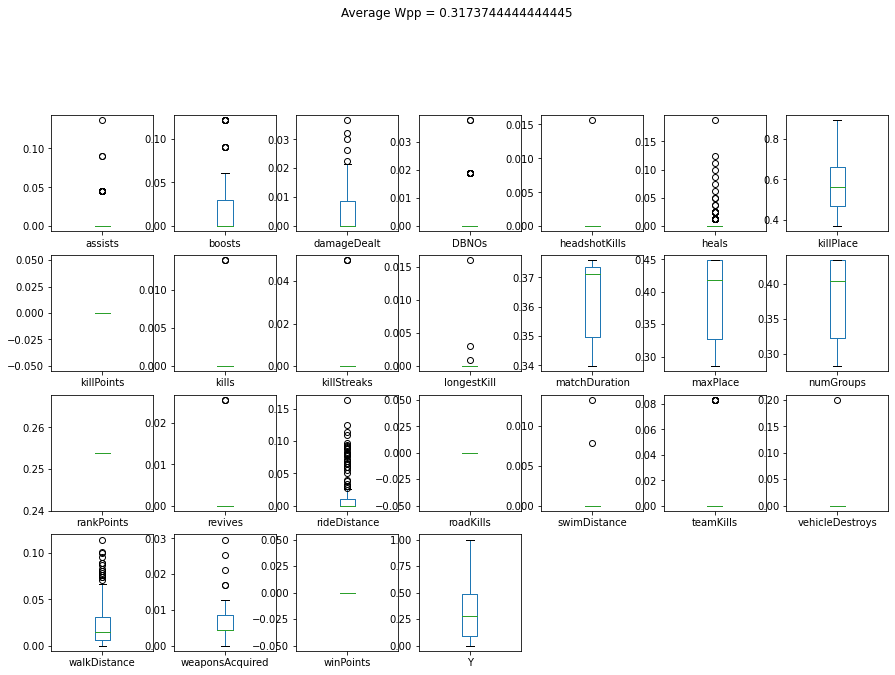

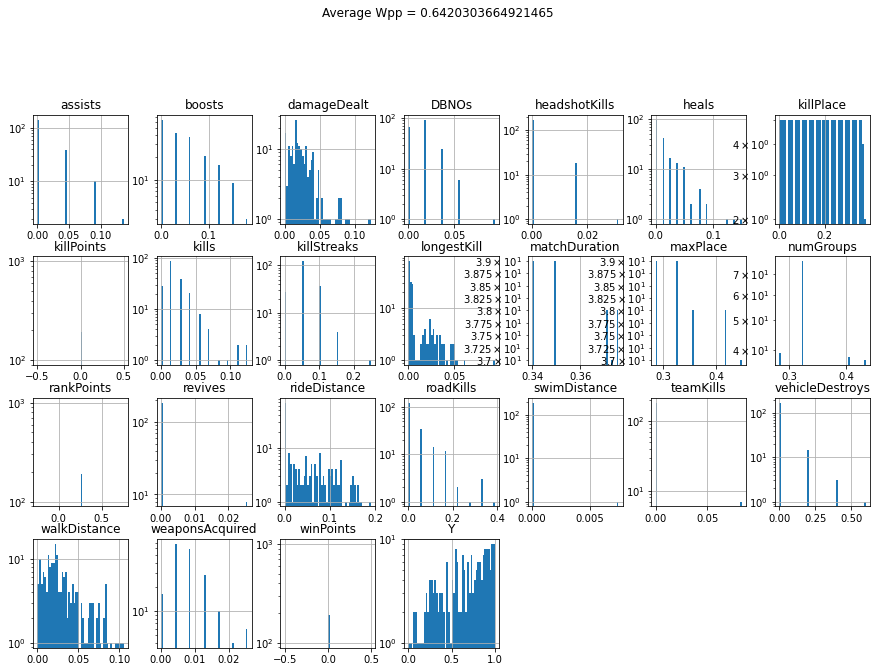

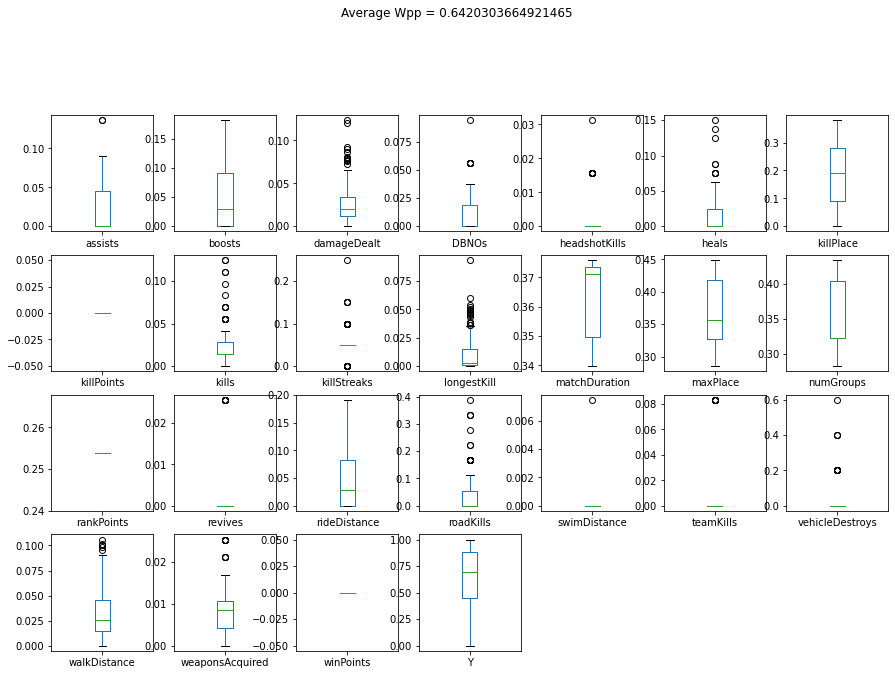

duo


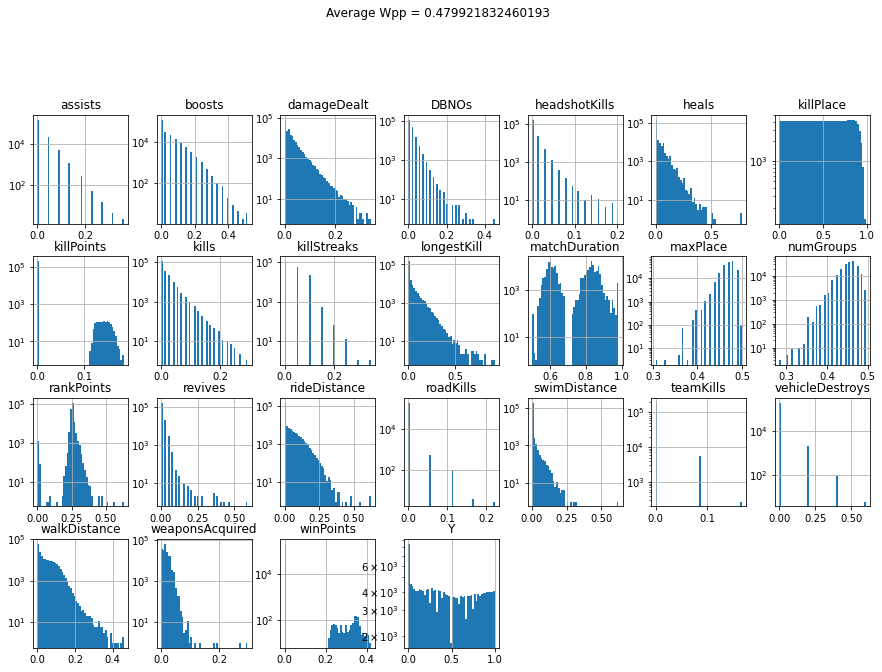

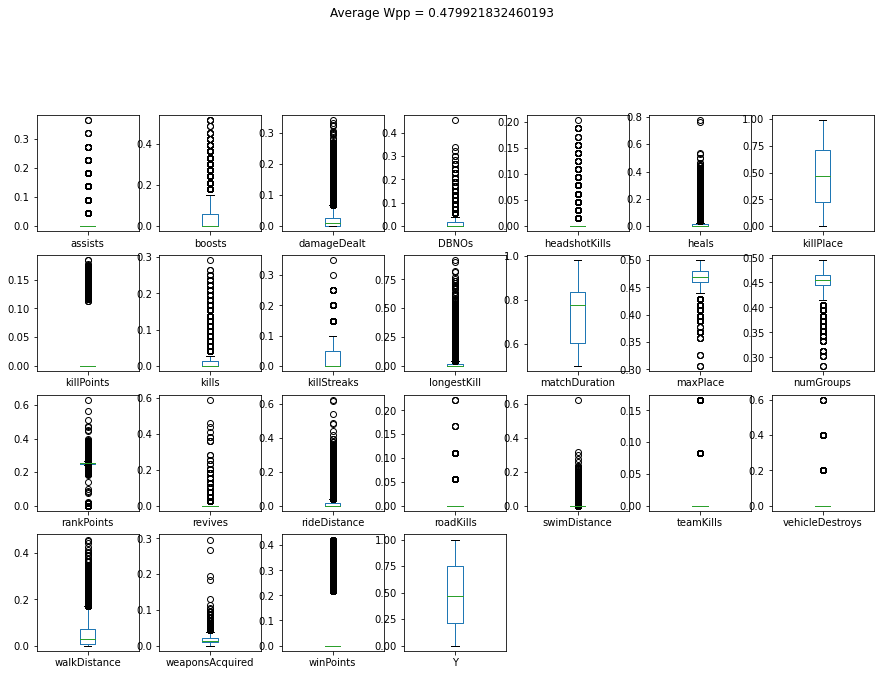

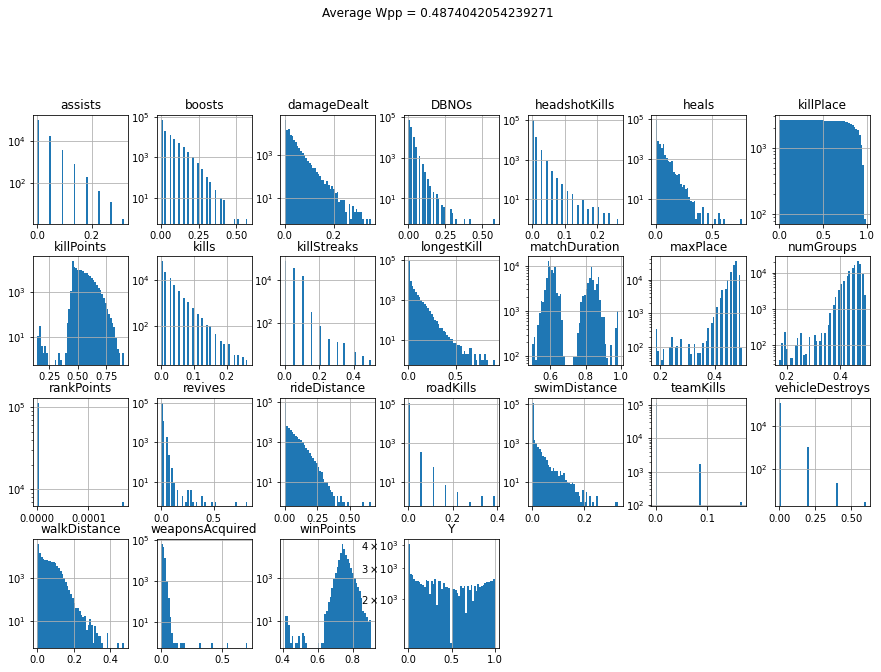

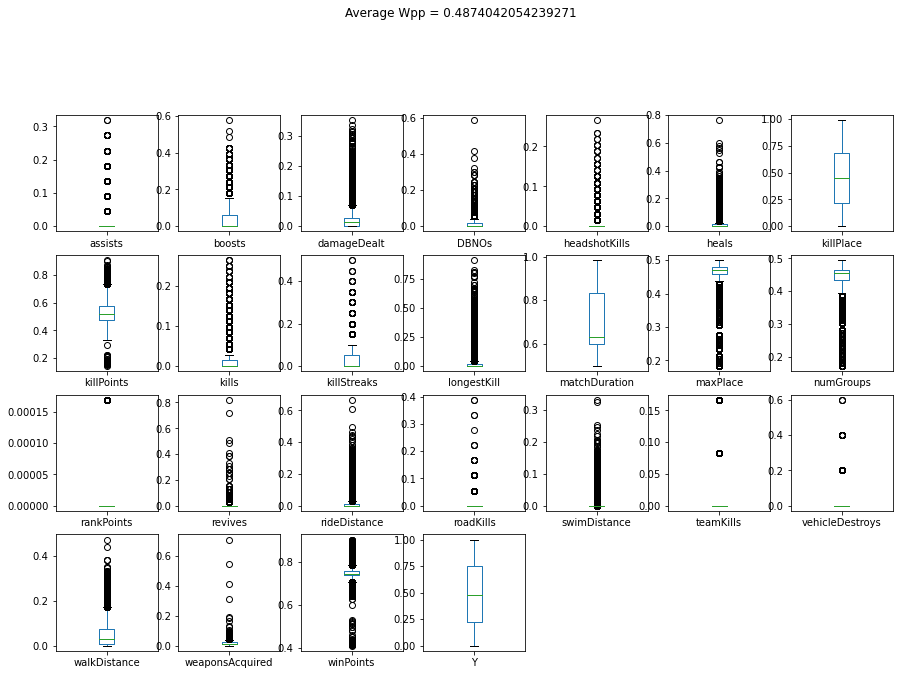

duo_fpp


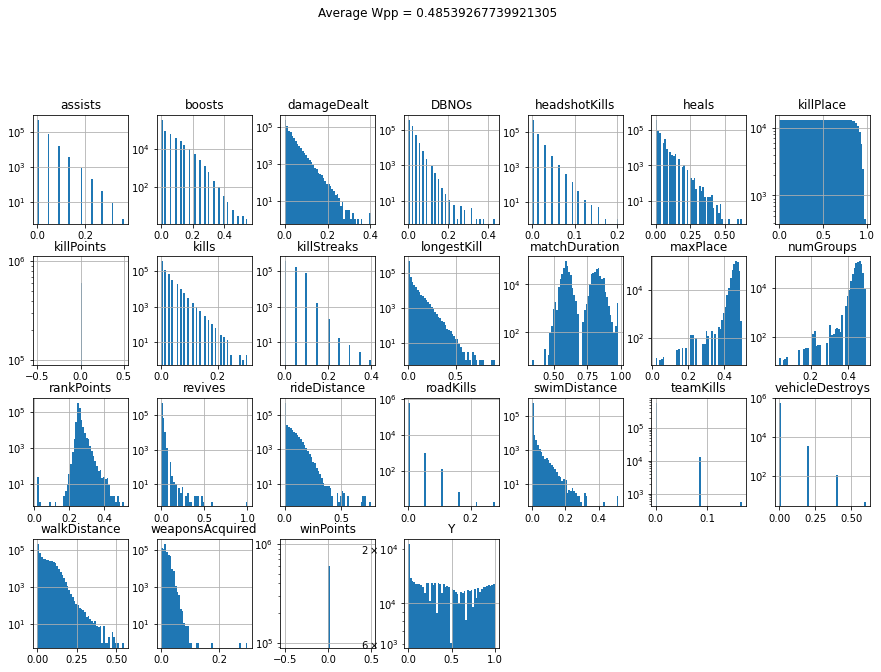

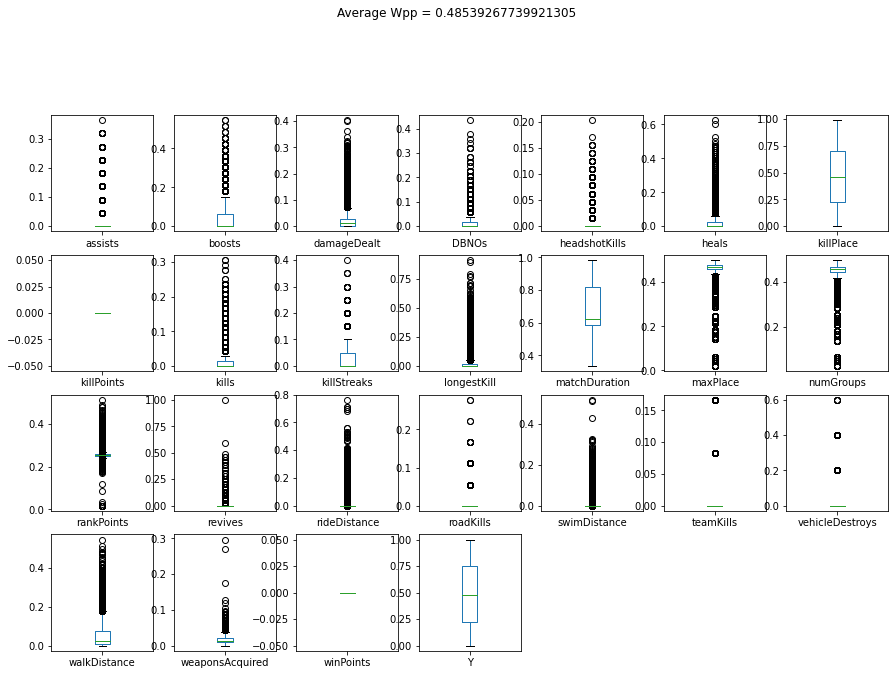

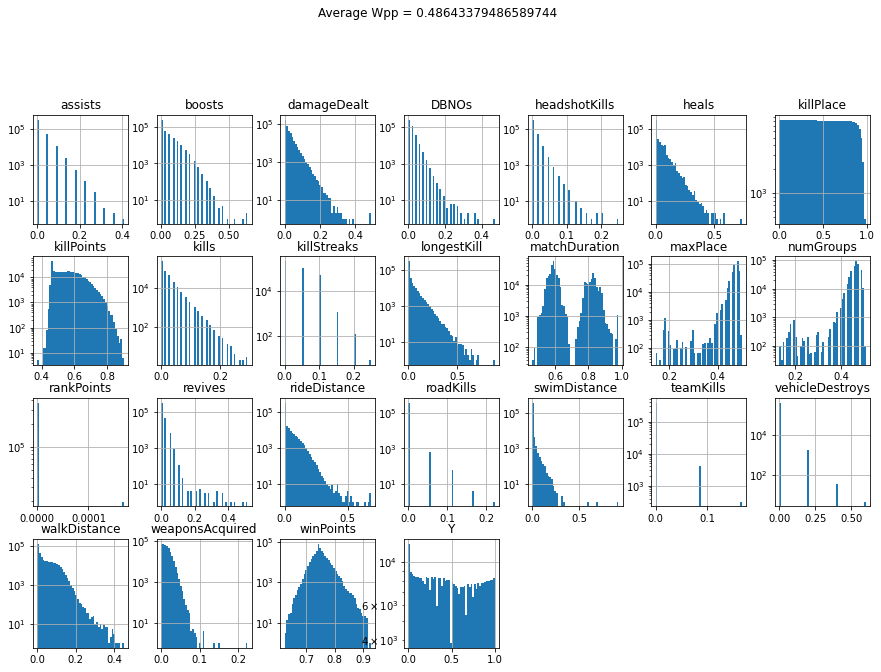

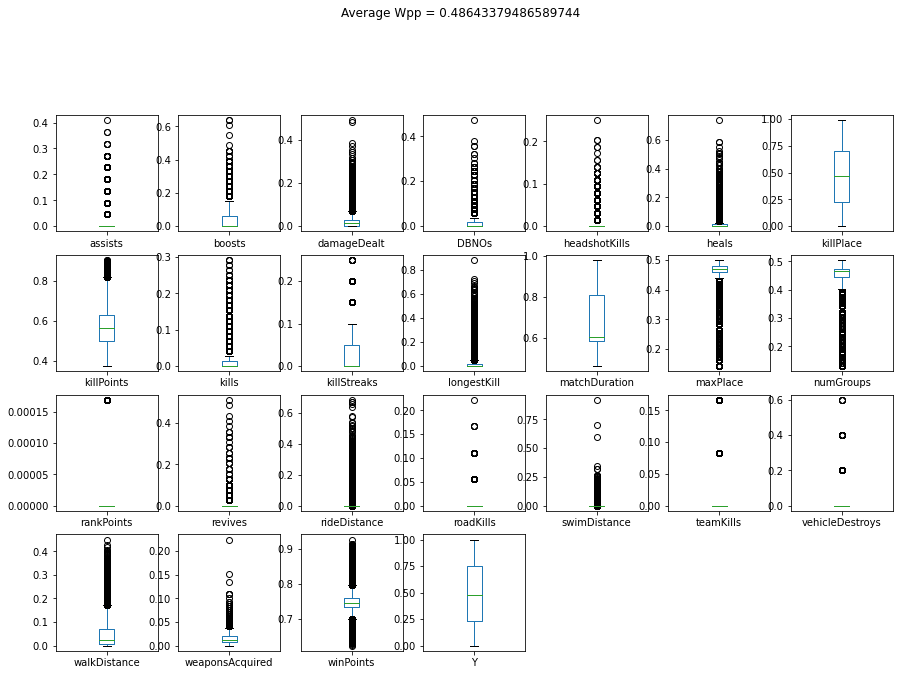

flarefpp


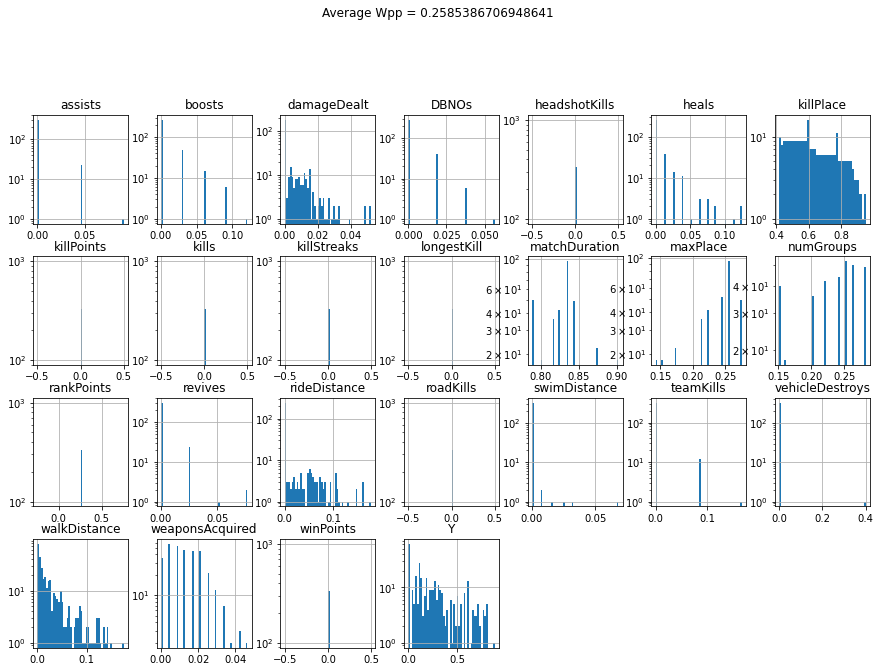

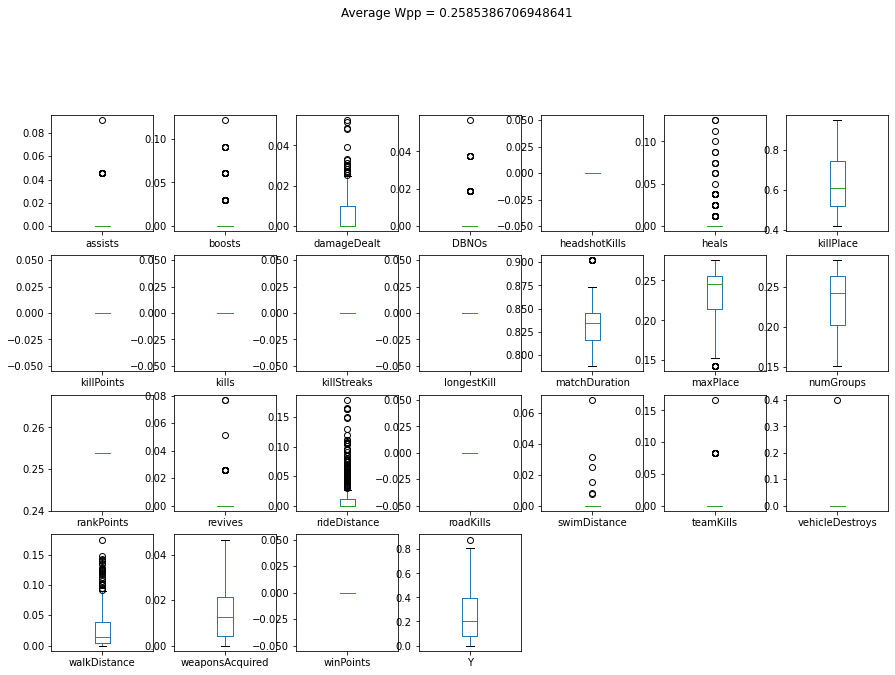

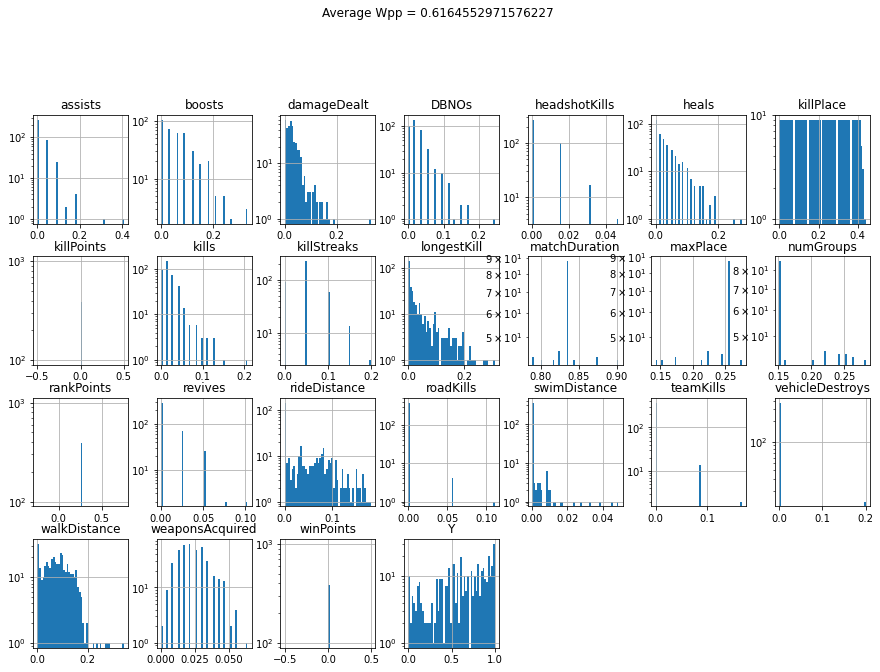

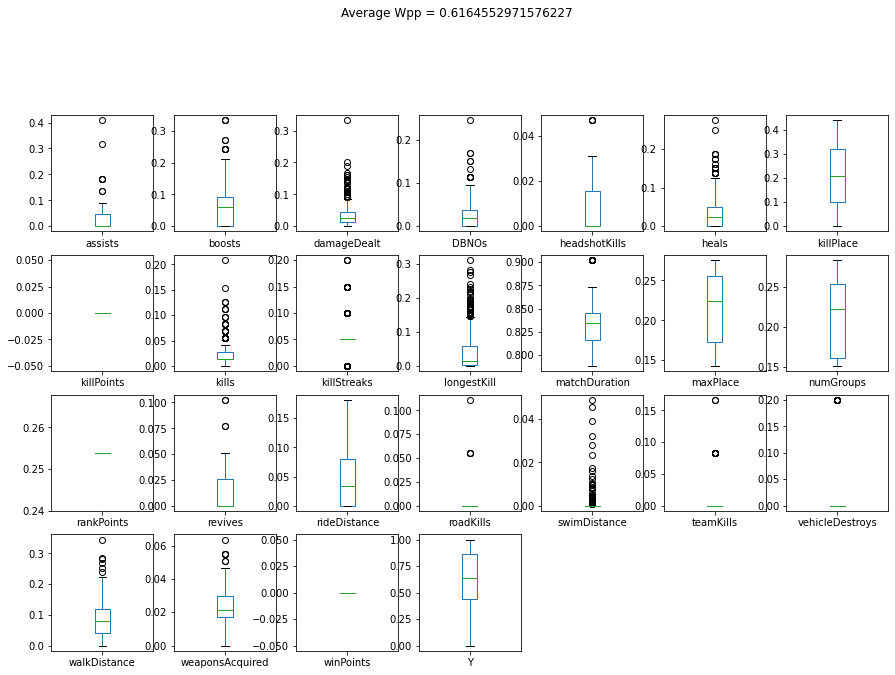

flaretpp


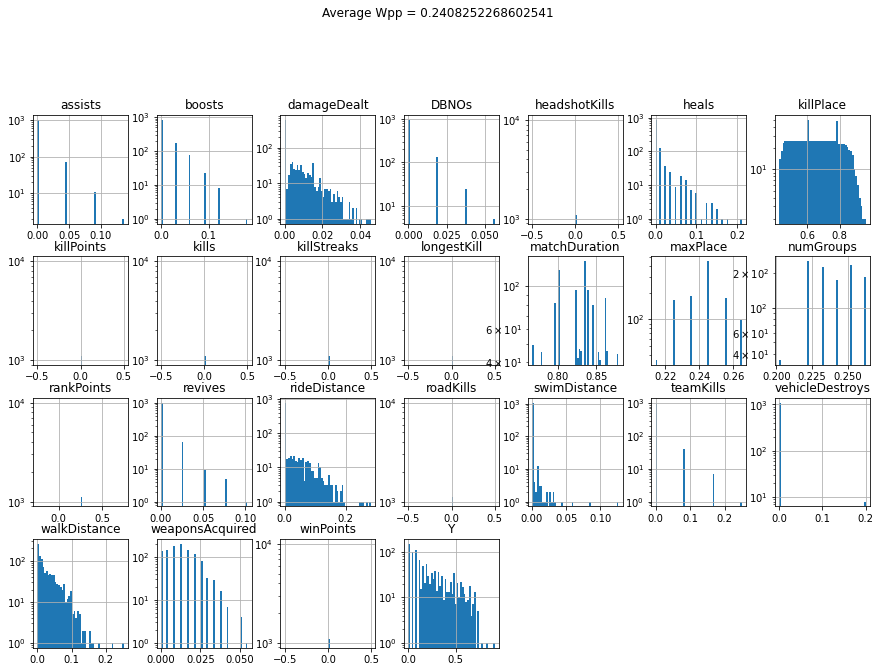

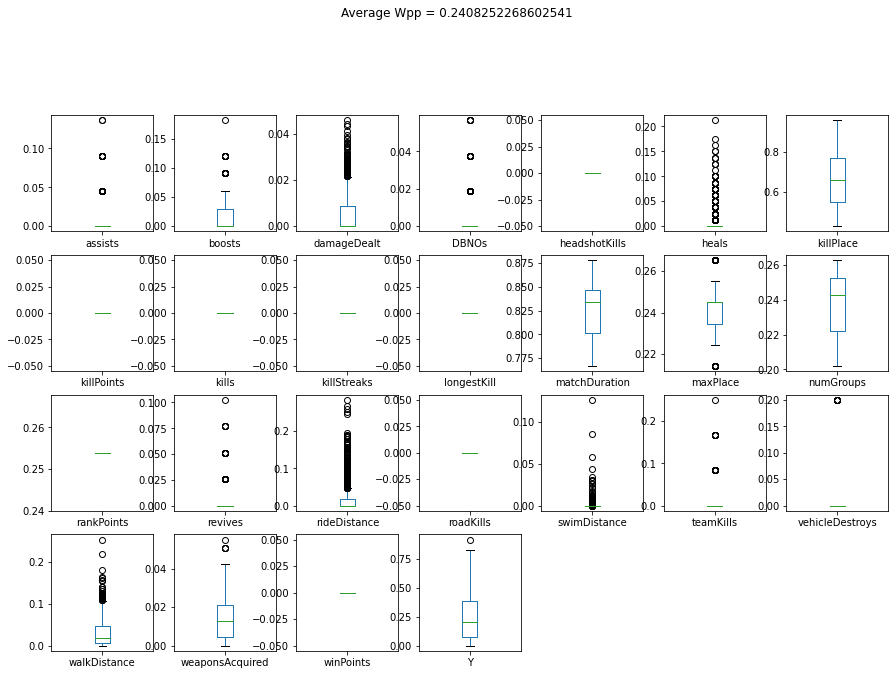

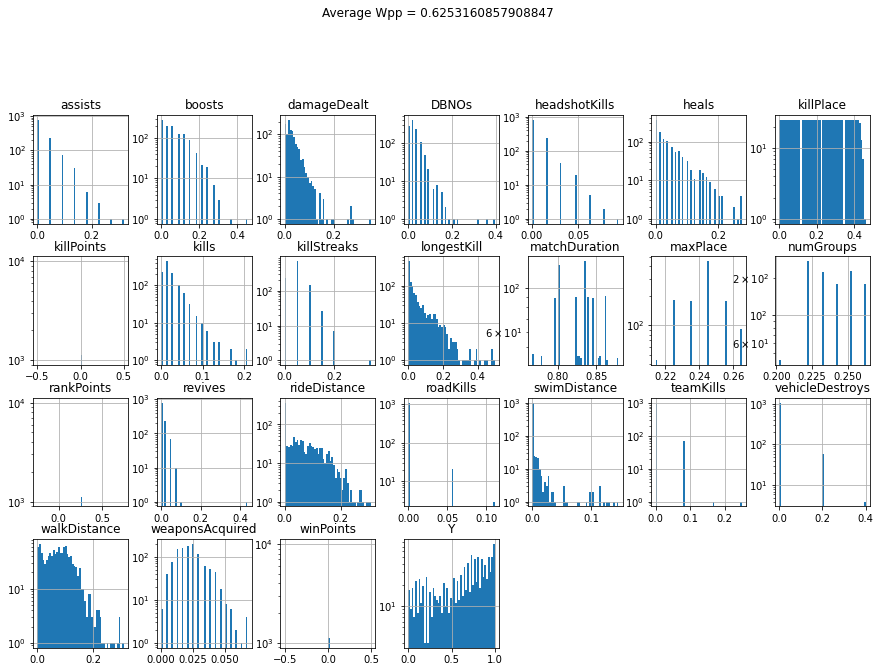

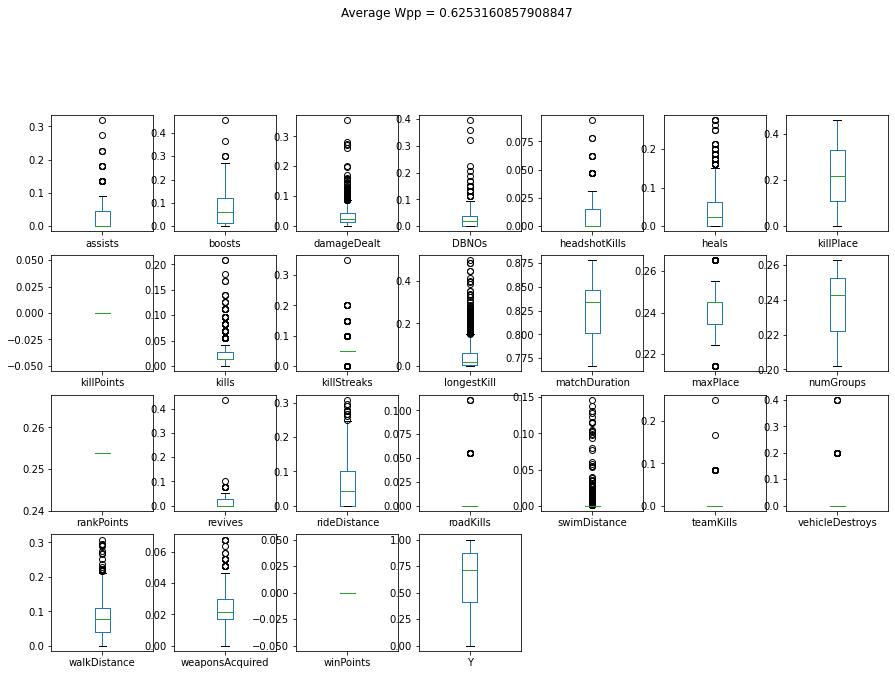

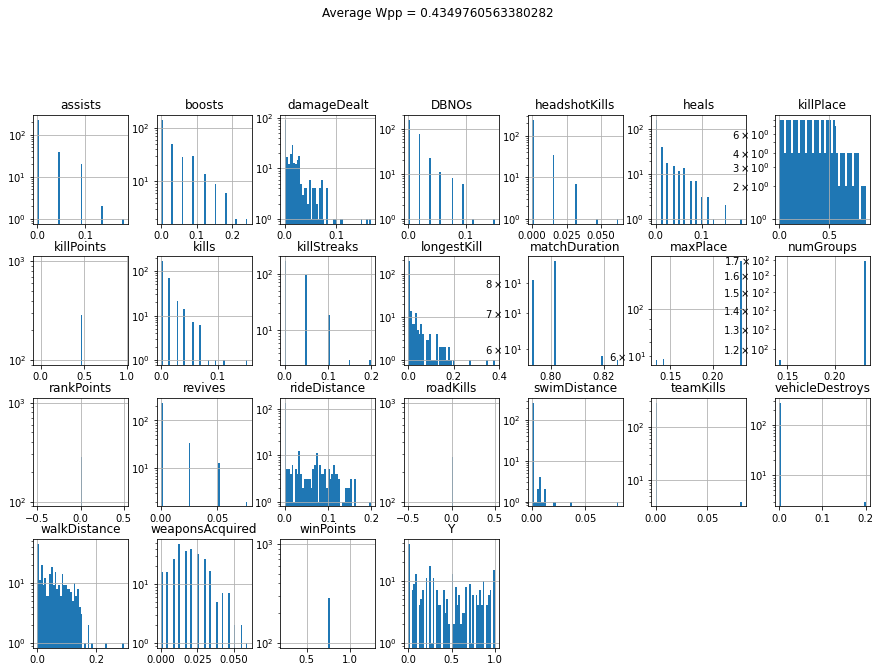

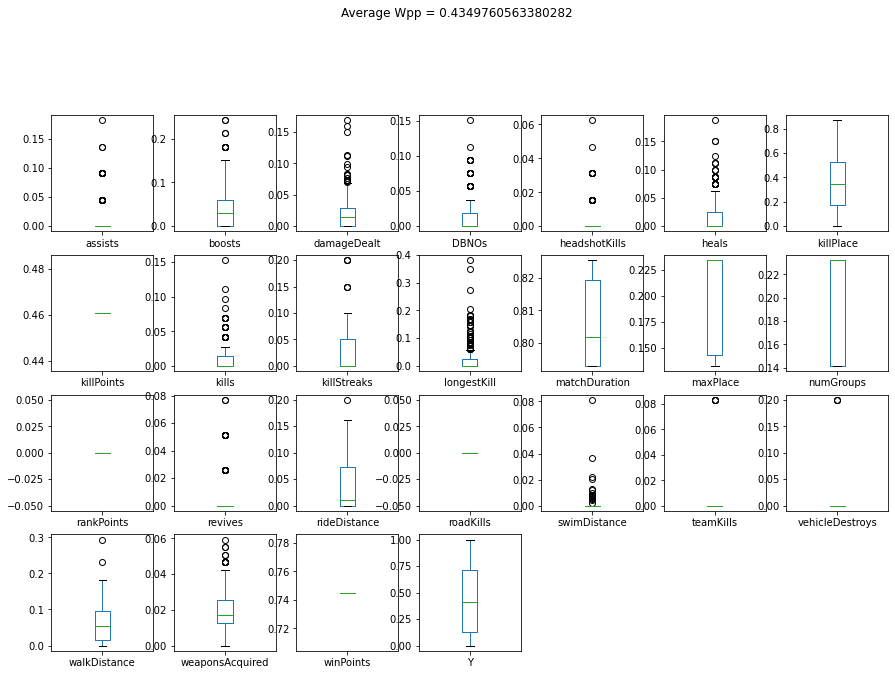

normal_duo


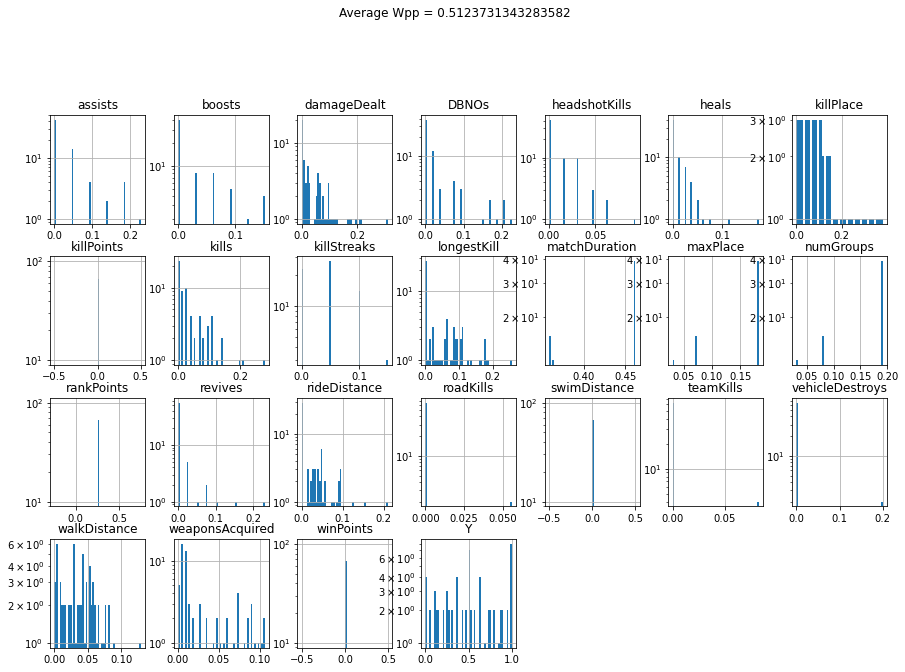

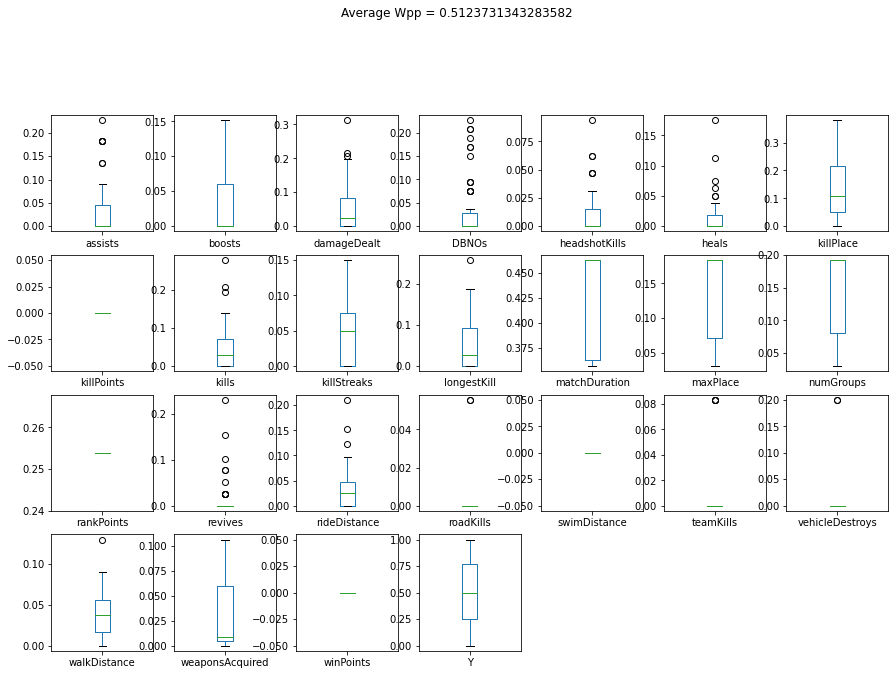

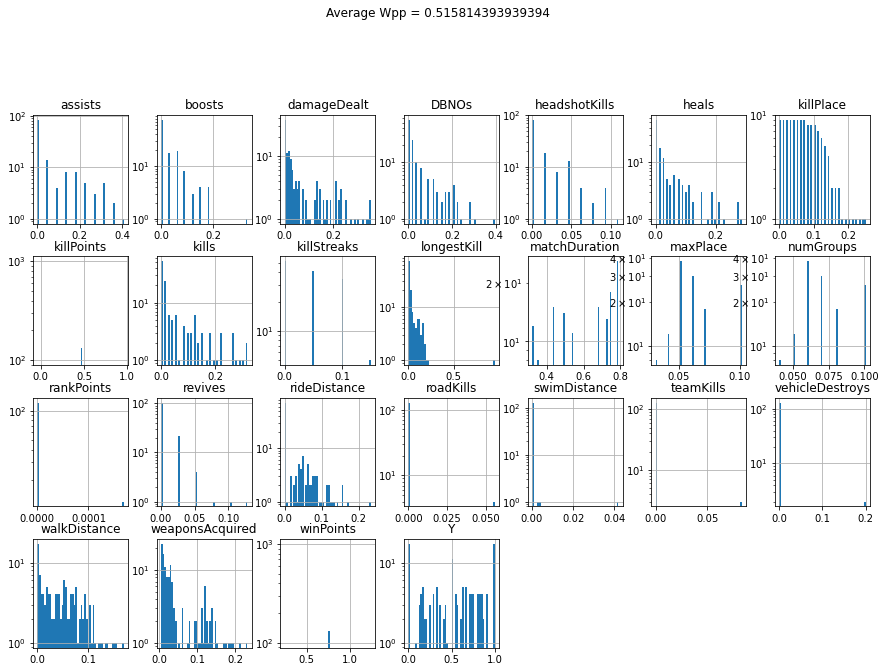

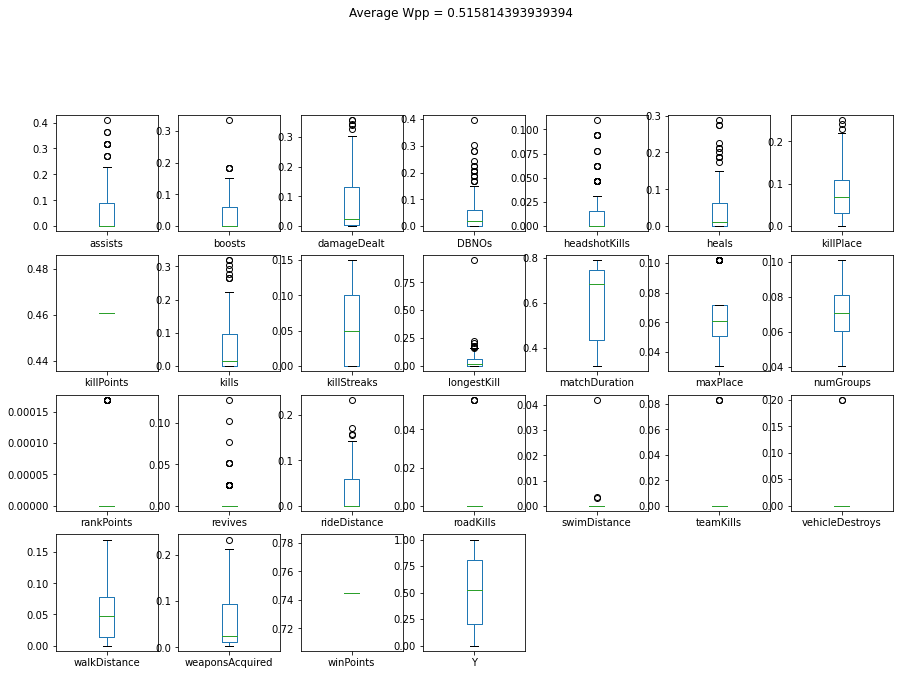

normal_duo_fpp


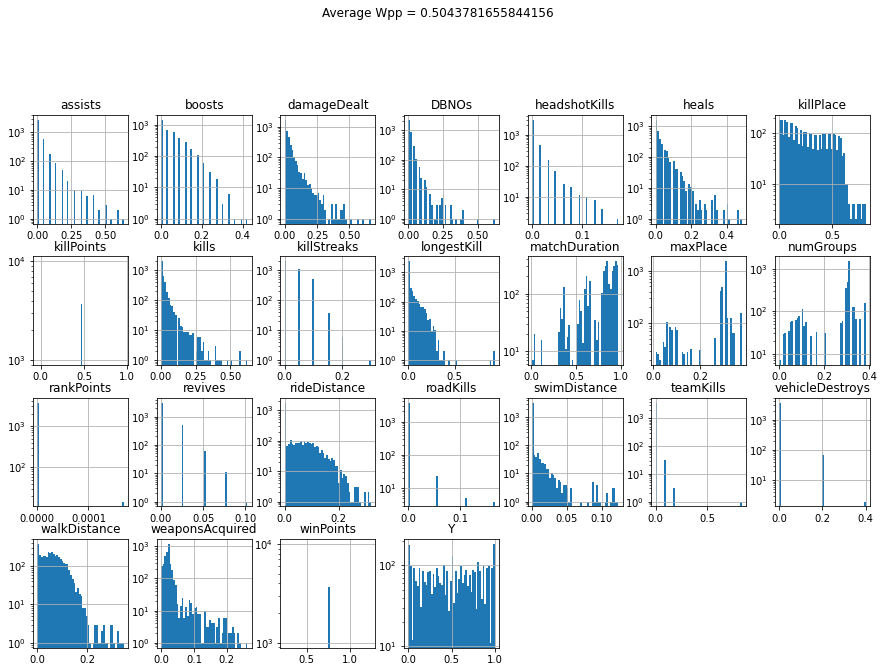

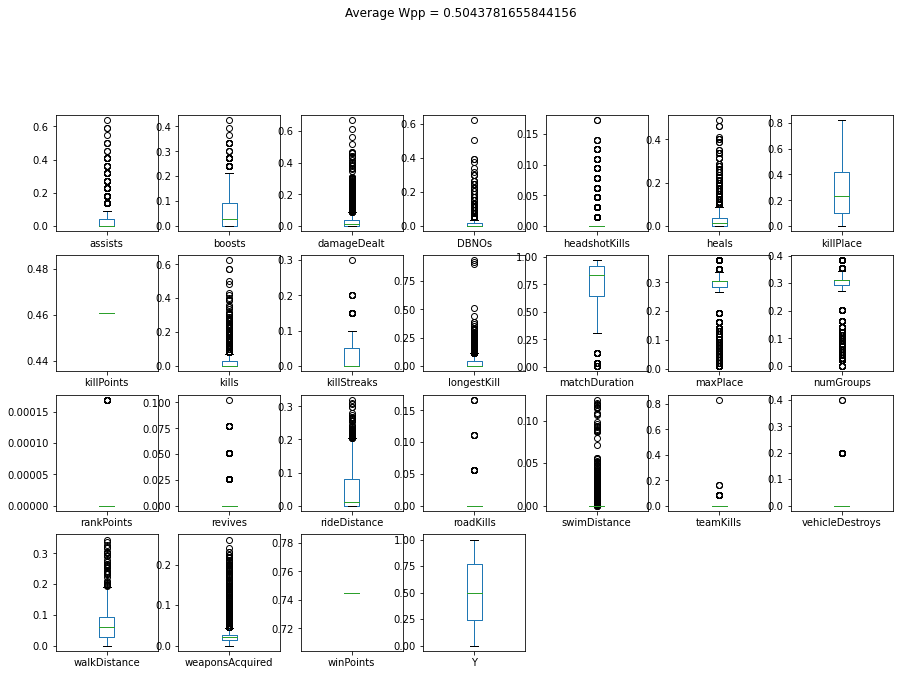

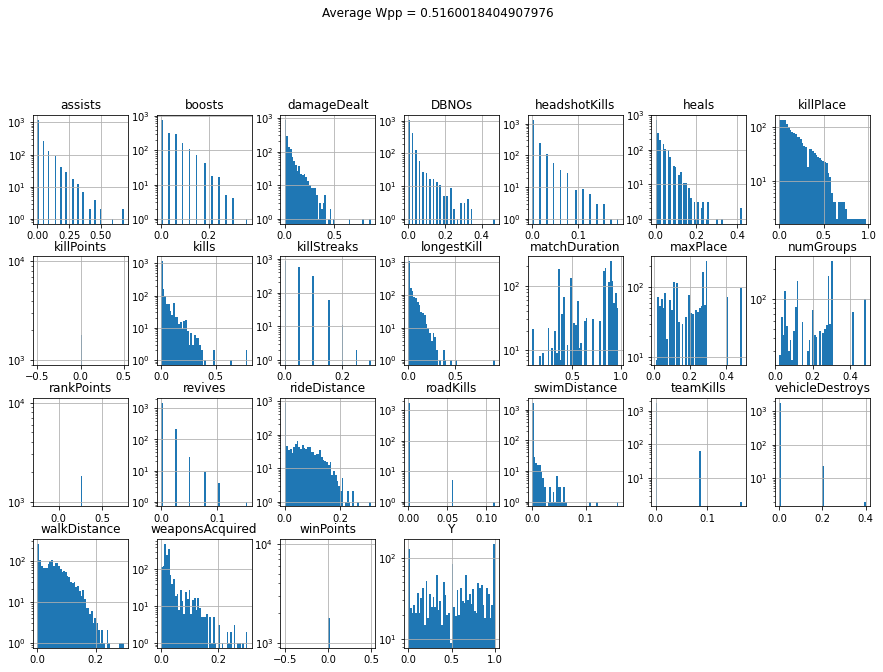

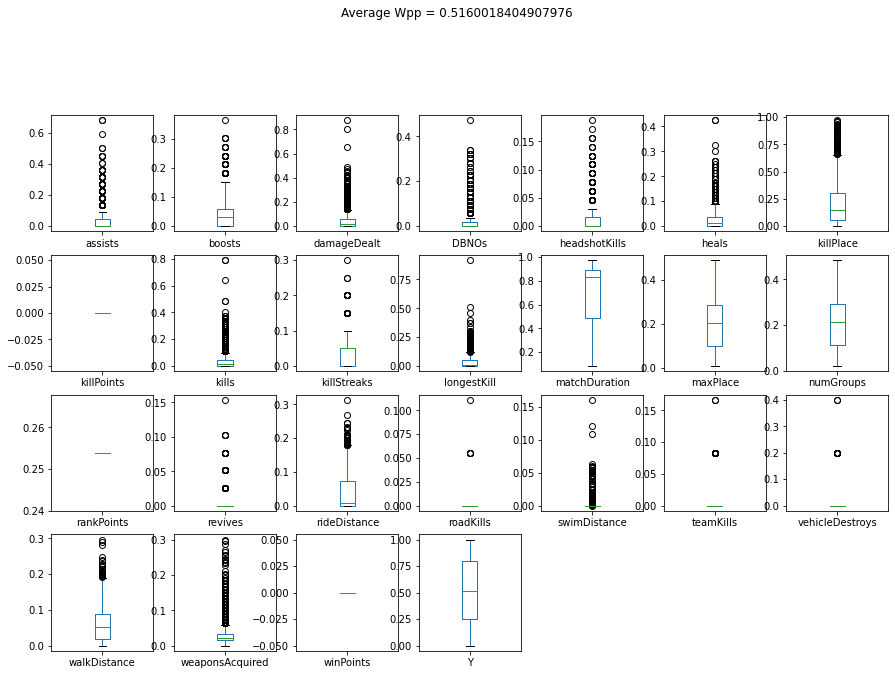

normal_solo


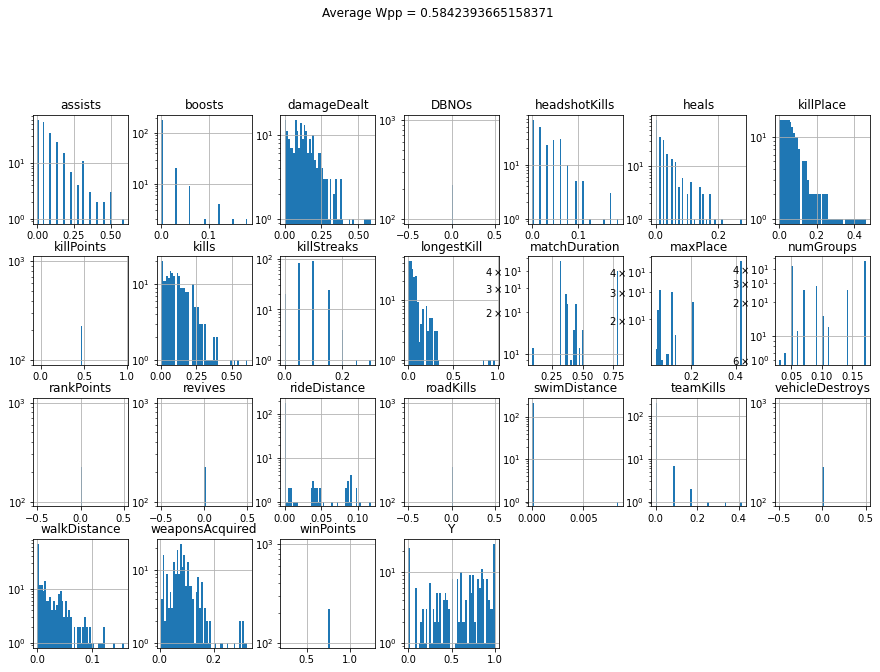

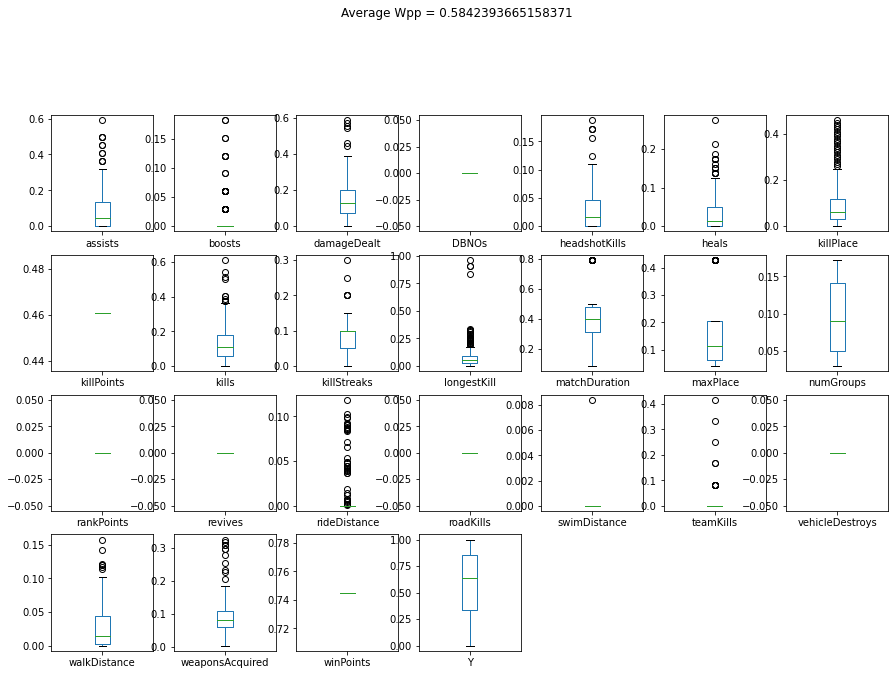

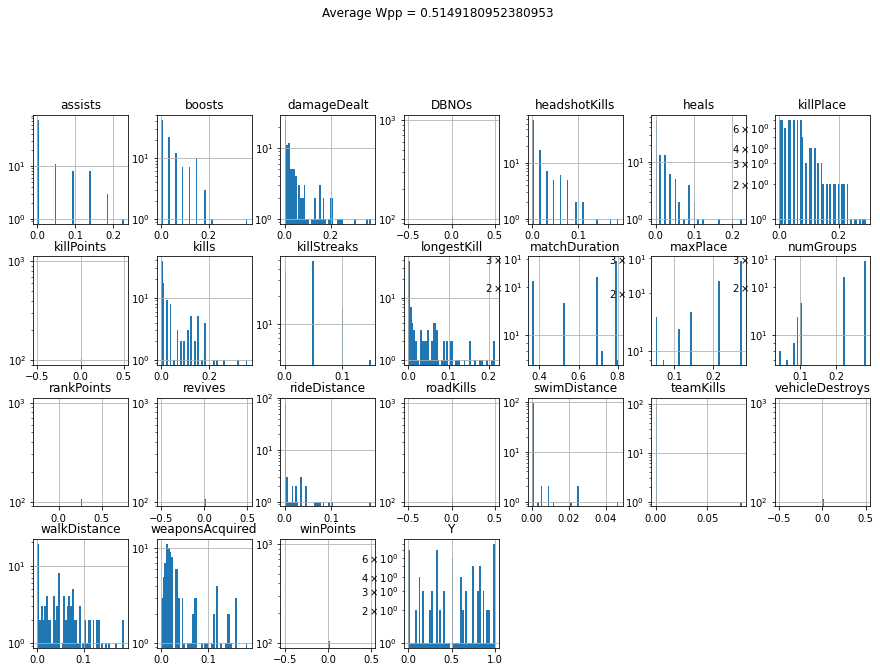

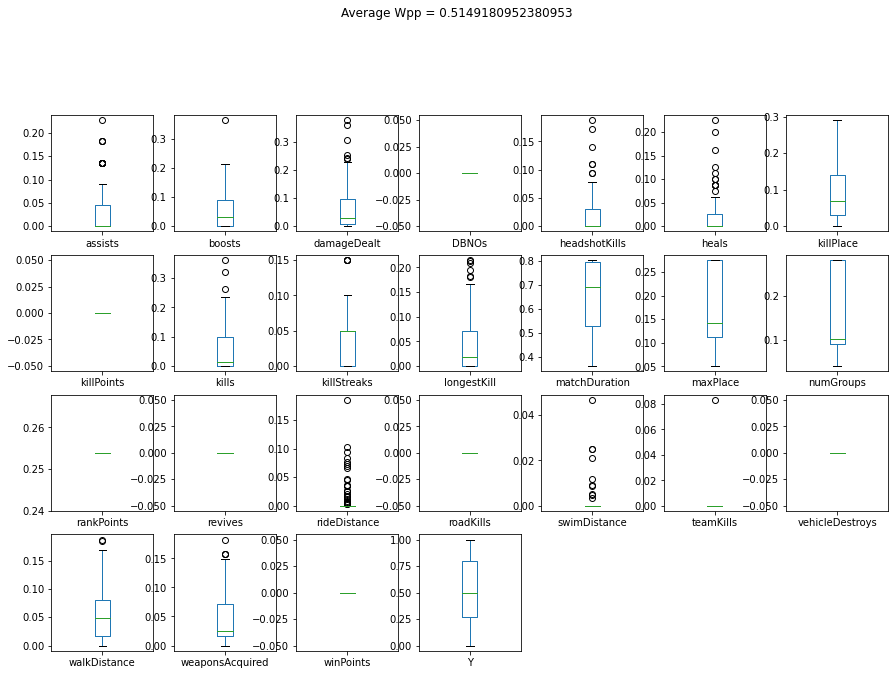

normal_solo_fpp


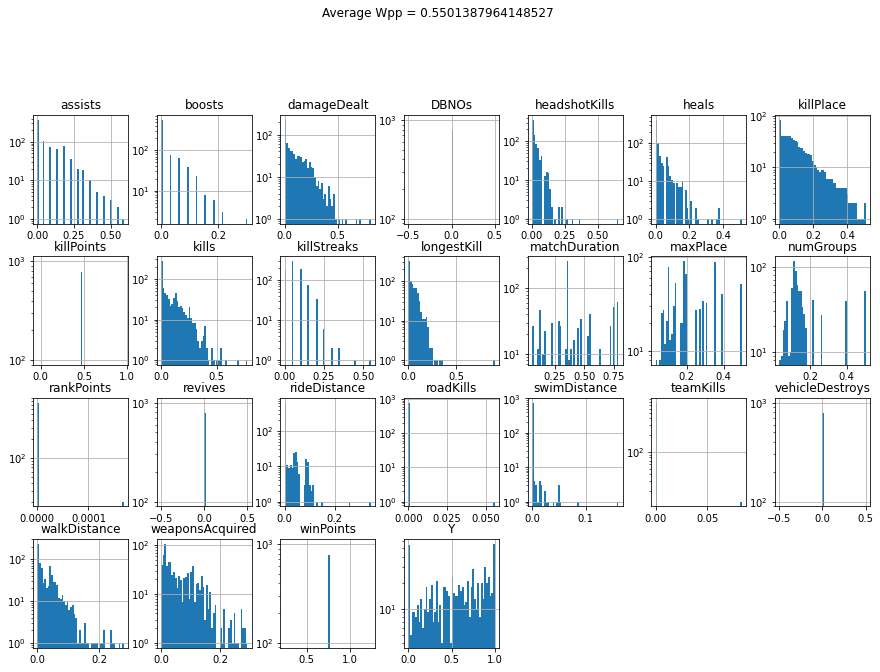

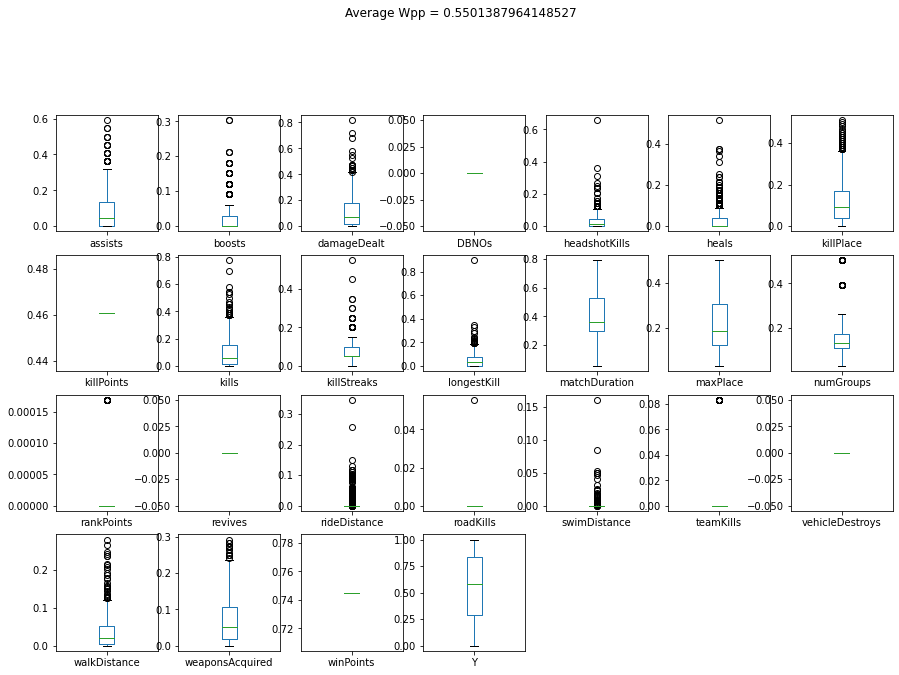

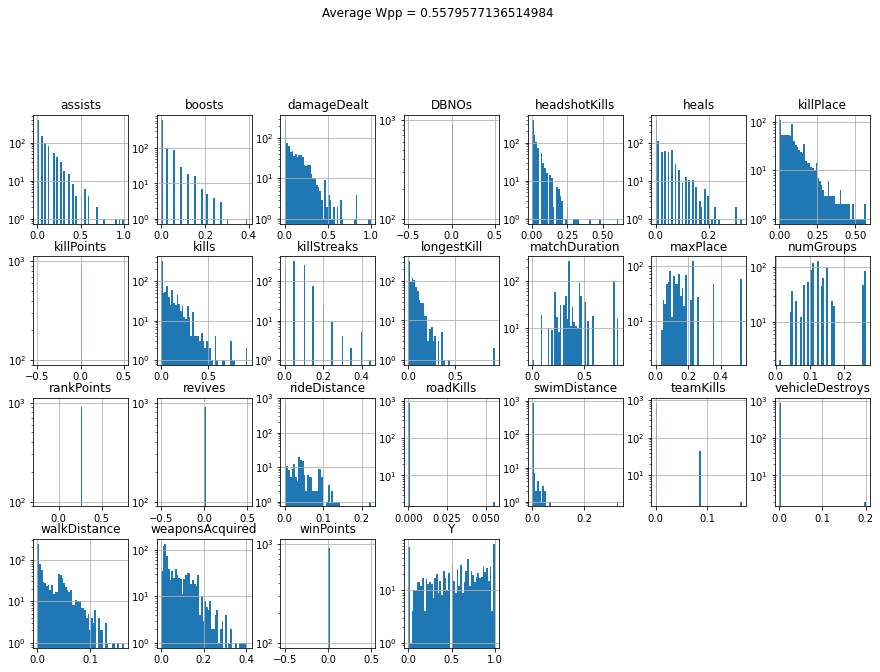

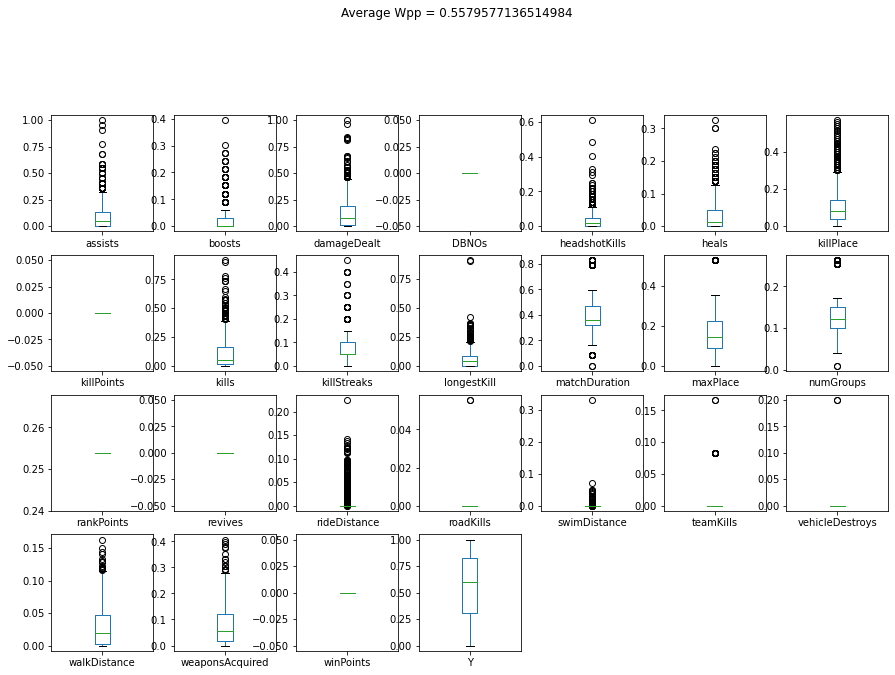

normal_squad


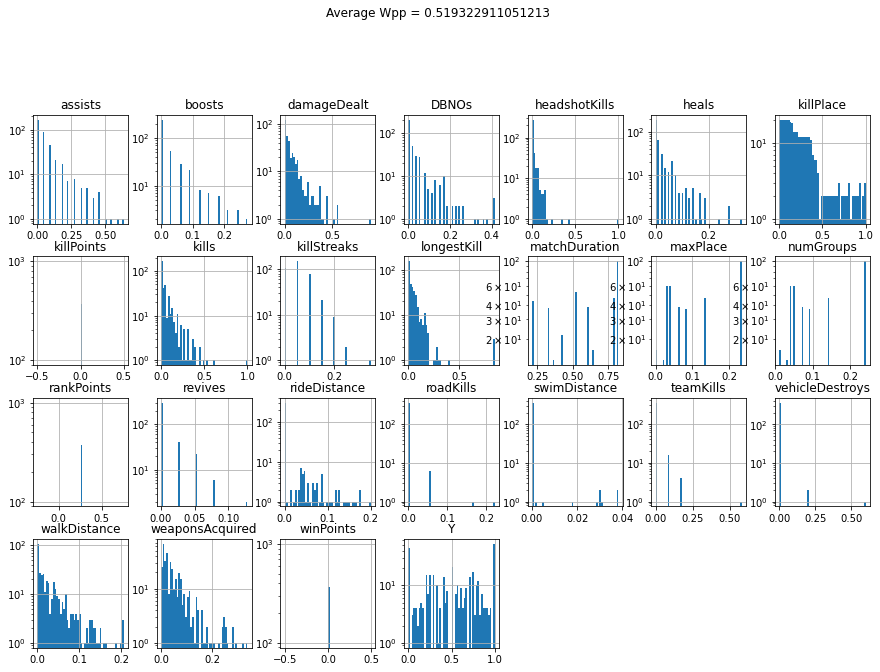

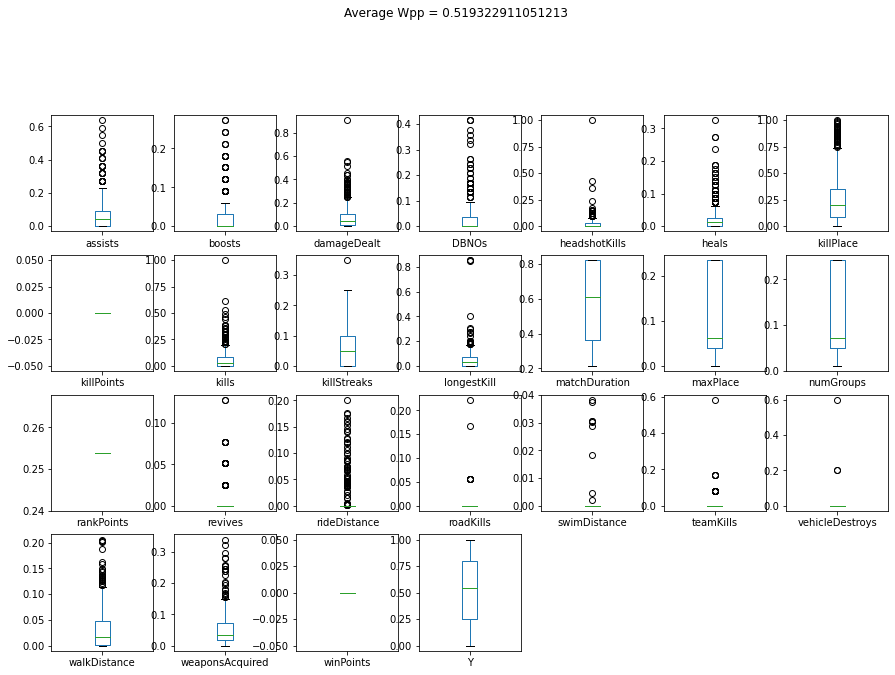

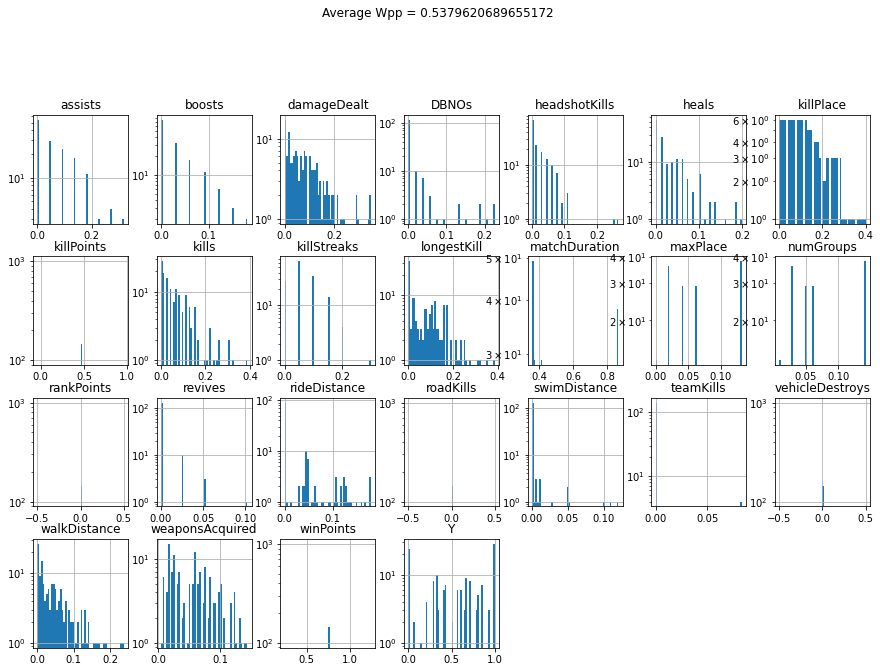

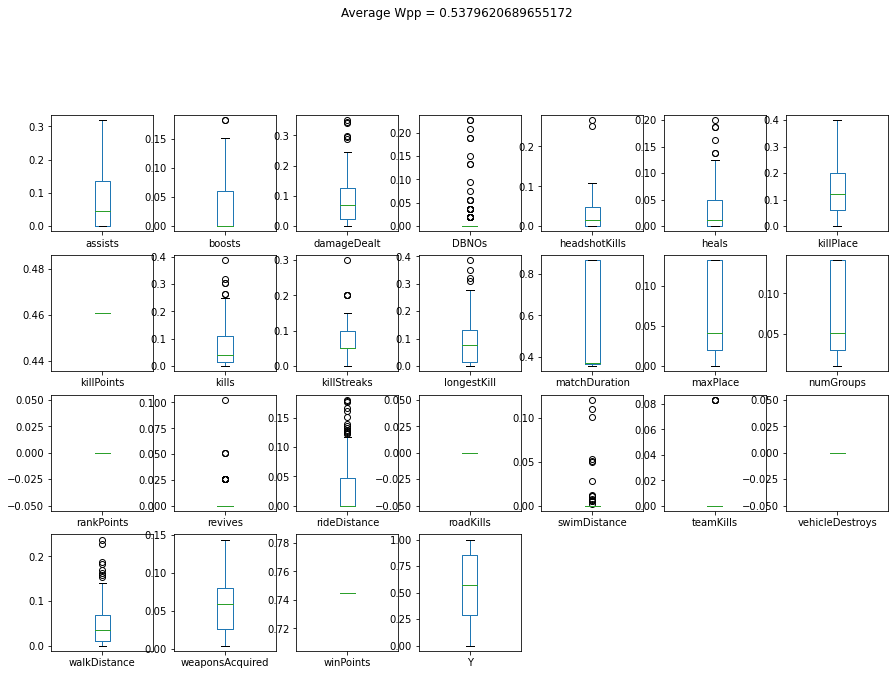

normal_squad_fpp


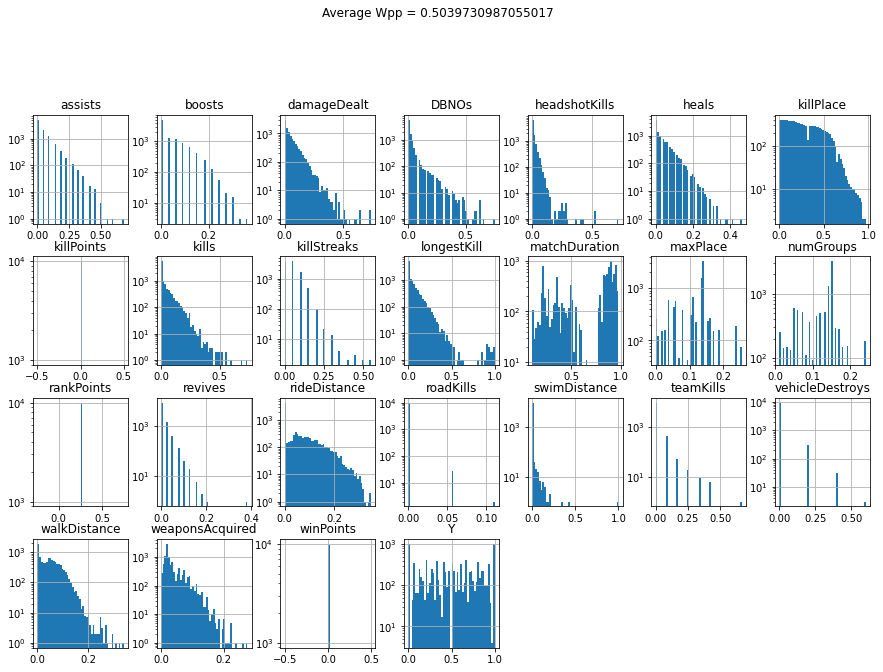

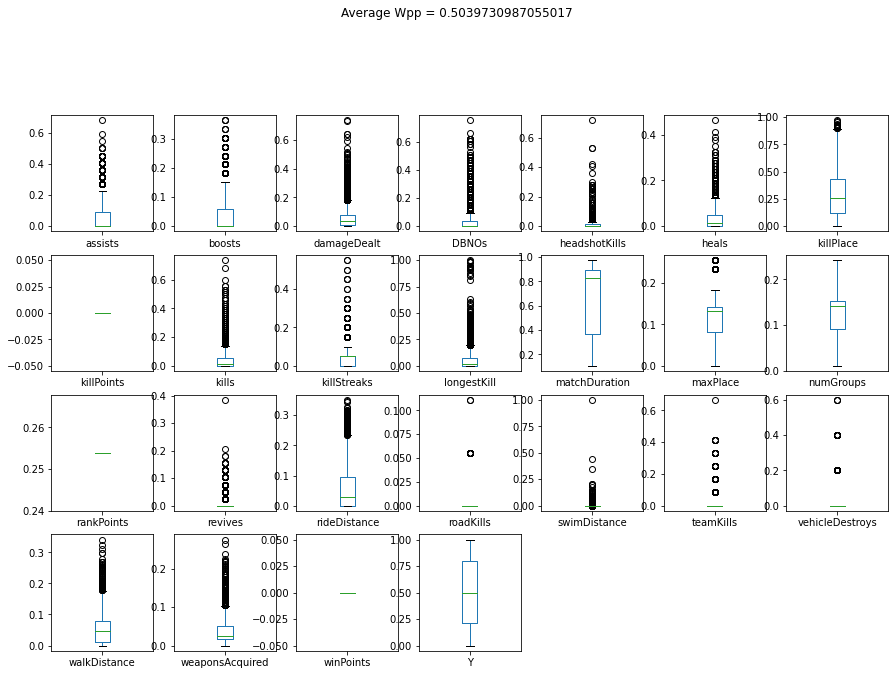

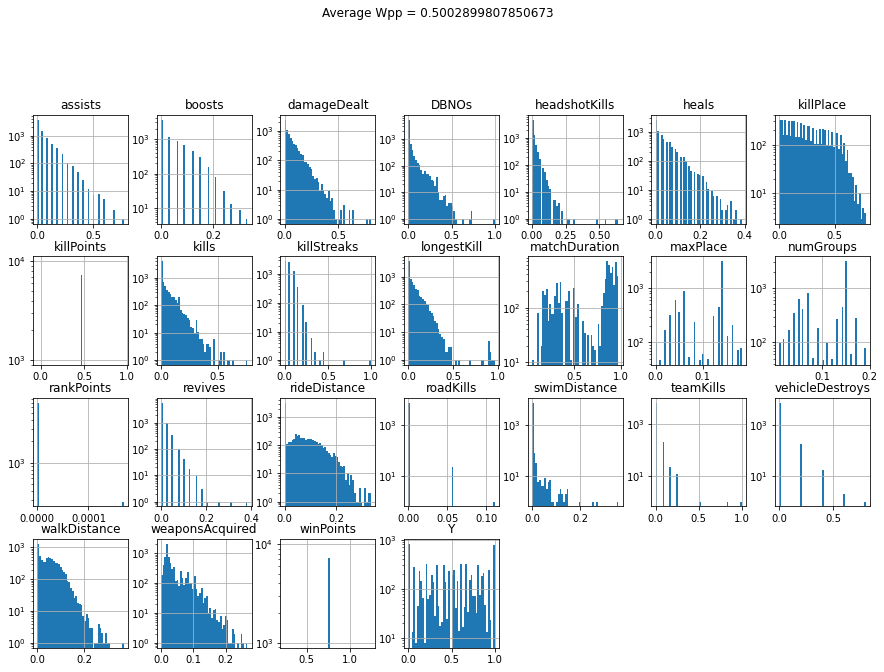

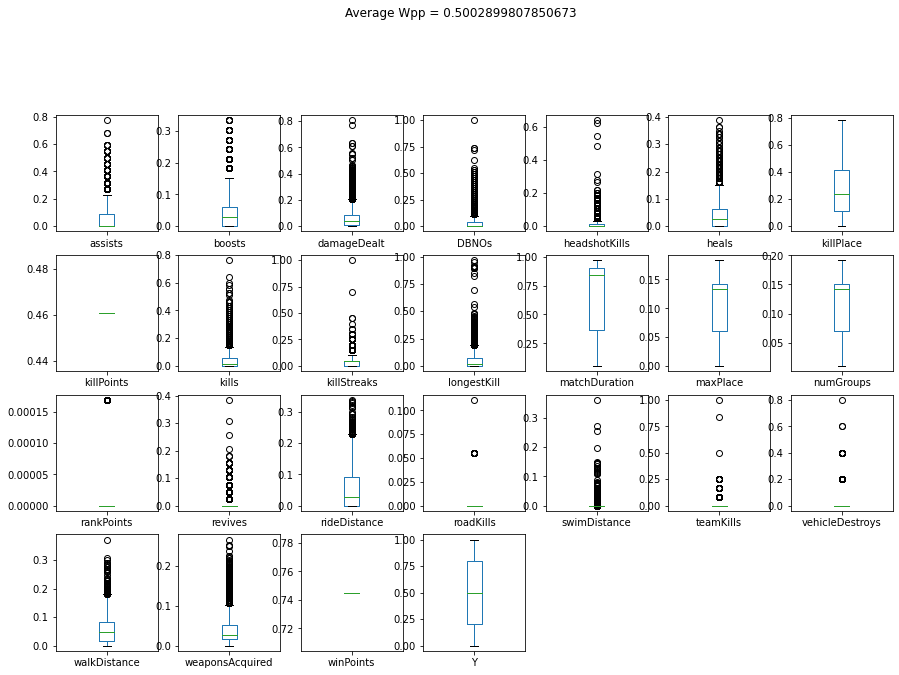

solo


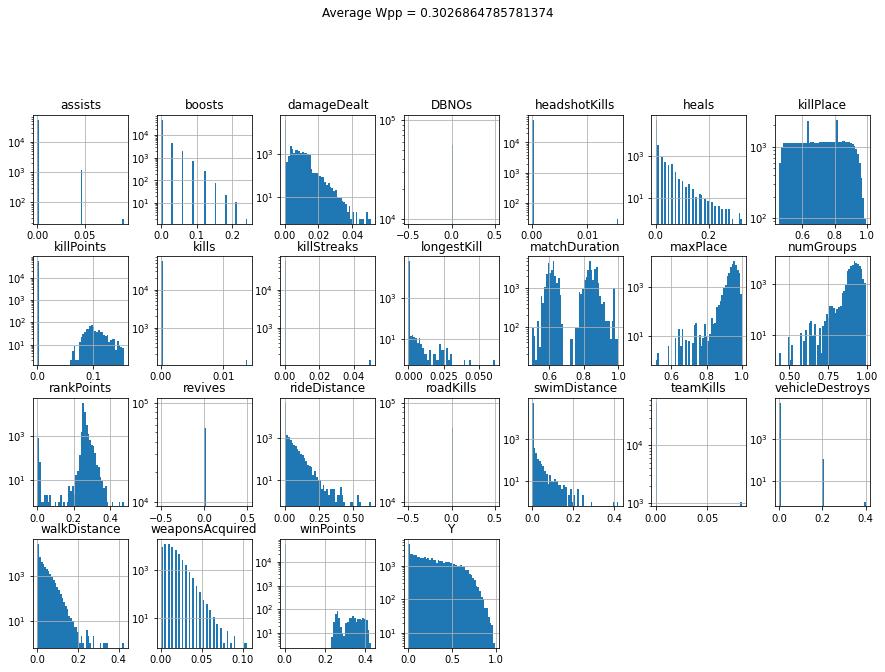

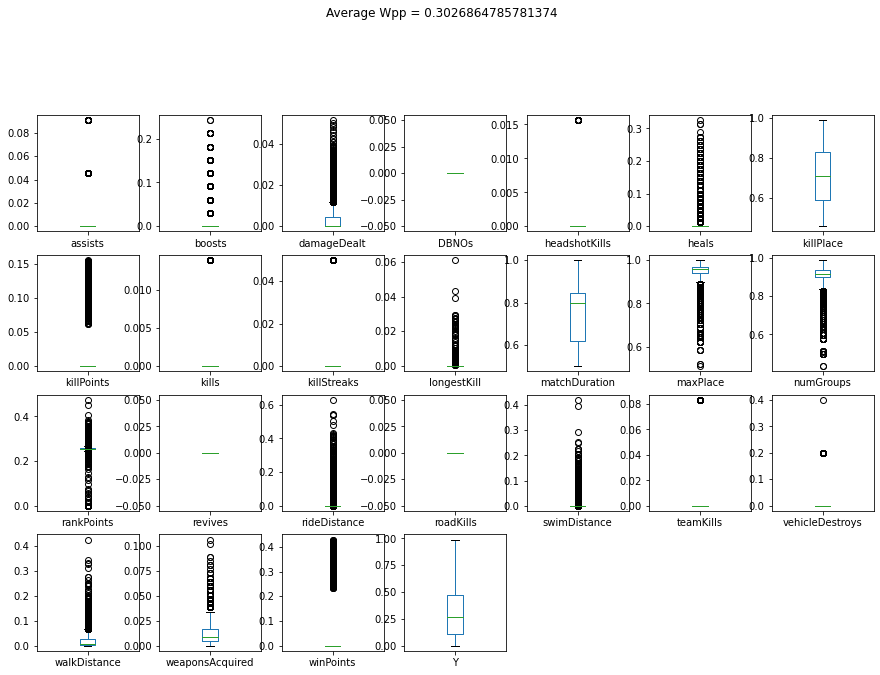

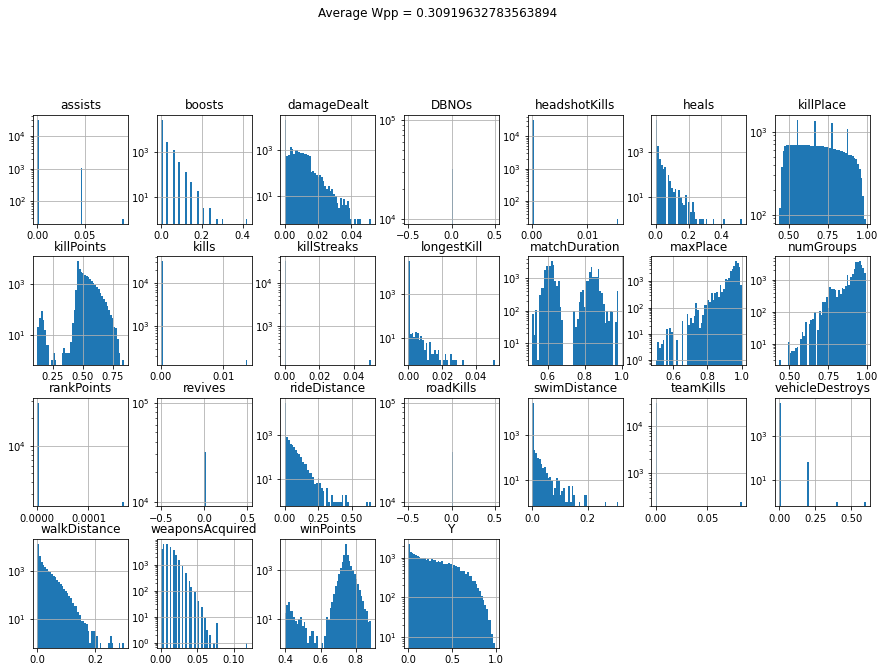

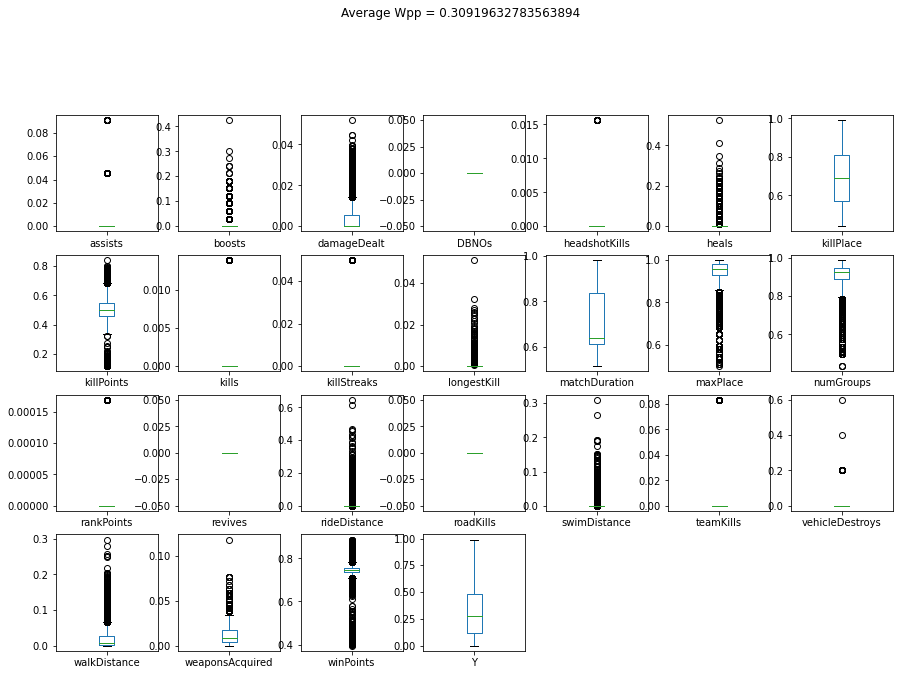

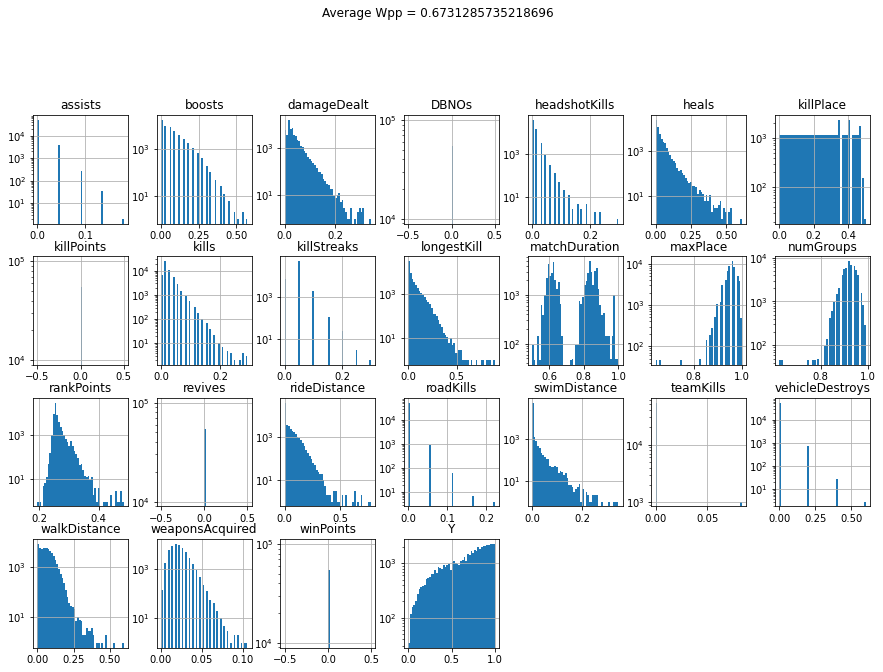

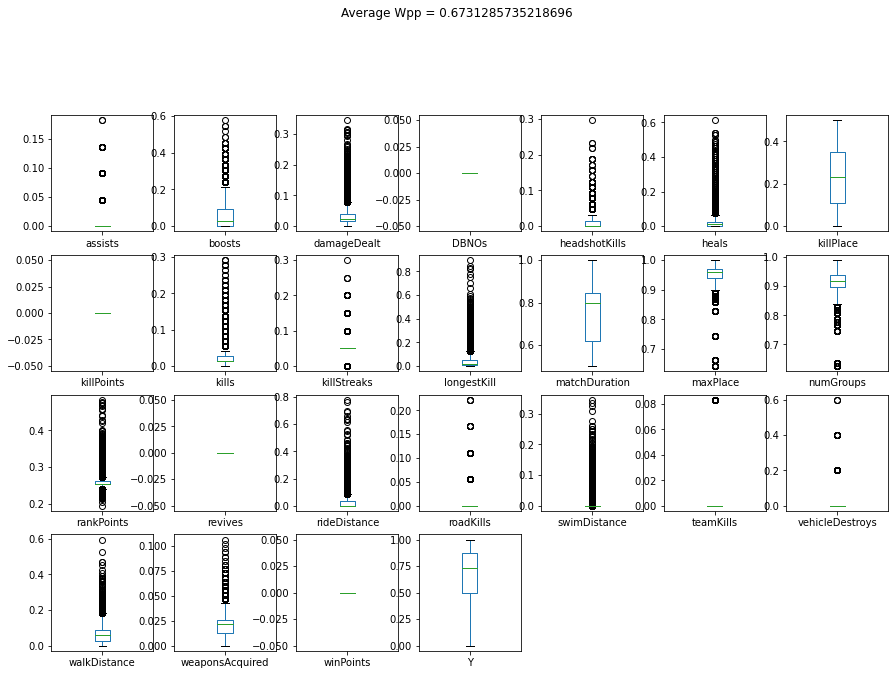

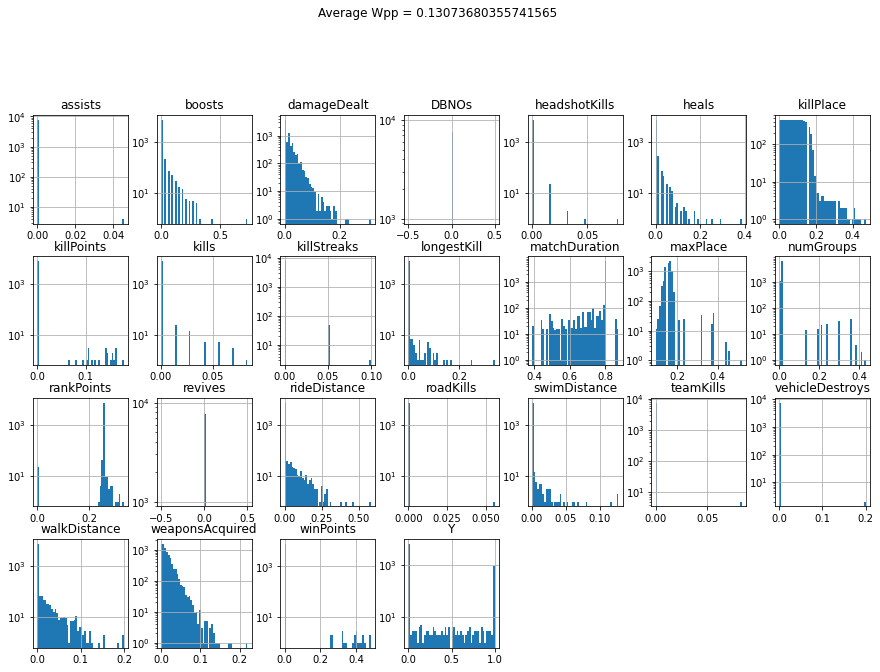

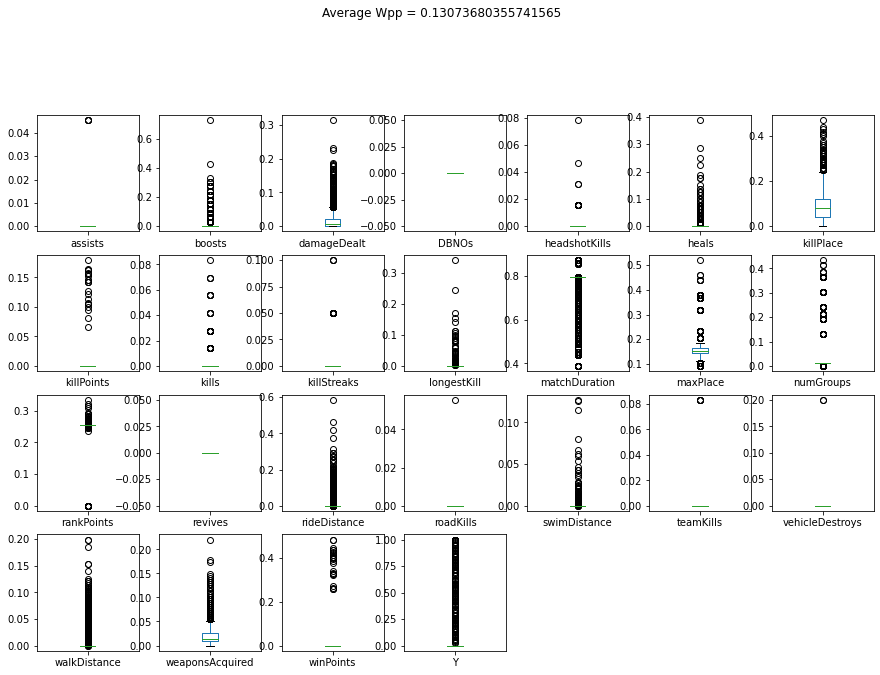

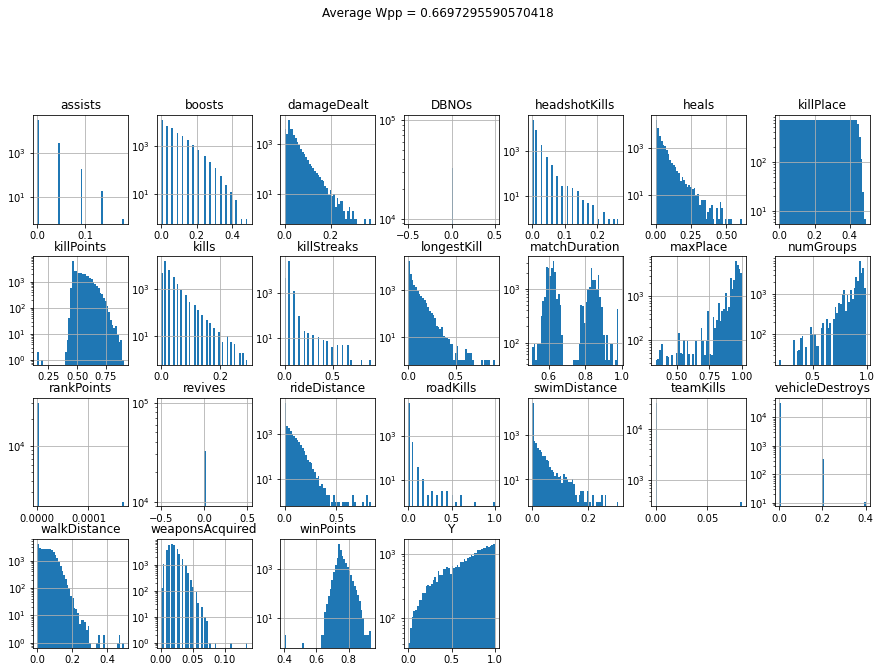

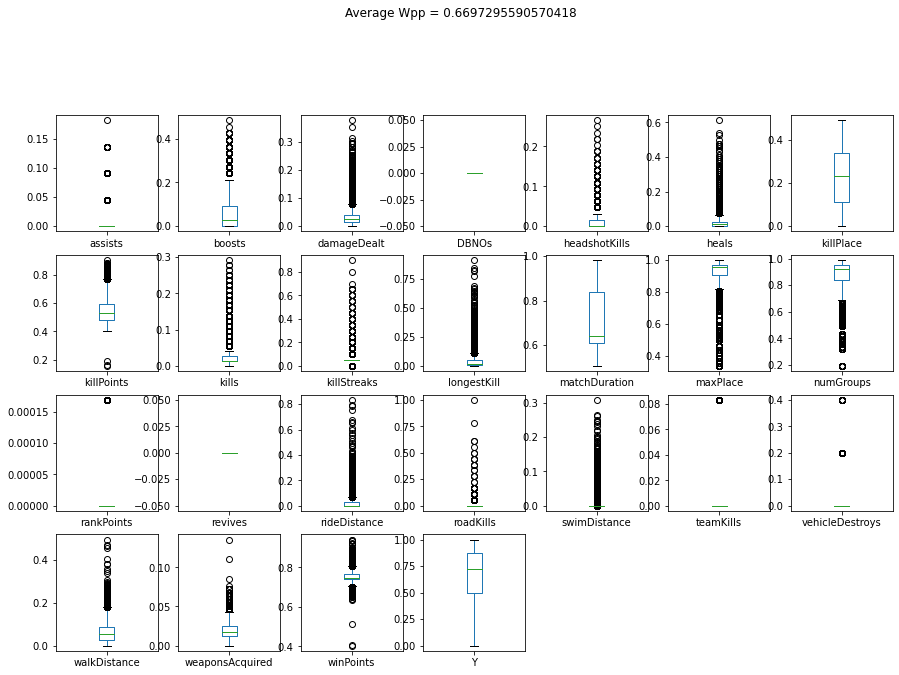

solo_fpp


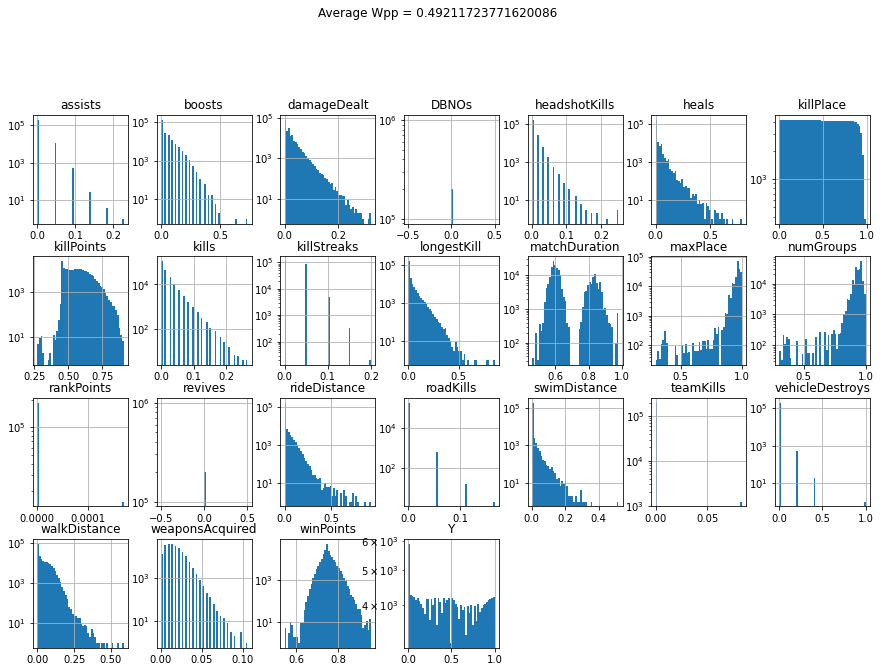

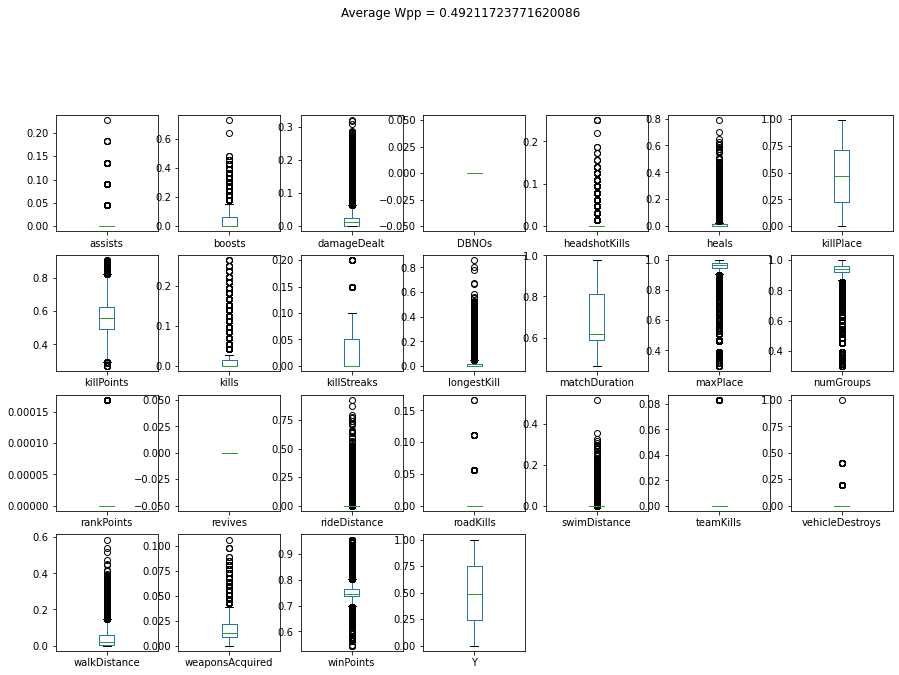

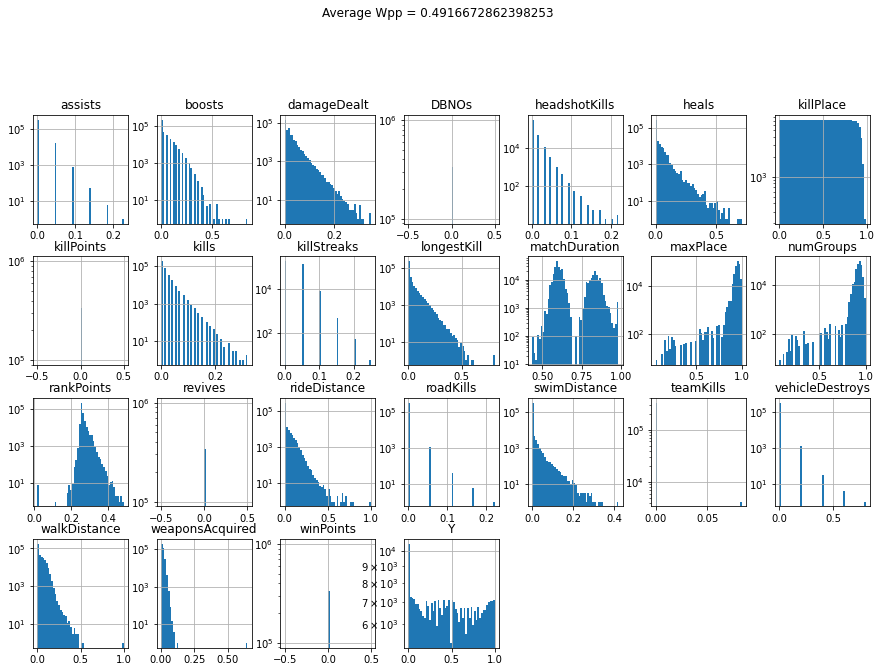

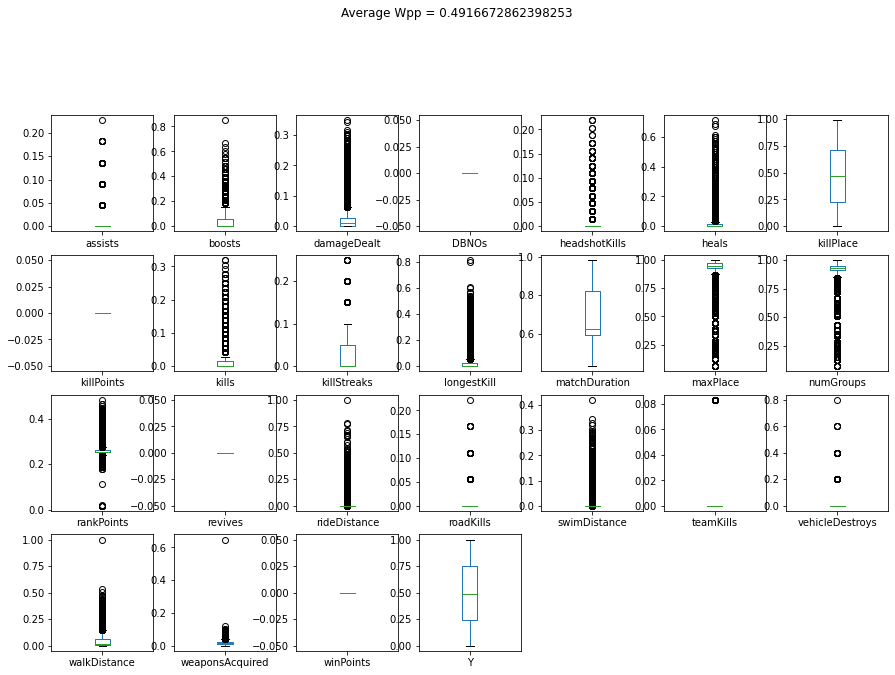

squad


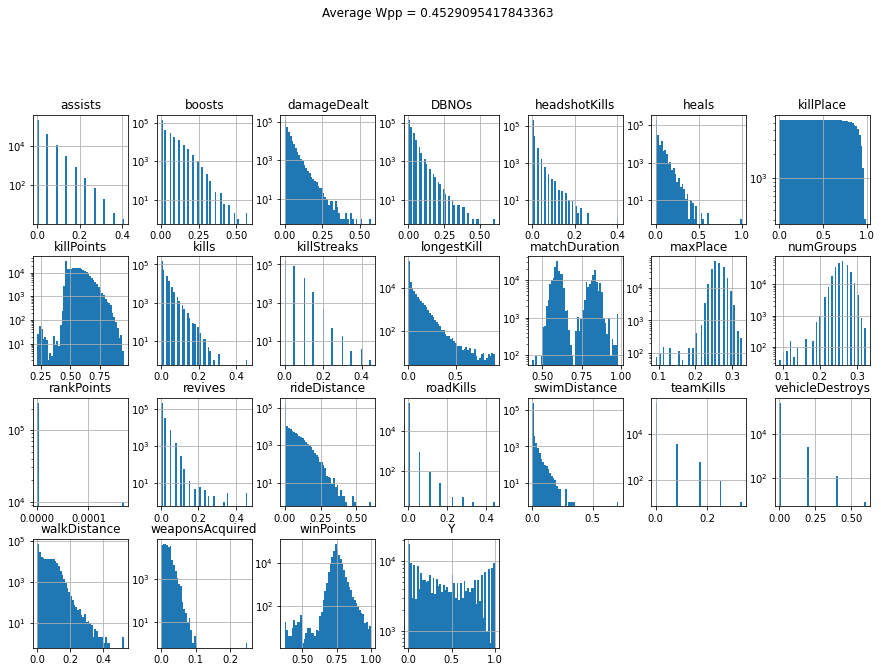

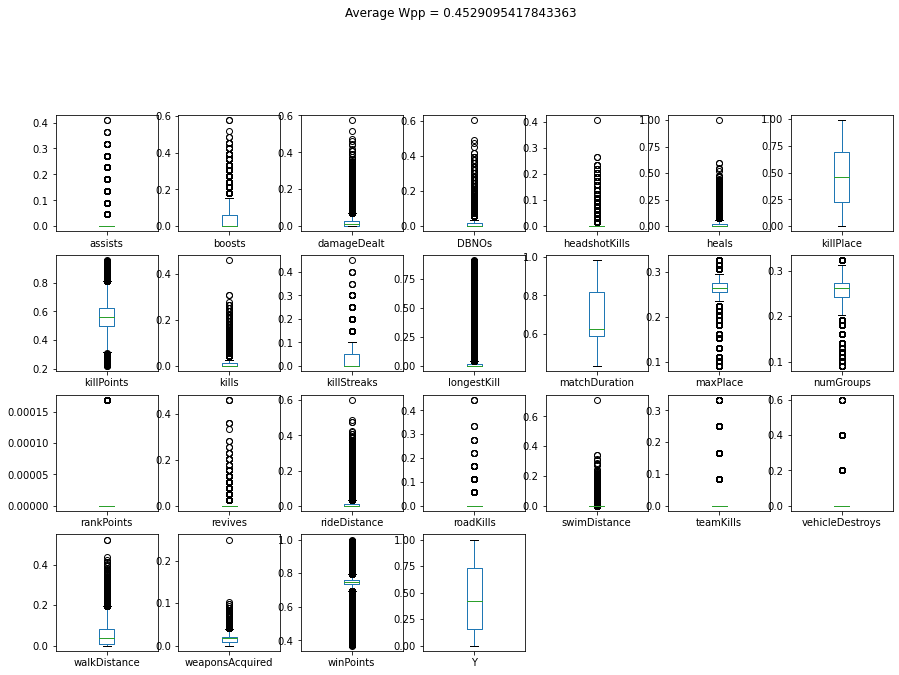

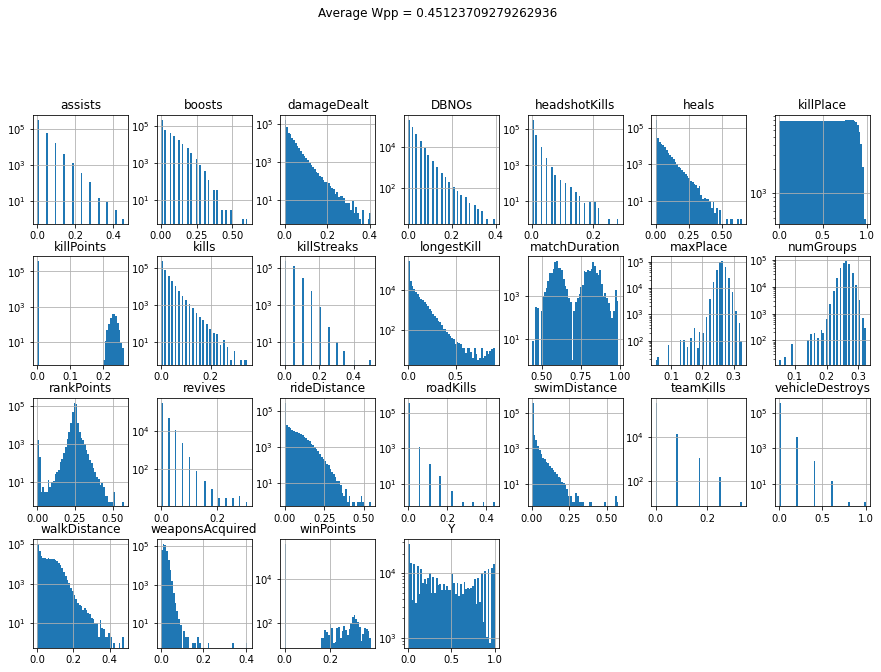

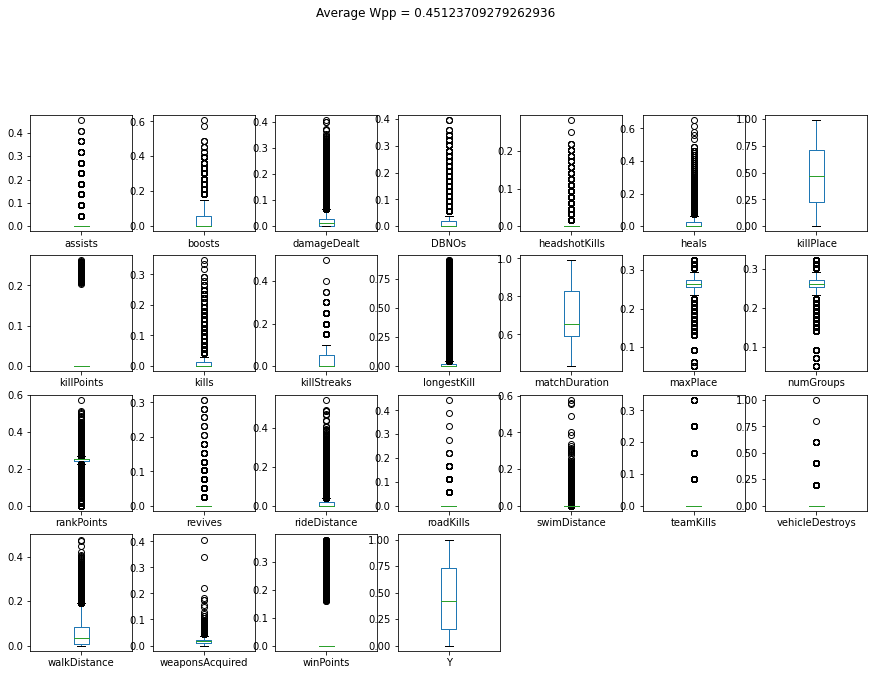

squad_fpp


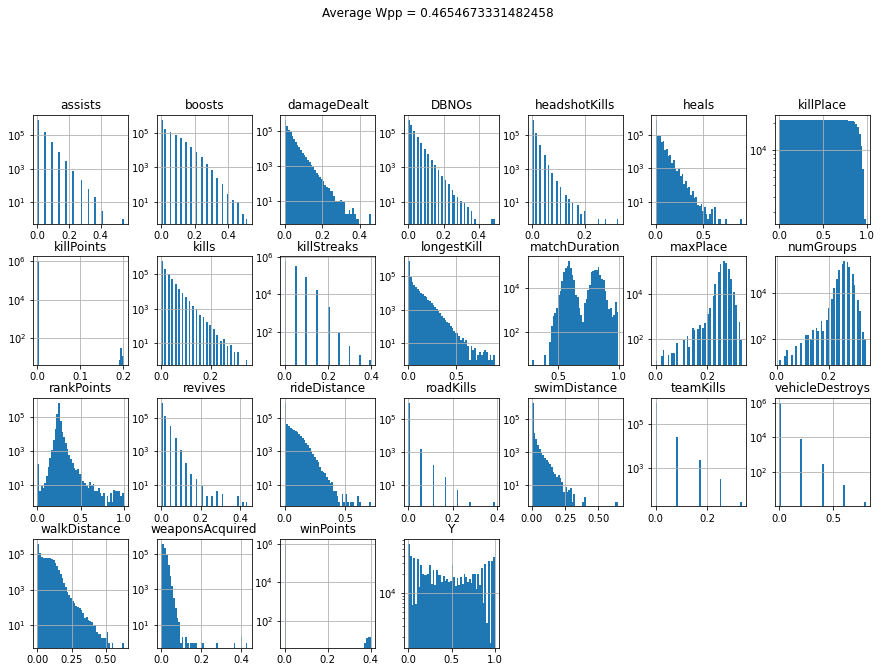

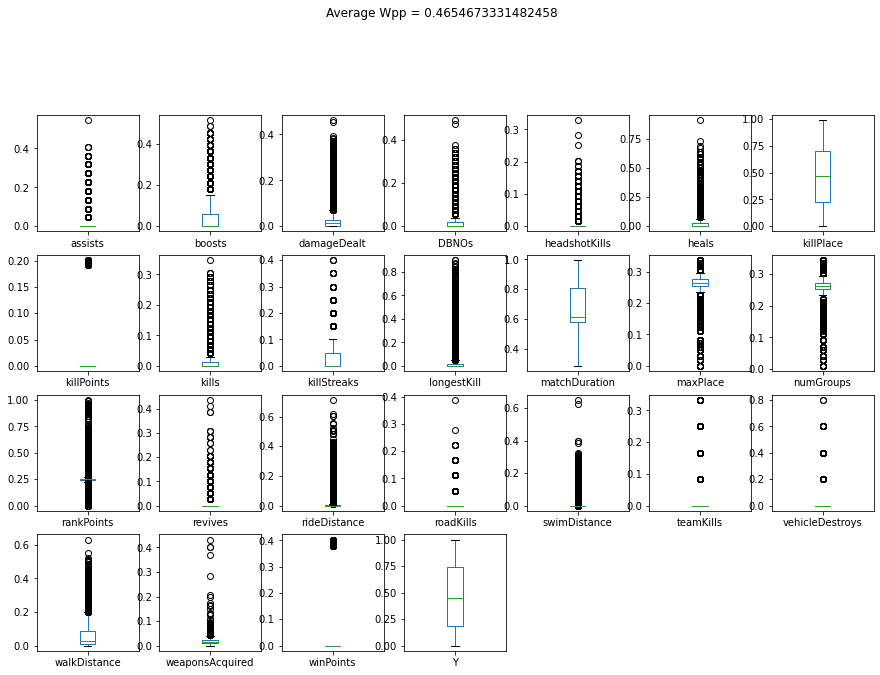

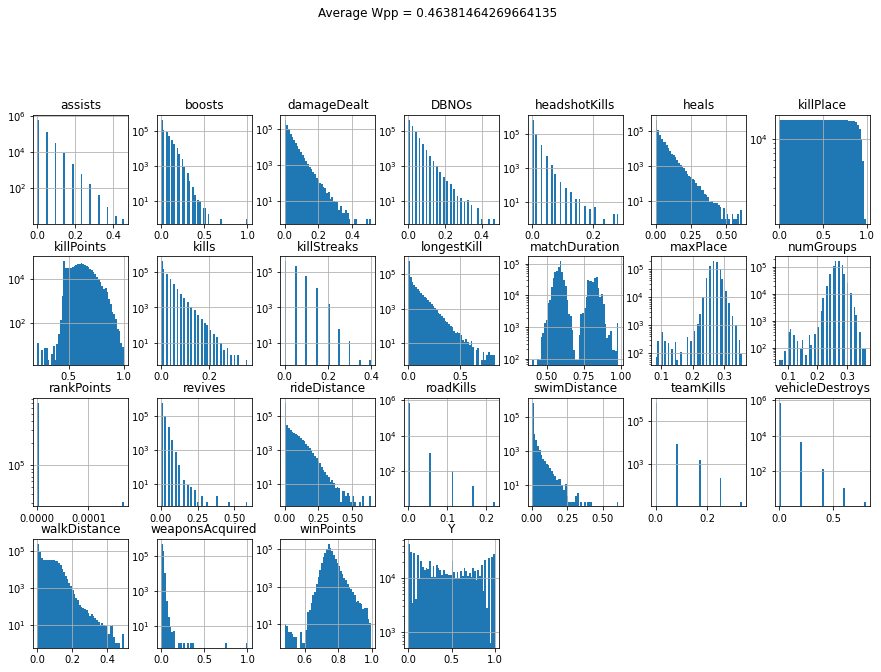

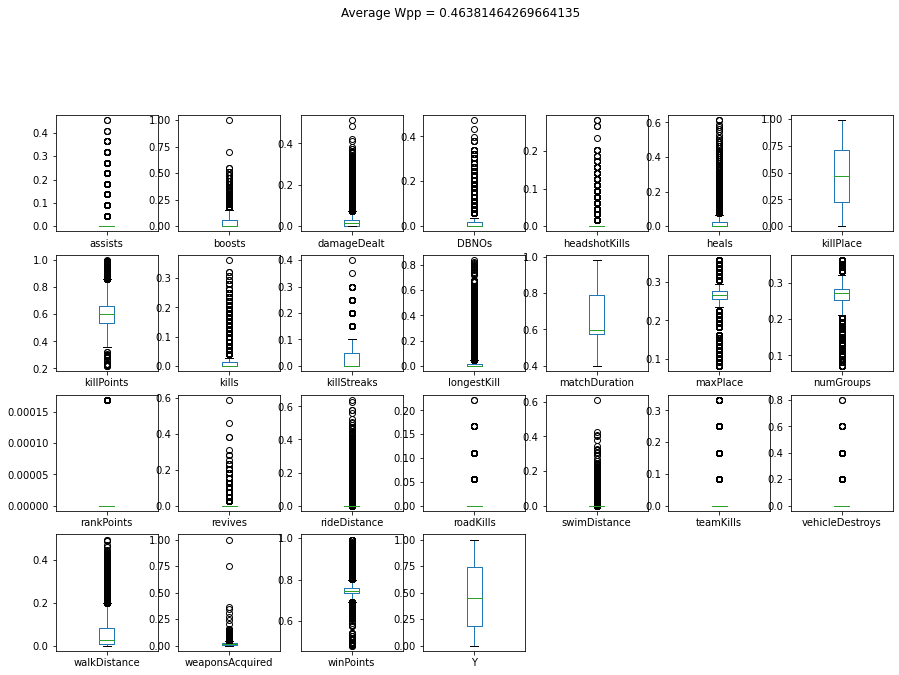

In [214]:
for index in range(len(allTypes)):
    
    name = names[index]
    n_clusters = best_n_clusters[index]
    single_type = allTypes[index].copy()
    
    single_y = single_type["winPlacePerc"]
    single_X = single_type.drop(["winPlacePerc"],axis=1)
    single_X_temp = single_X.drop(["matchType"],axis=1)
    single_y_temp = pd.DataFrame({"Y": single_y}) 
    
    kmeans.n_clusters = n_clusters
    kmeans.fit(single_X_temp)
    print(name)
    plot_distributions(single_X_temp,single_y_temp,kmeans,n_clusters)

#### View the nearest points

In [249]:
for index in range(len(allTypes)):
    
    name = names[index]
    n_clusters = best_n_clusters[index]
    single_type = allTypes[index].copy()

    single_y = single_type["winPlacePerc"]
    single_X = single_type.drop(["winPlacePerc"],axis=1)
    single_X_temp = single_X.drop(["matchType"],axis=1)
    single_y_temp = pd.DataFrame({"Y": single_y}) 
    
    kmeans.n_clusters = n_clusters
    kmeans.fit(single_X_temp)
    print(name)
    closest_summary = get_closest(single_X_temp,kmeans,single_y_temp,n_clusters)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        display(closest_summary)

crashfpp


assists    boosts  damageDealt  DBNOs  headshotKills   heals  killPlace  \
3136      0.0  0.060606     0.000672    0.0            0.0  0.0125       0.22   
1656      0.0  0.000000     0.009027    0.0            0.0  0.0000       0.69   

      killPoints     kills  killStreaks  longestKill  matchDuration  maxPlace  \
3136         0.0  0.013889         0.05      0.00343       0.360741  0.459184   
1656         0.0  0.000000         0.00      0.00000       0.363118  0.469388   

      numGroups  rankPoints  revives  rideDistance  roadKills  swimDistance  \
3136   0.444444    0.253933      0.0      0.061803   0.055556           0.0   
1656   0.454545    0.253933      0.0      0.008020   0.000000           0.0   

      teamKills  vehicleDestroys  walkDistance  weaponsAcquired  winPoints  \
3136        0.0              0.0      0.038262         0.008475        0.0   
1656        0.0              0.0      0.024042         0.004237        0.0   

           Y  averageWpp  
3136  0.8478    0.650907  
1656  0.2340    0.281412

crashtpp


assists    boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
241      0.0  0.000000     0.000000    0.0            0.0  0.000       0.56   
268      0.0  0.060606     0.015115    0.0            0.0  0.025       0.20   

     killPoints     kills  killStreaks  longestKill  matchDuration  maxPlace  \
241         0.0  0.000000         0.00     0.000000       0.375951  0.357143   
268         0.0  0.013889         0.05     0.003988       0.375951  0.357143   

     numGroups  rankPoints   revives  rideDistance  roadKills  swimDistance  \
241   0.323232    0.253933  0.000000      0.009349   0.000000           0.0   
268   0.323232    0.253933  0.025641      0.045247   0.055556           0.0   

     teamKills  vehicleDestroys  walkDistance  weaponsAcquired  winPoints  \
241        0.0              0.0      0.020244         0.004237        0.0   
268        0.0              0.0      0.074709         0.016949        0.0   

          Y  averageWpp  
241  0.3056    0.317374  
268  0.8611    0.642030

duo


assists    boosts  damageDealt  DBNOs  headshotKills   heals  \
41152       0.0  0.030303     0.002786    0.0            0.0  0.0125   
269351      0.0  0.060606     0.005387    0.0            0.0  0.0125   

        killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  \
41152        0.46     0.00000    0.0          0.0          0.0       0.761882   
269351       0.47     0.53871    0.0          0.0          0.0       0.667300   

        maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
41152   0.459184   0.434343    0.252918      0.0      0.000000        0.0   
269351  0.469388   0.444444    0.000000      0.0      0.014606        0.0   

        swimDistance  teamKills  vehicleDestroys  walkDistance  \
41152            0.0        0.0              0.0      0.043134   
269351           0.0        0.0              0.0      0.050543   

        weaponsAcquired  winPoints       Y  averageWpp  
41152          0.016949   0.000000  0.6304    0.479922  
269351         0.029661   0.725286  0.5957    0.487404

duo_fpp


assists    boosts  damageDealt  DBNOs  headshotKills   heals  \
975228      0.0  0.030303     0.003073    0.0            0.0  0.0125   
935115      0.0  0.030303     0.002096    0.0            0.0  0.0375   

        killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  \
975228       0.47    0.000000    0.0          0.0          0.0       0.664924   
935115       0.45    0.560369    0.0          0.0          0.0       0.673479   

        maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
975228  0.469388   0.454545    0.255625      0.0      0.000000        0.0   
935115  0.459184   0.454545    0.000000      0.0      0.028617        0.0   

        swimDistance  teamKills  vehicleDestroys  walkDistance  \
975228      0.000000        0.0              0.0      0.059697   
935115      0.013455        0.0              0.0      0.045345   

        weaponsAcquired  winPoints       Y  averageWpp  
975228         0.021186   0.000000  0.6809    0.485393  
935115         0.012712   0.743666  0.6522    0.486434

flarefpp


assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
652      0.0  0.000000     0.002541  0.000000            0.0  0.0000   
99       0.0  0.030303     0.008789  0.018868            0.0  0.0375   

     killPlace  killPoints     kills  killStreaks  longestKill  matchDuration  \
652       0.65         0.0  0.000000         0.00     0.000000       0.824144   
99        0.23         0.0  0.013889         0.05     0.024269       0.824144   

     maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
652   0.22449   0.222222    0.253933      0.0      0.000000        0.0   
99    0.22449   0.222222    0.253933      0.0      0.032277        0.0   

     swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
652           0.0        0.0              0.0      0.046315         0.012712   
99            0.0        0.0              0.0      0.091815         0.012712   

     winPoints       Y  averageWpp  
652        0.0  0.3043    0.258539  
99         0.0  0.8696    0.616455

flaretpp


assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
205   0.000000  0.000000     0.000000  0.000000            0.0  0.0125   
2018  0.000000  0.060606     0.015115  0.018868            0.0  0.0625   
339   0.045455  0.060606     0.015810  0.000000            0.0  0.0375   

      killPlace  killPoints     kills  killStreaks  longestKill  \
205        0.68    0.000000  0.000000         0.00     0.000000   
2018       0.23    0.000000  0.013889         0.05     0.042998   
339        0.37    0.460829  0.000000         0.00     0.000000   

      matchDuration  maxPlace  numGroups  rankPoints   revives  rideDistance  \
205        0.829373  0.234694   0.242424    0.253933  0.000000      0.017777   
2018       0.834601  0.224490   0.222222    0.253933  0.025641      0.035544   
339        0.792776  0.234694   0.232323    0.000000  0.000000      0.049226   

      roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
205         0.0      0.000000        0.0              0.0      0.036932   
2018        0.0      0.000000        0.0              0.0      0.076649   
339         0.0      0.004306        0.0              0.0      0.108262   

      weaponsAcquired  winPoints       Y  averageWpp  
205          0.004237   0.000000  0.2083    0.240825  
2018         0.025424   0.000000  0.4348    0.625316  
339          0.042373   0.745156  1.0000    0.434976

normal_duo


assists    boosts  damageDealt     DBNOs  headshotKills  heals  \
31   0.045455  0.030303     0.022294  0.000000        0.00000    0.0   
172  0.045455  0.000000     0.075771  0.056604        0.03125    0.0   

     killPlace  killPoints     kills  killStreaks  longestKill  matchDuration  \
31        0.15    0.000000  0.013889         0.05     0.004806       0.462452   
172       0.09    0.460829  0.055556         0.10     0.015174       0.537072   

     maxPlace  numGroups  rankPoints   revives  rideDistance  roadKills  \
31   0.183673   0.191919    0.253933  0.025641      0.033235        0.0   
172  0.051020   0.060606    0.000000  0.000000      0.000000        0.0   

     swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
31            0.0        0.0              0.0      0.036241         0.004237   
172           0.0        0.0              0.0      0.057137         0.097458   

     winPoints       Y  averageWpp  
31    0.000000  0.3684    0.512373  
172   0.745156  0.0000    0.515814

normal_duo_fpp


assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
3583      0.0  0.060606     0.018606  0.000000            0.0  0.0125   
4098      0.0  0.090909     0.015068  0.018868            0.0  0.0250   

      killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  \
3583       0.26    0.460829    0.0          0.0          0.0       0.825570   
4098       0.20    0.000000    0.0          0.0          0.0       0.710076   

      maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
3583  0.265306   0.272727    0.000000      0.0      0.016979        0.0   
4098  0.163265   0.171717    0.253933      0.0      0.028519        0.0   

      swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
3583      0.007073        0.0              0.0      0.086230         0.016949   
4098      0.000000        0.0              0.0      0.081808         0.021186   

      winPoints       Y  averageWpp  
3583   0.745156  0.5185    0.504378  
4098   0.000000  0.4706    0.516002

normal_solo


assists    boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
321  0.136364  0.000000     0.109175    0.0       0.000000    0.0       0.11   
150  0.000000  0.060606     0.014403    0.0       0.015625    0.0       0.06   

     killPoints     kills  killStreaks  longestKill  matchDuration  maxPlace  \
321    0.460829  0.125000         0.10     0.031261       0.425380  0.112245   
150    0.000000  0.013889         0.05     0.062230       0.691065  0.214286   

     numGroups  rankPoints  revives  rideDistance  roadKills  swimDistance  \
321   0.101010    0.000000      0.0           0.0        0.0           0.0   
150   0.222222    0.253933      0.0           0.0        0.0           0.0   

     teamKills  vehicleDestroys  walkDistance  weaponsAcquired  winPoints  \
321        0.0              0.0      0.000000         0.084746   0.745156   
150        0.0              0.0      0.085493         0.025424   0.000000   

          Y  averageWpp  
321  0.0833    0.584239  
150  0.6364    0.514918

normal_solo_fpp


assists    boosts  damageDealt  DBNOs  headshotKills   heals  killPlace  \
162  0.090909  0.000000     0.120919    0.0       0.015625  0.0000       0.17   
889  0.136364  0.030303     0.134114    0.0       0.015625  0.0375       0.12   

     killPoints     kills  killStreaks  longestKill  matchDuration  maxPlace  \
162    0.460829  0.069444         0.05     0.052815       0.363593  0.183673   
889    0.000000  0.111111         0.05     0.099177       0.363593  0.183673   

     numGroups  rankPoints  revives  rideDistance  roadKills  swimDistance  \
162   0.141414    0.000000      0.0           0.0        0.0           0.0   
889   0.141414    0.253933      0.0           0.0        0.0           0.0   

     teamKills  vehicleDestroys  walkDistance  weaponsAcquired  winPoints  \
162        0.0              0.0      0.012808         0.118644   0.745156   
889        0.0              0.0      0.008417         0.080508   0.000000   

          Y  averageWpp  
162  0.1579    0.550139  
889  0.3684    0.557958

normal_squad


assists  boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
455  0.045455     0.0     0.047672    0.0       0.015625    0.0       0.24   
435  0.090909     0.0     0.119377    0.0       0.015625    0.0       0.13   

     killPoints     kills  killStreaks  longestKill  matchDuration  maxPlace  \
455    0.000000  0.041667         0.05     0.066645       0.609316  0.061224   
435    0.460829  0.125000         0.10     0.086581       0.410171  0.040816   

     numGroups  rankPoints  revives  rideDistance  roadKills  swimDistance  \
455   0.070707    0.253933      0.0           0.0        0.0           0.0   
435   0.050505    0.000000      0.0           0.0        0.0           0.0   

     teamKills  vehicleDestroys  walkDistance  weaponsAcquired  winPoints  \
455        0.0              0.0      0.051241         0.055085   0.000000   
435        0.0              0.0      0.032331         0.131356   0.745156   

          Y  averageWpp  
455  0.2857    0.519323  
435  0.8000    0.537962

normal_squad_fpp


assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
16113      0.0  0.060606     0.023821  0.018868            0.0  0.0375   
2942       0.0  0.030303     0.015342  0.018868            0.0  0.0250   

       killPlace  killPoints     kills  killStreaks  longestKill  \
16113       0.30    0.000000  0.000000         0.00      0.00000   
2942        0.25    0.460829  0.013889         0.05      0.05298   

       matchDuration  maxPlace  numGroups  rankPoints  revives  rideDistance  \
16113       0.608840  0.112245   0.121212    0.253933      0.0      0.000000   
2942        0.768536  0.112245   0.121212    0.000000      0.0      0.057332   

       roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
16113        0.0           0.0        0.0              0.0      0.039527   
2942         0.0           0.0        0.0              0.0      0.021536   

       weaponsAcquired  winPoints       Y  averageWpp  
16113         0.016949   0.000000  0.3333    0.503973  
2942          0.016949   0.745156  0.0000    0.500290

solo


assists    boosts  damageDealt  DBNOs  headshotKills   heals  \
143723      0.0  0.000000     0.000000    0.0            0.0  0.0000   
110633      0.0  0.000000     0.000000    0.0            0.0  0.0000   
151838      0.0  0.060606     0.015115    0.0            0.0  0.0375   
171289      0.0  0.000000     0.013452    0.0            0.0  0.0000   
146098      0.0  0.060606     0.025030    0.0            0.0  0.0125   

        killPlace  killPoints     kills  killStreaks  longestKill  \
143723       0.73    0.000000  0.000000         0.00     0.000000   
110633       0.71    0.495853  0.000000         0.00     0.000000   
151838       0.24    0.000000  0.013889         0.05     0.014488   
171289       0.08    0.000000  0.000000         0.00     0.000000   
146098       0.22    0.558986  0.013889         0.05     0.003742   

        matchDuration  maxPlace  numGroups  rankPoints  revives  rideDistance  \
143723       0.734316  0.959184   0.919192    0.252918      0.0           0.0   
110633       0.748099  0.959184   0.888889    0.000000      0.0           0.0   
151838       0.734316  0.959184   0.919192    0.252918      0.0           0.0   
171289       0.765209  0.163265   0.000000    0.253933      0.0           0.0   
146098       0.660171  0.928571   0.919192    0.000000      0.0           0.0   

        roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
143723        0.0           0.0        0.0              0.0      0.010093   
110633        0.0           0.0        0.0              0.0      0.021521   
151838        0.0           0.0        0.0              0.0      0.060861   
171289        0.0           0.0        0.0              0.0      0.000000   
146098        0.0           0.0        0.0              0.0      0.076610   

        weaponsAcquired  winPoints       Y  averageWpp  
143723         0.016949   0.000000  0.2526    0.302686  
110633         0.016949   0.757576  0.3684    0.309196  
151838         0.012712   0.000000  0.7579    0.673129  
171289         0.012712   0.000000  0.0000    0.130737  
146098         0.021186   0.771485  0.7826    0.669730

solo_fpp


assists    boosts  damageDealt  DBNOs  headshotKills   heals  \
487424      0.0  0.030303     0.000000    0.0            0.0  0.0000   
526290      0.0  0.030303     0.014034    0.0            0.0  0.0125   

        killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  \
487424       0.47    0.587558    0.0          0.0          0.0       0.670627   
526290       0.49    0.000000    0.0          0.0          0.0       0.668251   

        maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
487424  0.969388   0.949495    0.000000      0.0           0.0        0.0   
526290  0.948980   0.929293    0.252918      0.0           0.0        0.0   

        swimDistance  teamKills  vehicleDestroys  walkDistance  \
487424           0.0        0.0              0.0      0.040652   
526290           0.0        0.0              0.0      0.026257   

        weaponsAcquired  winPoints       Y  averageWpp  
487424         0.012712   0.753602  0.7917    0.492117  
526290         0.021186   0.000000  0.6915    0.491667

squad


assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
115430      0.0  0.060606     0.005703  0.000000            0.0  0.0000   
528282      0.0  0.030303     0.007618  0.018868            0.0  0.0125   

        killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  \
115430       0.46    0.548848    0.0          0.0          0.0       0.672053   
528282       0.48    0.000000    0.0          0.0          0.0       0.681559   

        maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
115430  0.265306   0.272727    0.000000      0.0           0.0        0.0   
528282  0.244898   0.252525    0.255794      0.0           0.0        0.0   

        swimDistance  teamKills  vehicleDestroys  walkDistance  \
115430           0.0        0.0              0.0      0.071451   
528282           0.0        0.0              0.0      0.039527   

        weaponsAcquired  winPoints       Y  averageWpp  
115430         0.016949   0.741182  0.8889    0.452910  
528282         0.021186   0.000000  0.6400    0.451237

squad_fpp


assists    boosts  damageDealt     DBNOs  headshotKills   heals  \
243328      0.0  0.030303     0.024909  0.018868            0.0  0.0250   
194385      0.0  0.030303     0.004098  0.000000            0.0  0.0125   

        killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  \
243328       0.46    0.000000    0.0          0.0          0.0       0.679658   
194385       0.49    0.604608    0.0          0.0          0.0       0.658745   

        maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
243328  0.285714   0.262626    0.252918      0.0           0.0        0.0   
194385  0.265306   0.272727    0.000000      0.0           0.0        0.0   

        swimDistance  teamKills  vehicleDestroys  walkDistance  \
243328           0.0        0.0              0.0      0.061443   
194385           0.0        0.0              0.0      0.055663   

        weaponsAcquired  winPoints       Y  averageWpp  
243328         0.021186   0.000000  0.7586    0.465467  
194385         0.008475   0.735221  0.6296    0.463815

#### View the centroids 

In [250]:
for index in range(len(allTypes)):
    
    name = names[index]
    n_clusters = best_n_clusters[index]
    single_type = allTypes[index].copy()
    
    single_y = single_type["winPlacePerc"]
    single_X = single_type.drop(["winPlacePerc"],axis=1)
    single_X_temp = single_X.drop(["matchType"],axis=1)
    single_y_temp = pd.DataFrame({"Y": single_y}) 
    
    kmeans.n_clusters = n_clusters
    kmeans.fit(single_X_temp)
    print(name)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        display(get_average(single_X_temp,kmeans,n_clusters,single_y_temp))

crashfpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
6287  0.013520  0.050625     0.022407  0.014593   2.257261e-03  0.022312   
6288  0.003456  0.016359     0.003960  0.001913  -3.252607e-18  0.007173   

      killPlace  killPoints         kills   killStreaks   longestKill  \
6287   0.221411         0.0  2.068971e-02  4.940693e-02  7.813479e-03   
6288   0.678520         0.0  2.255141e-17  4.857226e-17  1.994932e-17   

      matchDuration  maxPlace  numGroups  rankPoints   revives  rideDistance  \
6287       0.361194  0.447273   0.425769    0.253933  0.002355      0.070442   
6288       0.361085  0.471460   0.447627    0.253933  0.000556      0.020125   

         roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
6287  3.323533e-02      0.000305   0.005981         0.027129      0.029140   
6288  3.816392e-17      0.000512   0.006224         0.003001      0.022463   

      weaponsAcquired  winPoints  averageWpp  
6287         0.007417        0.0    0.650907  
6288         0.005358        0.0    0.281412

crashtpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
371  0.006313  0.017508     0.004685  0.001572       0.000087  0.007569   
372  0.015469  0.048548     0.025512  0.016102       0.001636  0.015707   

     killPlace  killPoints     kills  killStreaks  longestKill  matchDuration  \
371   0.573778         0.0  0.000231     0.000833     0.000111       0.365339   
372   0.186073         0.0  0.023560     0.055236     0.009732       0.361831   

     maxPlace  numGroups  rankPoints   revives  rideDistance     roadKills  \
371  0.386621   0.371661    0.253933  0.000427      0.015627  2.775558e-17   
372  0.366278   0.352583    0.253933  0.001074      0.047435  3.955788e-02   

     swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
371      0.000117   0.003241         0.001111      0.022984         0.005932   
372      0.000039   0.003054         0.025131      0.032906         0.008120   

     winPoints  averageWpp  
371        0.0    0.317374  
372        0.0    0.642030

duo


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
313591  0.009278  0.034605     0.018765  0.011544       0.003278  0.016999   
313592  0.010417  0.033931     0.019625  0.011481       0.003392  0.016314   

        killPlace  killPoints     kills  killStreaks  longestKill  \
313591   0.469445    0.000939  0.012535     0.027103     0.020435   
313592   0.455402    0.533653  0.012733     0.027521     0.020085   

        matchDuration  maxPlace  numGroups  rankPoints   revives  \
313591       0.728074  0.468702   0.453503    0.253211  0.003933   
313592       0.705335  0.462069   0.444995    0.000010  0.003831   

        rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
313591      0.019212   0.000226      0.001241   0.002676         0.002286   
313592      0.017297   0.000254      0.001286   0.001382         0.001762   

        walkDistance  weaponsAcquired  winPoints  averageWpp  
313591      0.043451         0.015707   0.002107    0.479922  
313592      0.043804         0.015844   0.749190    0.487404

duo_fpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
996691  0.009497  0.033361     0.019814  0.011910       0.003512  0.017078   
996692  0.010292  0.031593     0.020260  0.011784       0.003521  0.015887   

        killPlace    killPoints     kills  killStreaks  longestKill  \
996691   0.465323 -1.165179e-13  0.012842     0.028275     0.020831   
996692   0.468037  5.700422e-01  0.012894     0.028433     0.019869   

        matchDuration  maxPlace  numGroups  rankPoints   revives  \
996691       0.696170  0.465883   0.453184    0.256219  0.004200   
996692       0.673049  0.467522   0.457131    0.000008  0.004073   

        rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
996691      0.014343   0.000116      0.001114   0.001995         0.001320   
996692      0.011995   0.000107      0.001060   0.001025         0.000939   

        walkDistance  weaponsAcquired     winPoints  averageWpp  
996691      0.043414         0.015186 -3.030909e-13    0.485393  
996692      0.041947         0.014975  7.493163e-01    0.486434

flarefpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
718  0.003433  0.009155     0.005882  0.003135   8.239937e-18  0.007062   
719  0.020554  0.066166     0.033791  0.028521   5.935078e-03  0.036531   

     killPlace  killPoints         kills   killStreaks   longestKill  \
718   0.634230         0.0 -5.204170e-18 -3.469447e-17 -1.387779e-17   
719   0.210129         0.0  2.282515e-02  5.038760e-02  4.258805e-02   

     matchDuration  maxPlace  numGroups  rankPoints   revives  rideDistance  \
718       0.830417  0.231118   0.230706    0.253933  0.002479      0.016955   
719       0.835486  0.215841   0.214731    0.253933  0.008945      0.045815   

        roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
718  7.047314e-19      0.000470   0.003525         0.001208      0.028050   
719  8.613264e-04      0.001065   0.003876         0.007235      0.083783   

     weaponsAcquired  winPoints  averageWpp  
718         0.013403        0.0    0.258539  
719         0.023705        0.0    0.616455

flaretpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
2505  0.004128  0.012110     0.005362  0.003342  -6.071532e-18  0.008163   
2506  0.021266  0.070671     0.032783  0.028976   5.943080e-03  0.038638   
2507  0.014085  0.039052     0.021061  0.015413   3.025968e-03  0.018926   

      killPlace    killPoints         kills   killStreaks   longestKill  \
2505   0.665050  1.040834e-16 -1.734723e-18  1.387779e-17 -6.938894e-18   
2506   0.219116  1.179612e-16  2.363591e-02  4.968750e-02  4.822058e-02   
2507   0.363275  4.608295e-01  1.183490e-02  2.711268e-02  2.425237e-02   

      matchDuration  maxPlace  numGroups    rankPoints   revives  \
2505       0.829018  0.242609   0.240002  2.539333e-01  0.002399   
2506       0.828869  0.242055   0.239241  2.539333e-01  0.009638   
2507       0.807592  0.195458   0.195511  5.551115e-17  0.005869   

      rideDistance     roadKills  swimDistance  teamKills  vehicleDestroys  \
2505      0.019817 -1.301043e-18      0.000646   0.004390         0.001453   
2506      0.059196  1.339286e-03      0.003103   0.005580         0.011964   
2507      0.038692 -1.084202e-19      0.000880   0.001174         0.002113   

      walkDistance  weaponsAcquired     winPoints  averageWpp  
2505      0.030794         0.013493  2.775558e-17    0.240825  
2506      0.079306         0.022866  1.387779e-17    0.625316  
2507      0.061404         0.019948  7.451565e-01    0.434976

normal_duo


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
199  0.033243  0.030303     0.053915  0.033512       0.012360  0.014552   
200  0.062328  0.033747     0.073351  0.052887       0.015507  0.044602   

     killPlace    killPoints     kills  killStreaks  longestKill  \
199   0.138358 -2.775558e-16  0.043947     0.047761     0.053718   
200   0.076212  4.608295e-01  0.057870     0.046970     0.046217   

     matchDuration  maxPlace  numGroups  rankPoints   revives  rideDistance  \
199       0.419577  0.129455   0.136439    0.253933  0.012246      0.032690   
200       0.603522  0.064007   0.071472    0.000015  0.008159      0.033443   

     roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
199   0.001658 -1.626303e-19   0.004975          0.00597      0.038434   
200   0.001684  3.695535e-04   0.001894          0.00303      0.051375   

     weaponsAcquired     winPoints  averageWpp  
199         0.031811  2.775558e-16    0.512373  
200         0.051778  7.451565e-01    0.515814

normal_duo_fpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
5489  0.023084  0.053071     0.033067  0.014534       0.006121  0.028937   
5490  0.037241  0.047271     0.049363  0.020709       0.010004  0.028569   

      killPlace    killPoints     kills  killStreaks  longestKill  \
5489   0.265517  4.608295e-01  0.021994     0.031534     0.035103   
5490   0.202783 -8.326673e-16  0.037832     0.039459     0.035754   

      matchDuration  maxPlace  numGroups    rankPoints   revives  \
5489       0.772725  0.263572   0.269910  6.865914e-07  0.004537   
5490       0.693585  0.202095   0.206859  2.539333e-01  0.004576   

      rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
5489      0.044541   0.000691      0.002187   0.001060         0.003788   
5490      0.040346   0.000217      0.001498   0.003207         0.003012   

      walkDistance  weaponsAcquired     winPoints  averageWpp  
5489      0.064350         0.025537  7.451565e-01    0.504378  
5490      0.059492         0.033910 -3.330669e-16    0.516002

normal_solo


assists    boosts  damageDealt  DBNOs  headshotKills     heals  \
326  0.103044  0.011244     0.146779    0.0       0.033442  0.033993   
327  0.029437  0.052525     0.066416    0.0       0.022768  0.024167   

     killPlace    killPoints     kills  killStreaks  longestKill  \
326   0.098733  4.608295e-01  0.127891     0.081222     0.091319   
327   0.092857  4.440892e-16  0.054630     0.042857     0.045811   

     matchDuration  maxPlace  numGroups    rankPoints  revives  rideDistance  \
326       0.446282  0.170376   0.100827  1.804112e-16      0.0      0.009398   
327       0.634986  0.172109   0.167484  2.539333e-01      0.0      0.010663   

     roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
326        0.0      0.000038   0.008673              0.0      0.027096   
327        0.0      0.001528   0.000794              0.0      0.056097   

     weaponsAcquired     winPoints  averageWpp  
326         0.091456  7.451565e-01    0.584239  
327         0.047982 -2.220446e-16    0.514918

normal_solo_fpp


assists    boosts  damageDealt  DBNOs  headshotKills     heals  \
1682  0.081772  0.020331     0.109955    0.0       0.028509  0.029257   
1683  0.091918  0.023139     0.123239    0.0       0.032291  0.030119   

      killPlace    killPoints     kills  killStreaks  longestKill  \
1682   0.121088  4.608295e-01  0.096867     0.071255     0.048964   
1683   0.106648 -4.440892e-16  0.109816     0.070311     0.060603   

      matchDuration  maxPlace  numGroups  rankPoints  revives  rideDistance  \
1682       0.414337  0.219172   0.167423    0.000004      0.0      0.010842   
1683       0.417664  0.178520   0.134912    0.253933      0.0      0.009768   

      roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
1682   0.000071       0.00104   0.001387    -3.794708e-19      0.035159   
1683   0.000123       0.00105   0.004440     4.439512e-04      0.029308   

      weaponsAcquired     winPoints  averageWpp  
1682         0.068003  7.451565e-01    0.550139  
1683         0.078463 -5.551115e-17    0.557958

normal_squad


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
516  0.071674  0.027771     0.081035  0.037685       0.024132  0.026449   
517  0.073041  0.031348     0.086786  0.015485       0.025539  0.033017   

     killPlace    killPoints     kills  killStreaks  longestKill  \
516   0.259919  5.551115e-16  0.068995     0.057682     0.053481   
517   0.135172  4.608295e-01  0.071552     0.067586     0.087207   

     matchDuration  maxPlace  numGroups    rankPoints   revives  rideDistance  \
516       0.584068  0.106276   0.115304  2.539333e-01  0.007810      0.013580   
517       0.505245  0.060239   0.067712 -1.665335e-16  0.003537      0.030996   

        roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
516  1.946691e-03      0.000597   0.006963     2.695418e-03      0.033081   
517 -1.301043e-18      0.003934   0.002299    -2.602085e-18      0.048217   

     weaponsAcquired     winPoints  averageWpp  
516         0.054228 -2.775558e-17    0.519323  
517         0.057013  7.451565e-01    0.537962

normal_squad_fpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
17174  0.049642  0.043490     0.056259  0.027731       0.011637  0.036328   
17175  0.058231  0.042776     0.061536  0.034053       0.012076  0.038080   

       killPlace    killPoints     kills  killStreaks  longestKill  \
17174   0.284398  1.443290e-15  0.042255     0.047871     0.054884   
17175   0.265467  4.608295e-01  0.044881     0.047632     0.053029   

       matchDuration  maxPlace  numGroups  rankPoints   revives  rideDistance  \
17174       0.653342  0.114969   0.121575    0.253933  0.007344      0.054517   
17175       0.664455  0.106141   0.113257    0.000007  0.008256      0.050917   

       roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
17174   0.000180      0.001021   0.005554         0.007464      0.051130   
17175   0.000183      0.001010   0.003591         0.005957      0.053685   

       weaponsAcquired     winPoints  averageWpp  
17174         0.037524  3.108624e-15    0.503973  
17175         0.039479  7.451565e-01    0.500290

solo


assists    boosts  damageDealt  DBNOs  headshotKills     heals  \
181943  0.001048  0.006816     0.002962    0.0       0.000008  0.003224   
181944  0.001548  0.006784     0.003282    0.0       0.000013  0.003198   
181945  0.003804  0.060762     0.031035    0.0       0.007243  0.023685   
181946  0.000024  0.004086     0.015073    0.0       0.000072  0.001790   
181947  0.004427  0.059035     0.031072    0.0       0.007294  0.021807   

        killPlace    killPoints     kills  killStreaks  longestKill  \
181943   0.711663  1.524592e-03  0.000035     0.000125     0.000023   
181944   0.696371  5.142135e-01  0.000069     0.000248     0.000038   
181945   0.233267  5.745404e-15  0.025192     0.045938     0.040190   
181946   0.082594  3.956166e-04  0.000198     0.000366     0.000407   
181947   0.227761  5.454191e-01  0.024977     0.045808     0.037859   

        matchDuration  maxPlace  numGroups  rankPoints  revives  rideDistance  \
181943       0.741546  0.951958   0.918125    0.252974      0.0      0.007286   
181944       0.712929  0.944126   0.906311    0.000013      0.0      0.006712   
181945       0.742809  0.951626   0.919080    0.260229      0.0      0.026301   
181946       0.773779  0.157564   0.013964    0.253282      0.0      0.003304   
181947       0.715062  0.921804   0.880505    0.000012      0.0      0.024025   

           roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
181943  2.222614e-17      0.000749   0.001593         0.000423      0.018900   
181944 -1.929880e-17      0.000790   0.000653         0.000413      0.019100   
181945  1.063366e-03      0.002442   0.001569         0.003026      0.061141   
181946  7.265963e-06      0.000197   0.000054         0.000052      0.002250   
181947  1.293052e-03      0.002393   0.000990         0.002193      0.059609   

        weaponsAcquired     winPoints  averageWpp  
181943         0.011287  4.724641e-03    0.302686  
181944         0.011557  7.452598e-01    0.309196  
181945         0.020311  2.609024e-15    0.673129  
181946         0.018283  1.126278e-03    0.130737  
181947         0.020074  7.547585e-01    0.669730

solo_fpp


assists    boosts  damageDealt  DBNOs  headshotKills     heals  \
536761  0.002899  0.031095     0.018108    0.0       0.003865  0.012168   
536762  0.002454  0.032684     0.017895    0.0       0.003970  0.012891   

        killPlace    killPoints     kills  killStreaks  longestKill  \
536761   0.473041  5.682800e-01  0.012990     0.024178     0.019411   
536762   0.468595  4.379830e-14  0.012978     0.024090     0.020090   

        matchDuration  maxPlace  numGroups  rankPoints  revives  rideDistance  \
536761       0.679390  0.955187   0.932762    0.000013      0.0      0.009531   
536762       0.690502  0.946112   0.922328    0.260418      0.0      0.010127   

        roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
536761   0.000196      0.001214   0.000516         0.000547      0.036273   
536762   0.000192      0.001291   0.001047         0.000791      0.036904   

        weaponsAcquired     winPoints  averageWpp  
536761         0.014737  7.496299e-01    0.492117  
536762         0.014795  6.195044e-14    0.491667

squad


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
626526  0.013767  0.035417     0.019923  0.016076       0.003415  0.018435   
626527  0.012782  0.035755     0.018860  0.016140       0.003246  0.019138   

        killPlace  killPoints     kills  killStreaks  longestKill  \
626526   0.462617    0.568752  0.012480     0.026773     0.022013   
626527   0.469777    0.001070  0.012315     0.026572     0.021914   

        matchDuration  maxPlace  numGroups  rankPoints   revives  \
626526       0.690362  0.261791   0.258752    0.000007  0.005269   
626527       0.706893  0.261479   0.259544    0.247763  0.005345   

        rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
626526      0.018398   0.000271      0.001337   0.001804         0.002304   
626527      0.020076   0.000232      0.001310   0.003522         0.002678   

        walkDistance  weaponsAcquired  winPoints  averageWpp  
626526      0.048591         0.016041   0.747531    0.452910  
626527      0.048586         0.016078   0.001300    0.451237

squad_fpp


assists    boosts  damageDealt     DBNOs  headshotKills     heals  \
1756186  0.012709  0.034371     0.019943  0.016547       0.003436  0.019144   
1756187  0.013525  0.032502     0.020527  0.016362       0.003464  0.017537   

         killPlace  killPoints     kills  killStreaks  longestKill  \
1756186   0.467378    0.000009  0.012590     0.027796     0.021943   
1756187   0.471690    0.602526  0.012652     0.028087     0.020554   

         matchDuration  maxPlace  numGroups  rankPoints   revives  \
1756186       0.685562  0.266609   0.264346    0.249049  0.005724   
1756187       0.659580  0.269886   0.268000    0.000007  0.005515   

         rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
1756186      0.015724   0.000116      0.001147   0.002815         0.001776   
1756187      0.012348   0.000100      0.001045   0.001472         0.001252   

         walkDistance  weaponsAcquired  winPoints  averageWpp  
1756186      0.048610          0.01552   0.000019    0.465467  
1756187      0.046725          0.01516   0.748802    0.463815

### View matchType statistics 

In [22]:
#Original dataset
matchTypes = pd.DataFrame({'counts': train_data.groupby(('matchType')).size(),
                             'Percentage': train_data.groupby(('matchType')).size() / len(train_data)})

<AxesSubplot:>

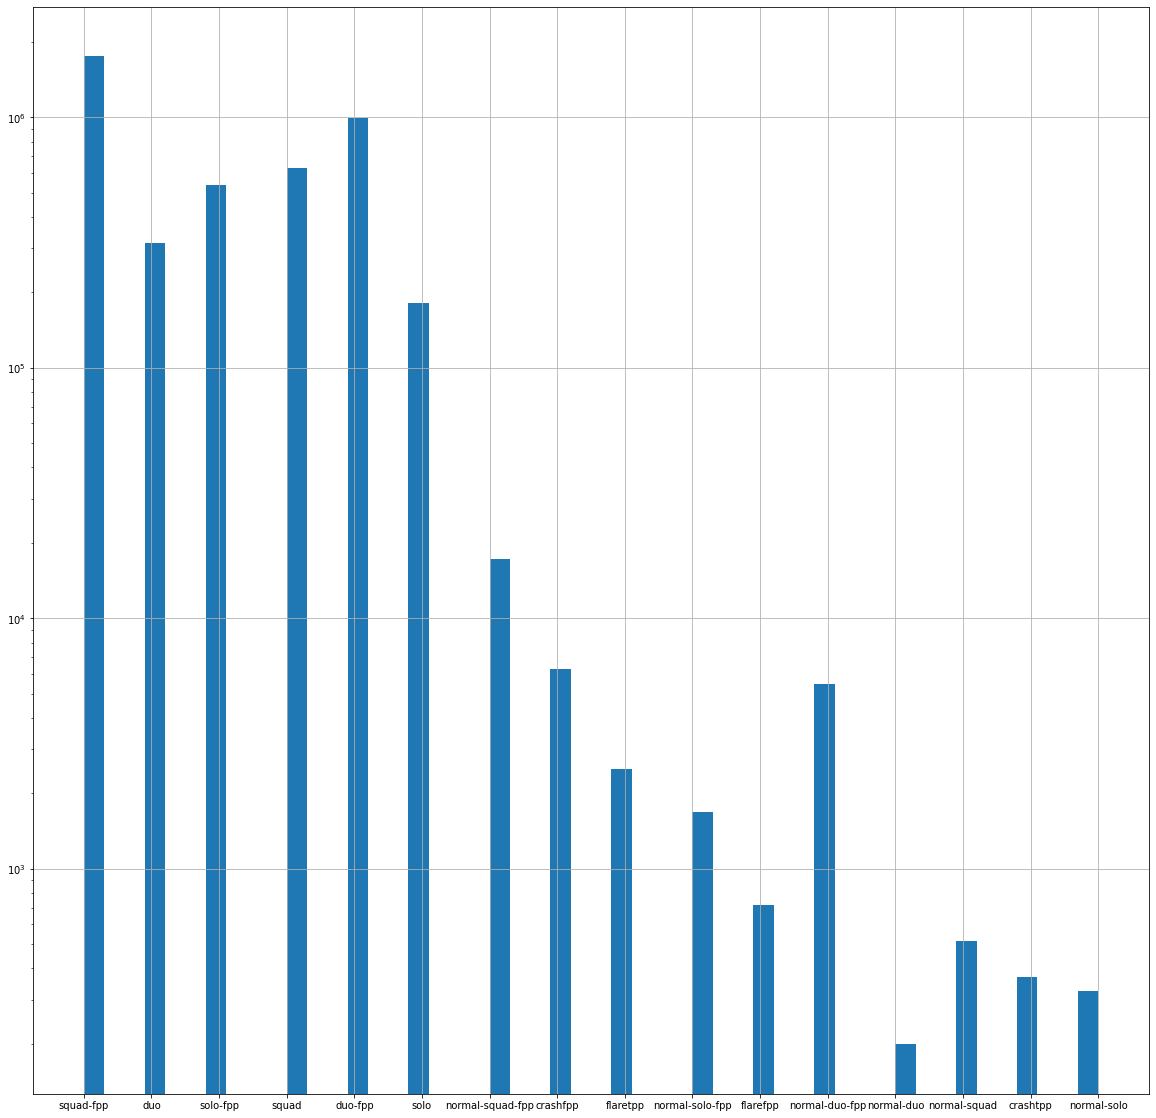

In [10]:
train['matchType'].astype('category').hist(bins=50,figsize=(20,20),log=True)

In [23]:
matchTypes

counts  Percentage
matchType                            
crashfpp             6287    0.001414
crashtpp              371    0.000083
duo                313591    0.070518
duo-fpp            996691    0.224128
flarefpp              718    0.000161
flaretpp             2505    0.000563
normal-duo            199    0.000045
normal-duo-fpp       5489    0.001234
normal-solo           326    0.000073
normal-solo-fpp      1682    0.000378
normal-squad          516    0.000116
normal-squad-fpp    17174    0.003862
solo               181943    0.040914
solo-fpp           536762    0.120703
squad              626526    0.140888
squad-fpp         1756186    0.394918

### View the Average  WinPlacePerc for ranked and unranked

In [10]:
#Split ranked and unranked
search_values = ["normal","crash","flare"]
train_rank = train[~train.matchType.str.contains('|'.join(search_values))]
train_normal = train[train.matchType.str.contains('|'.join(search_values))]

In [13]:
#Original dataset
Means = pd.DataFrame({'Mean': [train_rank["winPlacePerc"].mean(),train_normal["winPlacePerc"].mean()]})
Means

Mean
0  0.472638
1  0.495746

### Plot Correlation Heat Map 
killPoints, matchDuration, maxPlace, numGroups, rankPoints, roadKills, teamKills, winPoints has no linear correlation to maxPlacePerc.

In [23]:
def plot_heat_map(X,y):
    dataset_ = pd.concat([X,y],axis=1)
    corr = dataset_.corr()
    plt.subplots(figsize=(30,20))
    sns.heatmap( corr, square=True, annot=True, fmt=".01f" )  
    plt.show()

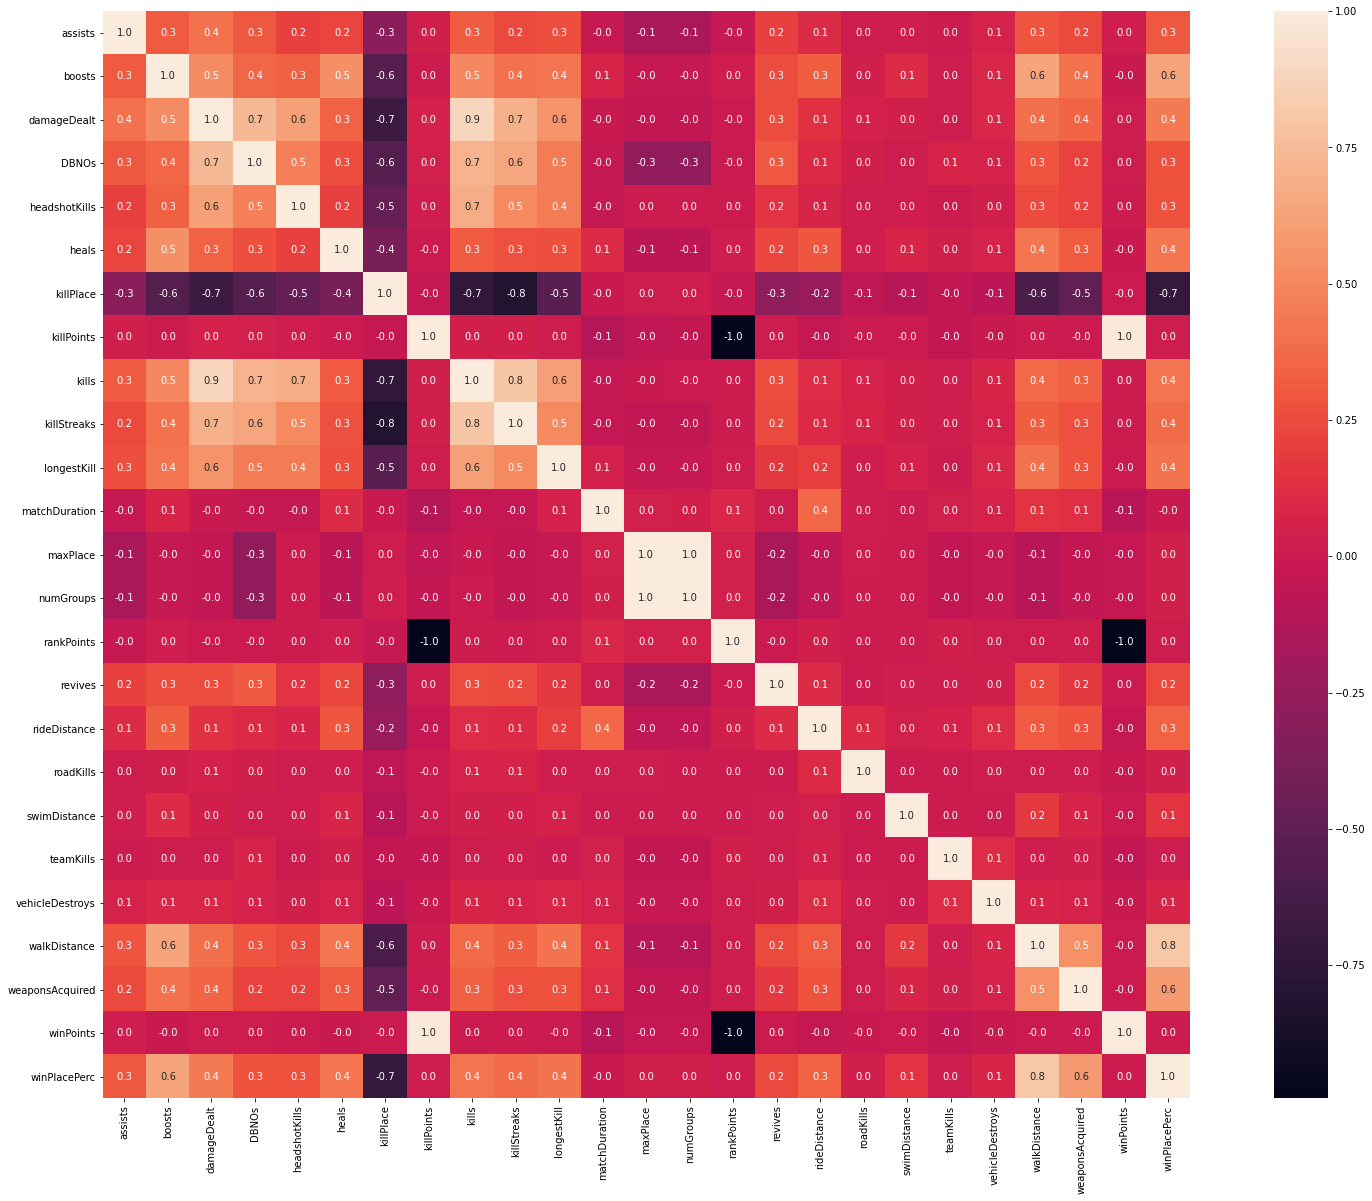

In [24]:
plot_heat_map(X_train,y_train)

### Split X and y value before preprocessing to make sure the consistency

In [25]:
#Randomly pick 80% samples as training set, 20% samples as test set
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size = 0.2,random_state = 200)

### Approach 1: 

1. Do One-Hot Encoding for "matchType"

In [26]:
def filter_1(X_train,X_test):
    
    X = pd.concat([X_train.copy(),X_test.copy()])

    #Do One-Hot Encoding for "matchType"
    X_ = pd.get_dummies(data = X, columns = ["matchType"])
    
    X_train_ = X_.head(X_train.shape[0])
    X_test_ = X_.tail(X_test.shape[0])
    return X_train_,X_test_

In [27]:
X_train_1,X_test_1 = filter_1(X_train,X_test)

### Approach 2: 

1.Delete inconsistent values such as rankPoints

2.Do One-Hot Encoding for "matchType"

In [28]:
def filter_2(X_train,X_test):
    
    X = pd.concat([X_train.copy(),X_test.copy()])
    
    #Delete inconsistent data : rankPoints, killPoints, winPoints
    X_ = X.drop(["rankPoints","killPoints","winPoints"],axis=1)

    #Do One-Hot Encoding for "matchType"
    X_ = pd.get_dummies(data = X_, columns = ["matchType"])
    
    X_train_ = X_.head(X_train.shape[0])
    X_test_ = X_.tail(X_test.shape[0])
    
    return X_train_,X_test_

In [29]:
X_train_2,X_test_2 = filter_2(X_train,X_test)

### Approach 3: 
1.Delete inconsistent values such as rankPoints

2.Combine ranked data with unranked data

3.Do One-Hot Encoding for "matchType"

In [30]:
def filter_3(X_train,X_test):
    
    X = pd.concat([X_train.copy(),X_test.copy()])
    
    #Delete inconsistent data : rankPoints, killPoints, winPoints
    X_ = X.drop(["rankPoints","killPoints","winPoints"],axis=1)

    X_ = X_.replace(["solo", "duo","squad","solo-fpp","duo-fpp", "squad-fpp"],
                    ["normal-solo","normal-duo", "normal-squad","normal-solo-fpp","normal-duo-fpp","normal-squad-fpp",])
    
    #Do One-Hot Encoding for "matchType"
    X_ = pd.get_dummies(data = X_, columns = ["matchType"])
    
    X_train_ = X_.head(X_train.shape[0])
    X_test_ = X_.tail(X_test.shape[0])
    
    return X_train_,X_test_

In [31]:
X_train_3,X_test_3 = filter_3(X_train,X_test)

### Approach 4:
1.Delete inconsistent values such as rankPoints

2.Split ranked data and unranked data (crash and flare are considered as unranked data)

3.Do One-Hot Encoding for "matchType"

In [23]:
def filter_4(X_train,X_test,y_train,y_test):
    
    train = pd.concat([X_train.copy(),y_train.copy()],axis=1)
    test = pd.concat([X_test.copy(),y_test.copy()],axis=1)
    
    #Split ranked and unranked
    search_values = ["normal","crash","flare"]
    train_rank = train[~train.matchType.str.contains('|'.join(search_values))]
    train_normal = train[train.matchType.str.contains('|'.join(search_values))]
    test_rank = test[~test.matchType.str.contains('|'.join(search_values))]
    test_normal = test[test.matchType.str.contains('|'.join(search_values))]

    #Split X and y
    y_train_rank = train_rank["winPlacePerc"]
    X_train_rank = train_rank.drop(["winPlacePerc"],axis=1)
    
    y_train_normal = train_normal["winPlacePerc"]
    X_train_normal = train_normal.drop(["winPlacePerc"],axis=1)
    
    y_test_rank = test_rank["winPlacePerc"]
    X_test_rank = test_rank.drop(["winPlacePerc"],axis=1)
    
    y_test_normal = test_normal["winPlacePerc"]
    X_test_normal = test_normal.drop(["winPlacePerc"],axis=1)
    
    #Concatenate
    X_rank = pd.concat([X_train_rank,X_test_rank])
    X_normal = pd.concat([X_train_normal,X_test_normal])
    
    #Delete inconsistent data : rankPoints, killPoints, winPoints
    X_rank = X_rank.drop(["rankPoints","killPoints","winPoints"],axis=1)
    X_normal = X_normal.drop(["rankPoints","killPoints","winPoints"],axis=1)
    
    #Do One-Hot Encoding for "matchType"
    X_rank = pd.get_dummies(data = X_rank, columns = ["matchType"])
    X_normal = pd.get_dummies(data = X_normal, columns = ["matchType"])
    
    #Split into train and test again
    X_rank_train_ = X_rank.head(X_train_rank.shape[0])
    X_rank_test_ = X_rank.tail(X_test_rank.shape[0])
    
    X_normal_train_ = X_rank.head(X_train_normal.shape[0])
    X_normal_test_ = X_rank.tail(X_test_normal.shape[0])    
    
    return X_rank_train_,y_train_rank,X_rank_test_,y_test_rank,X_normal_train_,y_train_normal,X_normal_test_,y_test_normal

In [24]:
X_train_rank,y_train_rank,X_test_rank,y_test_rank,X_train_normal,y_train_normal,X_test_normal,y_test_normal = filter_4(X_train,X_test,y_train,y_test)

# Initialize models

### Single Set
Use a list to store all models

In [35]:
n_approaches = 3

In [37]:
X_train_list = [X_train_1,X_train_2,X_train_3]
X_test_list = [X_test_1,X_test_2,X_test_3]

#### 1. SGDRegressor 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

In [41]:
sgds = [SGDRegressor()]*n_approaches

In [36]:
xgboosts = [XGBRegressor()]*n_approaches

### Multiple Sets

In [35]:
sgd_rank = SGDRegressor()
sgd_normal = SGDRegressor()

# Training & Validation

### Single set 

In [29]:
losses = ["squared_loss",'huber','epsilon_insensitive','squared_spsilon_insensitive']
penalties = ['l2','l1','elasticnet']
max_iters = [1000,2000,3000]
learning_rates = ["invscaling",'constant','optimal','adaptive']

In [ ]:
for i in range(len(sgds)):
    sgd = sgds[i]
    best_loss = None
    best_penalty = None
    best_max_iter = None
    best_learning_rate = None
    best_score = 0
    for loss in losses:
        sgd.loss = loss
        for penalty in penalties:
            sgd.penalty = penalty
            for max_iter in max_iters:
                sgd.max_iter = max_iter
                for learning_rate in learning_rates:
                    sgd.learning_rate = learning_rate
                    scores = cross_val_score(sgd, X_train_list[i], y_train, cv=5,scoring = "neg_mean_absolute_error")
                    avg_score = sum(-scores)/5
                    if(avg_score>best_score):
                        best_score = avg_score
                        best_loss = loss
                        best_penalty = penalty
                        best_max_iter = max_iter
                        best_learning_rate = learning_rate
                    print("model: ",sgd, "score: ",avg_score)
    sgds[i].loss = best_loss
    sgds[i].penalty = best_penalty
    sgds[i].max_iter = best_max_iter
    sgds[i].learning_rate = best_learning_rate

### Multiple Sets

In [ ]:
sgd_rank = SGDRegressor()
sgd_normal = SGDRegressor()

# Results

### Approach 1

#### XGBOOST 

In [38]:
xgboosts[0].fit(X_train_list[0],y_train)

[20:06:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [40]:
mean_absolute_error(xgboosts[0].predict(X_test_list[0]),y_test)

0.0690389156139343

#### SGD 

In [42]:
sgds[0].fit(X_train_list[0],y_train)

SGDRegressor()

In [43]:
mean_absolute_error(sgds[0].predict(X_test_list[0]),y_test)

0.09270425762564108

### Approach 2

#### XGBOOST 

In [44]:
xgboosts[1].fit(X_train_list[1],y_train)

[20:16:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [45]:
mean_absolute_error(xgboosts[1].predict(X_test_list[1]),y_test)

0.06916933913012845

#### SGD 

In [46]:
sgds[1].fit(X_train_list[1],y_train)

SGDRegressor()

In [47]:
mean_absolute_error(sgds[1].predict(X_test_list[1]),y_test)

0.09293350190927077

### Approach 3

#### XGBOOST 

In [48]:
xgboosts[2].fit(X_train_list[2],y_train)

[20:24:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [49]:
mean_absolute_error(xgboosts[2].predict(X_test_list[2]),y_test)

0.06914203148679031

#### SGD 

In [50]:
sgds[2].fit(X_train_list[2],y_train)

SGDRegressor()

In [51]:
mean_absolute_error(sgds[2].predict(X_test_list[2]),y_test)

0.09309614652884773

### Approach 4

#### XGBOOST 

#### SGD 

In [69]:
sgd_rank.fit(X_train_rank,y_train_rank)
sgd_normal.fit(X_train_normal,y_train_normal)

SGDRegressor()

In [70]:
(mean_absolute_error(sgd_rank.predict(X_test_rank),y_test_rank)*X_test_rank.shape[0]+mean_absolute_error(sgd_normal.predict(X_test_normal),y_test_normal)*X_test_normal.shape[0])/(X_test_rank.shape[0]+X_test_normal.shape[0])

0.09320165415469985